In [1]:
#CHIME Holography Comparison Crosscorrelation

##This notebook is based on Will Tyndall's '20221024_CHIME_Holography_Comparison' code. In that notebook, Will compares the
##autocorrelation of feed from cylinder C to the Holography data.
##The goal of this notebook is to observe the crosscorrelation of feeds in the near-field region.

##Eduardo Castro Munoz, Newburgh lab, Summer 2024.

##From loadD3Adata_Dallas.py:
'''
This first cell imports and defines all necessary packages and functions to ru the rest of the code.
It also computes some info about CHIME near/far field, and info about the drone.
'''
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import numpy as np
import h5py
##From WT:
import datetime
import pytz
import os
import glob
from matplotlib import colors
import pandas
import csv
import pickle
%matplotlib inline
import beamcals
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
from beamcals import beammap
from beamcals import reduce_ccclass
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
import beamcals.reduce_ccclass as rc
from beamcals.sites import site
chimesite=site.site('/home/ec2274/newburghlabdrone/beamcals/beamcals/sites/CHIME_config.npz')
chime_cylC=site.site('/home/ec2274/newburghlabdrone/beamcals/beamcals/sites/CHIME_CylC_config.npz')
chime_cylC2=site.site('/home/ec2274/newburghlabdrone/beamcals/beamcals/sites/CHIME_CylC_config_v2.npz')

#phase unwrap:
from skimage.restoration import unwrap_phase

# Display settings:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


## Define functions for the reactive NF, FF, and range of the radiating NF [all units cm]:
    #inputs are dish diameter (D) and wavelength (Lambda) both in cm!
    
def Reactive_NF_Distance_m(D,Lambda):
    return (1.0/100.0)*0.62*np.sqrt((D**3.0)/Lambda)

def FF_Distance_m(D,Lambda):
    return (1.0/100.0)*2.0*(D**2.0)/Lambda

def Radiative_NF_Bounds_m(D,Lambda):
    return [Reactive_NF_Distance_m(D,Lambda),FF_Distance_m(D,Lambda)]

from scipy.optimize import curve_fit
from scipy.optimize import least_squares

## Import auxilary packages:
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz
import astropy.coordinates as coord


## DEFN the Gauss Fit function:
def Gauss_opt(P,x,V):
    a,x0,sigma,k=P
    return a*np.exp(-(x-x0)**2.0/(2.0*sigma**2.0))+k-V

def telescopeCoords(HA,Dec,lat=49.320751,deg=False):
    '''Return telescope coordinates[
    y (sine of zenith angle) increasing to the North
    x increasing to the east
    for HA, Dec given in degrees
    if deg=True, y is[returned as[zenith angle in degrees[(North positive)
    '''
    # convert celestial coordinates[to theta,phi
    t = np.radians(90. - Dec)
    p = -1.*np.radians(HA)
    # convert theta,phi to X vector in celestial frame
    # x_hat = in equitorial plane pointing toward 0 HA
    # y_hat = in equitorial plane pointing toward -90 HA (East)
    # z_hat = north celestial pole
    x = np.sin(t)*np.cos(p)
    y = np.sin(t)*np.sin(p)
    z = np.cos(t)
    X = np.stack((x,y,z),axis=-1)
    # rotate X to X' in telescope frame
    # x'_hat = zenith
    # y'_hat = East
    # z'_hat = North
    beta = np.radians(lat)
    k = np.array([0,1,0])[np.newaxis,:]
    Xp = np.cos(beta)*X
    Xp += np.sin(beta)*np.cross(k,X)
    Xp += np.inner(X,k)*(1-np.cos(beta))*k
    # convert X' to theta',phi' in telescope frame
    bxp,byp,bzp = np.transpose(Xp)
    tp = np.arctan2(np.sqrt(bxp**2 + byp**2),bzp)
    pp = np.arctan2(byp,bxp)
    # convert theta',phi' to telescope x,y
    za = 0.5*np.pi - tp
    if deg:
        y = np.degrees(za) 
    else:
        y = np.sin(za)
    x = np.sin(tp)*np.sin(pp)
    return (y,x)

def ground_to_sph(x,y,lat=49.320751*(np.pi/180.0)):
    """Get the CIRS coordinates.

    Latitude is given in radians. Assumes z is positive

    Parameters
    ----------
    x : array_like
        The East projection of the angular position
    y : array_like
        The North projection of the angular position
    lat : array_like
        The latitude of the observatory.

    Returns
    -------
    ha, dec: array_like
        Hour Angle and declination in radians
    """
    z = np.sqrt(1 - x**2 - y**2)

    xe = z * np.cos(lat) - y * np.sin(lat)
    ye = x
    ze = y * np.cos(lat) + z * np.sin(lat)

    ha = -1 * np.arctan2(ye, xe)
    dec = np.arctan2(ze, np.sqrt(xe**2 + ye**2))

    return ha, dec

CHIME_ANG=0.071#deg

def CHIME_2d_Rot(X,Y,theta=CHIME_ANG):
    xp=X*np.cos(theta*np.pi/180.0)-Y*np.sin(theta*np.pi/180.0)
    yp=X*np.sin(theta*np.pi/180.0)+Y*np.cos(theta*np.pi/180.0)
    return [xp,yp]

##Directories
dronedir='/hirax/CHIME_Oct_2022/20221025_CHIME_DJI_Data/'

## Specify frequency and wavelength ranges for correlator:
freq=np.linspace(800,400,1024)
wavelength=3e10/(1e6*freq)
CHIME_D=20.0*100
print("Minimum frequency = {:.2f}MHz is maximum wavelength = {:.2f}cm".format(min(freq),max(wavelength)))
print("Maximum frequency = {:.2f}MHz is minimum wavelength = {:.2f}cm".format(max(freq),min(wavelength)))

## What should the grid spacing look li700,650ke? (lam700,650bda/2 for nyquist sampling...)
print("Nyquist sampling grid spacing is min(wavelength)/2 = {:.2f}cm".format(min(wavelength)/2.0))

## What altitude should we do the flight at to be in the radiating nearfield?
print(Radiative_NF_Bounds_m(CHIME_D,min(wavelength)))
print(Radiative_NF_Bounds_m(CHIME_D,max(wavelength)))
print("Maximum Radiating NF Altitude for our frequency range = {:.2f}m".format(Reactive_NF_Distance_m(CHIME_D,min(wavelength))))
print("Minimum FF Altitude for our frequency range = {:.2f}m".format(FF_Distance_m(CHIME_D,max(wavelength))))

delX=11.0 #0.2143 #m
delY=11.0 #0.2143 #m
delT=2.0 #sec
grid_alt=305 #25.0
# I will suggest ~25.0m above the feeds, since this will give us some cushion for the autopilot offsets.

## If we want to measure E field components for points +30deg to -30deg from zenith at 25m,
## Then our grid would have sides of length 28.86m to measure one dish centered at (0,0)...
grid_sidelength=2*(grid_alt*np.tan(np.pi/180.0*30.0))
print("For a {}m alt grid that spans [+30.0,-30.0] deg, sides must be {:.2f}m".format(grid_alt,grid_sidelength))
## How many points will a pass contain if sampled at nyquist freq?
grid_pts_per_pass=int(np.ceil(grid_sidelength/delX))
print("If sampled at nyquist [{}m] each pass will contain {} points".format(delX,grid_pts_per_pass))
## How many points would the grid contain?
grid_num_pts=grid_pts_per_pass**2
print("The grid would then contain {} points".format((grid_num_pts)))
## How long would a flight take?
grid_flight_time=grid_num_pts*delT/60
print("The flight would take approximately {:.2f} minutes".format(grid_flight_time))
## How fast should the drone fly?
grid_flight_speed=(delX/delT)
print("If sampled at nyquist [{}m] the drone can fly at {:.2f}m/s".format(delX,grid_flight_speed))

Minimum frequency = 400.00MHz is maximum wavelength = 75.00cm
Maximum frequency = 800.00MHz is minimum wavelength = 37.50cm
Nyquist sampling grid spacing is min(wavelength)/2 = 18.75cm
[90.55679617418745, 2133.3333333333335]
[64.03332465729596, 1066.6666666666667]
Maximum Radiating NF Altitude for our frequency range = 90.56m
Minimum FF Altitude for our frequency range = 1066.67m
For a 305m alt grid that spans [+30.0,-30.0] deg, sides must be 352.18m
If sampled at nyquist [11.0m] each pass will contain 33 points
The grid would then contain 1089 points
The flight would take approximately 36.30 minutes
If sampled at nyquist [11.0m] the drone can fly at 5.50m/s


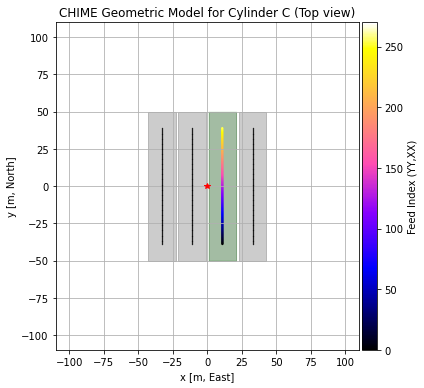

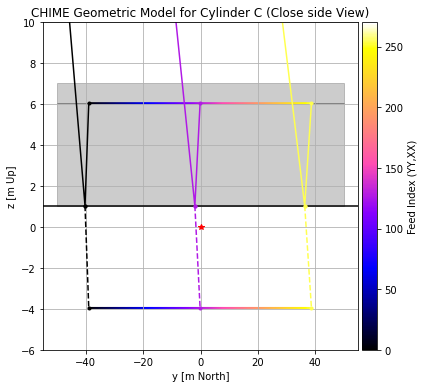

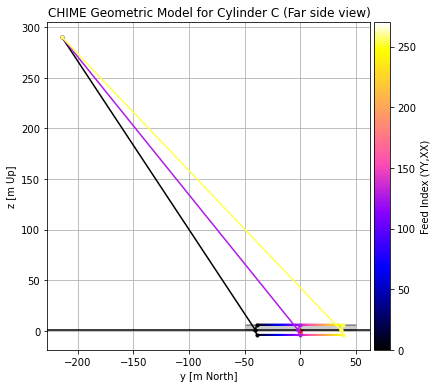

In [2]:
##Geometric Model for CHIME Cylinder C. 

fig,ax=subplots(nrows=1,ncols=1,figsize=(6,5.5),sharex=True,sharey=True)
xlim(-110,110)
ylim(-110,110)
plot(0,0,'r*')
for j in [-33,-11,11,33]:
    x=np.array([j-10,j+10])
    y1=np.array([-50,-50])
    y2=np.array([50,50])
    xf=j*np.ones(256)
    yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
    xf0,yf0=CHIME_2d_Rot(xf,yf)
    x0,y10=CHIME_2d_Rot(x,y1)
    x0,y20=CHIME_2d_Rot(x,y2)
    fill_between(x,y1,y2,color='k',alpha=0.2)
    if j in [-33,-11,33]:
        plot(xf,yf,'k.',markersize=0.5)
        #fill_between(x0,y10,y20,color='r',alpha=0.2)
        #plot(xf0,yf0,'r.',markersize=0.5)
    if j in [11]:
        fill_between(x0,y10,y20,color='g',alpha=0.2)
        im=ax.scatter(xf0,yf0,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')
divider=make_axes_locatable(ax)
cax=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.set_label('Feed Index (YY,XX)')
ax.set_title("CHIME Geometric Model for Cylinder C (Top view)")
ax.set_xlabel('x [m, East]')
ax.set_ylabel('y [m, North]')
ax.grid()
tight_layout()

fig1,ax1=subplots(nrows=1,ncols=1,figsize=(6,5.5),sharex=True,sharey=True)
xlim(-55,55)
ylim(-6,10)
plot(0,0,'r*')
y=np.array([-50,50])
dx,dy,dz=[0,-214,290]
z1=np.array([1.047,1.047])
z2=np.array([6.047,6.047])
z3=np.array([7.047,7.047])
yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zf=6.047*np.ones(256)
fill_between(y,z1,z2,color='k',alpha=0.2)
fill_between(y,z2,z3,color='k',alpha=0.2)
im=ax1.scatter(yf,zf,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')
divider=make_axes_locatable(ax1)
cax1=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig1.colorbar(im,cax=cax1)
cbar.set_label('Feed Index (YY,XX)')
ax1.set_title("CHIME Geometric Model for Cylinder C (Close side View)")
ax1.set_xlabel('y [m North]')
ax1.set_ylabel('z [m Up]')
ax1.grid()
tight_layout()
ax1.axhline(1.047,color='k')
zi=-3.953*np.ones(256)
yi=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zb=1.047*np.ones(256)
yb=[zb[i]+(-1.0*(dz-(((zi[i]-dz)/(yi[i]-dy))*dy)))/((zi[i]-dz)/(yi[i]-dy)) for i in range(256)]
colorsarr=cm.gnuplot2(np.linspace(0,1,270))
for i in range(256)[::127]:
    ax1.plot([dy,yb[i],yf[i]],[dz,zb[i],zf[i]],'.-',c=colorsarr[i])
    ax1.plot([yb[i],yi[i]],[zb[i],zi[i]],'.--',c=colorsarr[i])
im=ax1.scatter(yi,zi,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')

fig1,ax1=subplots(nrows=1,ncols=1,figsize=(6,5.5),sharex=True,sharey=True)
# xlim(-55,55)
# ylim(-6,10)
plot(0,0,'r*')
y=np.array([-50,50])
dx,dy,dz=[0,-214,290]
z1=np.array([1.047,1.047])
z2=np.array([6.047,6.047])
z3=np.array([7.047,7.047])
yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zf=6.047*np.ones(256)
fill_between(y,z1,z2,color='k',alpha=0.2)
fill_between(y,z2,z3,color='k',alpha=0.2)
im=ax1.scatter(yf,zf,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')
divider=make_axes_locatable(ax1)
cax1=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig1.colorbar(im,cax=cax1)
cbar.set_label('Feed Index (YY,XX)')
ax1.set_title("CHIME Geometric Model for Cylinder C (Far side view)")
ax1.set_xlabel('y [m North]')
ax1.set_ylabel('z [m Up]')
ax1.grid()
tight_layout()
ax1.axhline(01.047,color='k')
zi=-3.953*np.ones(256)
yi=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
zb=1.047*np.ones(256)
yb=[zb[i]+(-1.0*(dz-(((zi[i]-dz)/(yi[i]-dy))*dy)))/((zi[i]-dz)/(yi[i]-dy)) for i in range(256)]
colorsarr=cm.gnuplot2(np.linspace(0,1,270))
for i in range(256)[::127]:
    ax1.plot([dy,yb[i],yf[i]],[dz,zb[i],zf[i]],'.-',c=colorsarr[i])
    ax1.plot([yb[i],yi[i]],[zb[i],zi[i]],'.--',c=colorsarr[i])
im=ax1.scatter(yi,zi,c=range(256),vmin=0,vmax=270,s=1,cmap='gnuplot2')

In [ ]:
'''
This cell displays the info in each column of the CSV file. I'm not sure what the calculation in the last line means, but it prevents
the code from displaying a bunch of 'none' outputs.

Okay to skip it.
'''

ddat=pandas.read_csv('/hirax/CHIME_Oct_2022/20221025_CHIME_DJI_Data/FLY758.csv')
# ddat=pandas.read_csv('../../Desktop/hirax/20221031_D3A_DJI_Data/FLY777.csv')
[print(j,ddat.columns[j]) for j in range(len(ddat.columns))]
821 - 545 +1.047 - 5

In [68]:
## Drone flight Data: y throw complex data:
gaindir='/hirax/20220824_WLC_NFandFF/WLC_Corr_Data/20220825T202602Z_Suit_digitalgain/'
datadir='/hirax/CHIME_Oct_2022/20221028T212339Z_chimedronegatedN2_corr/'
EWN2drone=drone.Drone_Data(dronedir,'FLY754.csv',site_class=chimesite)

Initializing drone data via datcon_csv routine: FLY754.csv
  --> Skipping rows 1 to 499 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK data contains 10041/10041 non-nan values
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.


In [40]:
plt.scatter(EWN2drone.coords_xyz_LC[:,0],EWN2drone.coords_xyz_LC[:,1],
            c=np.ones(len(EWN2drone.coords_xyz_LC[:,0])))

print(NSN2drone.t_arr_datetime[0],NSN2drone.t_arr_datetime[-1])

NameError: name 'NSN2drone' is not defined

2022-10-28T19:45:27Z
2022-10-28T19:49:01Z
90.06199414936083


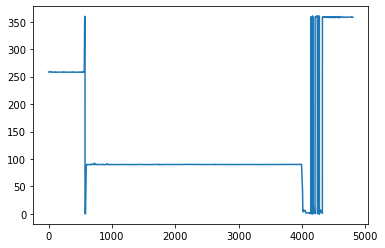

In [36]:
plt.plot(EWN2drone.yaw)
print(EWN2drone.t_arr_timestamp[1500-71])
print(EWN2drone.t_arr_timestamp[2500])
print(EWN2drone.yaw[1500-71])

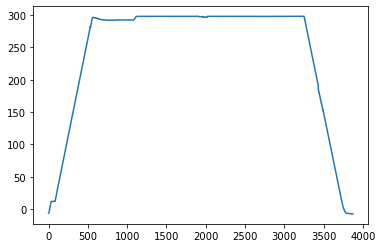

In [39]:
plt.plot(EWN2drone.altitude)

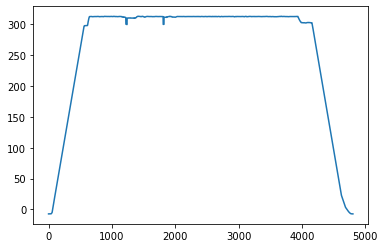

In [67]:
plt.plot(EWN2drone.altitude)

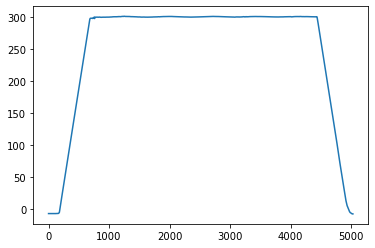

In [69]:
plt.plot(EWN2drone.altitude)

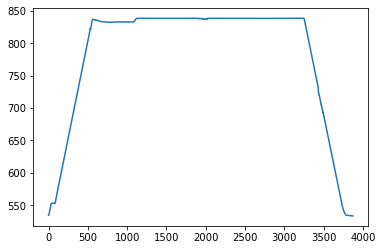

In [48]:
plt.plot(EWN2drone.coords_xyz_LC[:,2]+chime_cylC2.origin[2])

In [50]:
print(chime_cylC2.origin[0])
print(chime_cylC2.origin[1])
print(chime_cylC2.origin[2])

49.3207092194
-119.623677431
540.671


In [ ]:
## Cross Only: Look at cross-corr data for one baseline?
fig,[ax1,ax2,ax3,ax4]=subplots(nrows=1,ncols=4,figsize=(40,10))
feeds=[0,1,2]
tlb,tub=[0,-1]
feed=2
vmin1=-0.01
vmax1=0.5
vmin2=-3.5
vmax2=2.5
vmin3=-0.01
vmax3=0.005
vmin4=-0.015
vmax4=0.01
xmg, fmg = np.meshgrid(NSN2concat.drone_xyz_LC_interp[tlb:tub, 1], NSN2concat.freq)
im1=ax1.pcolormesh(xmg,fmg,np.abs(np.transpose(NSN2concat.V[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin1, vmax=vmax1)
im2=ax2.pcolormesh(xmg,fmg,np.angle(np.transpose(NSN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin2, vmax=vmax2)
im3=ax3.pcolormesh(xmg,fmg,np.real(np.transpose(NSN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin3, vmax=vmax3)
im4=ax4.pcolormesh(xmg,fmg,np.imag(np.transpose(NSN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin4, vmax=vmax4)

images=[im1,im2,im3,im4]
titles=['abs,','ang','real','imag']
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    im=images[i]
    ax.set_title(titles[i], fontsize=16)
    #ax0.axvline(yf[feed],c='k',linestyle='--')
    ax.set_ylabel('Frequency, [$MHz$]', fontsize=14)
    ax.set_xlabel('$\Delta$Time [$s$]', fontsize=14)
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(im,cax=cax)
    cbar.set_label('Power [$ADU^2$]', fontsize=14)
    #for k in (-50,50):
     #   ax0.axvline(k,c='k',linestyle='-',alpha=0.5)
tight_layout()

In [ ]:
## Cross Only: Look at cross-corr data for one baseline?
fig,[ax1,ax2,ax3,ax4]=subplots(nrows=1,ncols=4,figsize=(40,10))
feeds=[1,2,3]
tlb,tub=[0,64]
feed=0
xmg,fmg=np.meshgrid(NSN2concat.drone_xyz_LC_interp[tlb:tub,1],NSN2concat.freq)
im1=ax1.pcolormesh(xmg,fmg,np.abs(np.transpose(NSN2concat.V[tlb:tub,:,feed])),cmap='gnuplot2')
im2=ax2.pcolormesh(xmg,fmg,np.angle(np.transpose(NSN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2')
im3=ax3.pcolormesh(xmg,fmg,np.real(np.transpose(NSN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2')
im4=ax4.pcolormesh(xmg,fmg,np.imag(np.transpose(NSN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2')
images=[im1,im2,im3,im4]
titles=['abs,','ang','real','imag']
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    im=images[i]
    ax.set_title(titles[i])
    ax0.axvline(yf[feed],c='k',linestyle='--')
    ax.set_xlabel('Frequency, [$MHz$]')
    ax.set_ylabel('$\Delta$Time [$s$]')
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig1.colorbar(im,cax=cax)
    cbar.set_label('Power [$ADU^2$]')
    for k in (-50,50):
        ax0.axvline(k,c='k',linestyle='-',alpha=0.5)
tight_layout()

In [88]:
import numpy as np

# Check array shapes
print("Shape of drone_xyz_LC_interp:", EWN2concat.drone_xyz_LC_interp.shape)
print("Shape of freq:", EWN2concat.freq.shape)
print("Shape of V:", EWN2concat.V.shape)
print("Shape of V_cross:", EWN2concat.V_cross.shape)

# Verify slicing indices
print("tlb:", tlb)
print("tub:", tub)

# Handle empty arrays or invalid shapes
if NSN2concat.V.size == 0 or NSN2concat.V_cross.size == 0:
    raise ValueError("One or more arrays are empty!")

# Continue with meshgrid and plotting
xmg, fmg = np.meshgrid(NSN2concat.drone_xyz_LC_interp[tlb:tub, 1], NSN2concat.freq)

# Plotting code using pcolormesh
# ...


Shape of drone_xyz_LC_interp: (512, 3)
Shape of freq: (64,)
Shape of V: (512, 64, 512)
Shape of V_cross: (512, 64, 0)
tlb: 150
tub: 245


NameError: name 'NSN2concat' is not defined

In [ ]:
##EAST-WEST FLIGHT

In [ ]:
## Comments...

In [2]:
datadirp='/hirax/CHIME_Oct_2022/20221028T212339Z_chimedronegatedN2_corr/'
fnp='00003495_0000.h5'
fd_np=h5py.File(datadirp+fnp, 'r')

index_map=fd_np['index_map']
blTot = 131328
blMatrix = np.zeros((512,512), dtype=int)

for i in range(blTot):
    x,y=index_map['prod'][i]
    blMatrix[x,y] = i 

diagEnt = np.diagonal(blMatrix) #512 indexes
vis=np.array(fd_np['vis']).transpose(2,0,1) #time, freq, entry
print(vis.shape)

freqList = np.array([item['centre'] for item in index_map['freq'][:]], dtype=float)
peakInd=198 #Timestamp for the peak for flight 758
## Loading timestamps around the peak to study the time evolution of the 30MHz ripples
peakIndMinOne=197
peakIndMinTwo=196
peakIndMinThree=195
peakIndPluOne=199
peakIndPluTwo=200
peakIndPluThree=201

(256, 64, 131328)


/home/ec2274/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


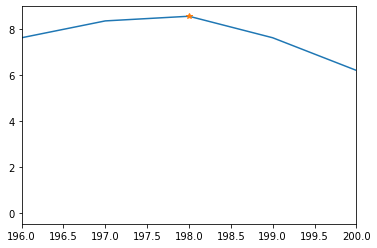

In [3]:
plt.plot(vis[:,44,diagEnt[9]])
plt.plot(198,vis[198,44,diagEnt[9]], marker='*')
plt.xlim(196,200)
peakInd=198
peakIndMinOne=197
peakIndMinTwo=196
peakIndMinThree=195
peakIndPluOne=199
peakIndPluTwo=200
peakIndPluThree=201

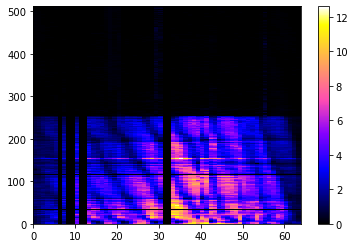

In [13]:
'''
vmin1=2
vmax1=0.1
vmin2=-3.5
vmax2=2.5
vmin3=-.1
vmax3=.1
vmin4=-0.015
vmax4=0.01
'''
#xmg,fmg = np.meshgrid(np.arange(64), np.arange(len(diagEnt))
plt.pcolormesh(np.abs(vis[peakInd,:,diagEnt]),cmap='gnuplot2')
plt.colorbar()
plt.show()

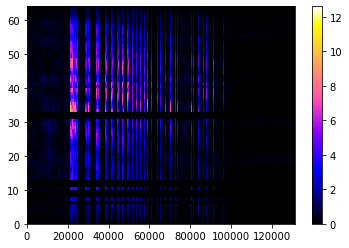

In [25]:
#xmg,fmg = np.meshgrid(np.arange(64), np.arange(len(diagEnt))
plt.pcolormesh(np.abs(vis[peakInd,:,:]),cmap='gnuplot2')
plt.colorbar()
plt.show()

In [8]:
index_map=fd_np['index_map']
blTot = 131328
blMatrix = np.zeros((512,512), dtype=int)

for i in range(blTot):
    x,y=index_map['prod'][i]
    blMatrix[x,y] = i 

XXpols = []
for i in np.arange(0,256):
    for j in np.arange(0,256):
        if j>i:
            XXpols.append(blMatrix[i,j])
np.array(XXpols)
print(len(XXpols))

32640


In [61]:
#print(index_map['freq'][:])
freqList = np.array([item['centre'] for item in index_map['freq'][:]], dtype=float)
print(freqList)

[799.609375 795.3125   791.015625 785.9375   781.640625 777.34375
 772.65625  767.96875  764.0625   759.765625 728.125    724.21875
 719.921875 715.625    709.765625 705.859375 701.5625   691.796875
 687.5      682.8125   678.515625 674.21875  670.3125   666.015625
 661.71875  657.8125   653.125    648.828125 644.140625 640.234375
 635.9375   631.640625 627.34375  613.671875 609.375    605.078125
 601.171875 596.875    592.1875   587.890625 563.28125  558.59375
 541.015625 537.109375 525.       520.703125 516.40625  512.5
 508.203125 495.3125   480.46875  474.609375 470.3125   462.890625
 454.296875 446.484375 441.015625 434.765625 430.078125 425.78125
 421.484375 416.796875 411.328125 407.03125 ]


In [14]:
## First set of diagonals

oneAway = np.array([], dtype=int)

index = 0
for i in range(256,-1,-1):
    index = 256*(256-1)//2 - i* (i-1)//2
    if index >= len(XXpols):
        break
    oneAway = np.append(oneAway, XXpols[index])
    print(f"Index: {index}, Length of XXpols: {len(XXpols)}")
    
print("Final oneAway array:")
print(oneAway)

Index: 0, Length of XXpols: 32640
Index: 255, Length of XXpols: 32640
Index: 509, Length of XXpols: 32640
Index: 762, Length of XXpols: 32640
Index: 1014, Length of XXpols: 32640
Index: 1265, Length of XXpols: 32640
Index: 1515, Length of XXpols: 32640
Index: 1764, Length of XXpols: 32640
Index: 2012, Length of XXpols: 32640
Index: 2259, Length of XXpols: 32640
Index: 2505, Length of XXpols: 32640
Index: 2750, Length of XXpols: 32640
Index: 2994, Length of XXpols: 32640
Index: 3237, Length of XXpols: 32640
Index: 3479, Length of XXpols: 32640
Index: 3720, Length of XXpols: 32640
Index: 3960, Length of XXpols: 32640
Index: 4199, Length of XXpols: 32640
Index: 4437, Length of XXpols: 32640
Index: 4674, Length of XXpols: 32640
Index: 4910, Length of XXpols: 32640
Index: 5145, Length of XXpols: 32640
Index: 5379, Length of XXpols: 32640
Index: 5612, Length of XXpols: 32640
Index: 5844, Length of XXpols: 32640
Index: 6075, Length of XXpols: 32640
Index: 6305, Length of XXpols: 32640
Index: 

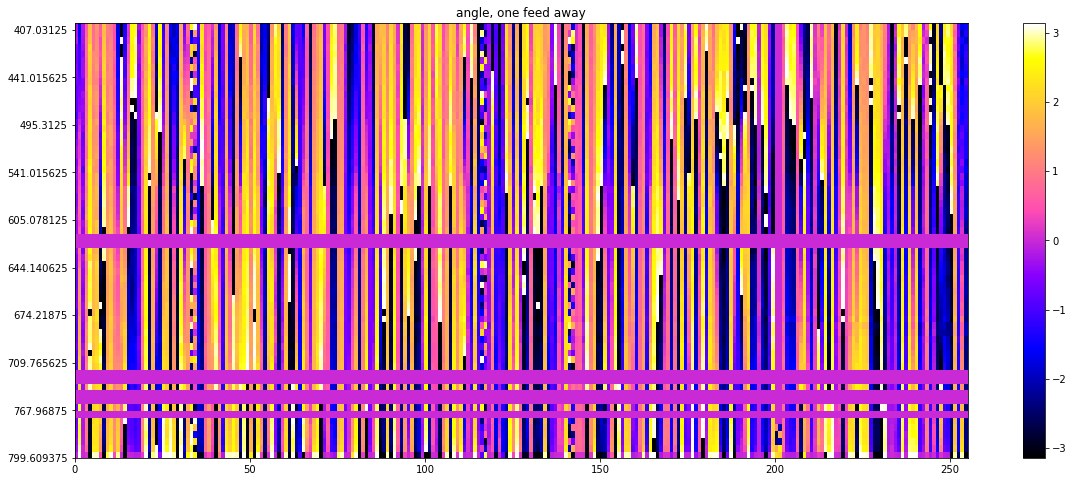

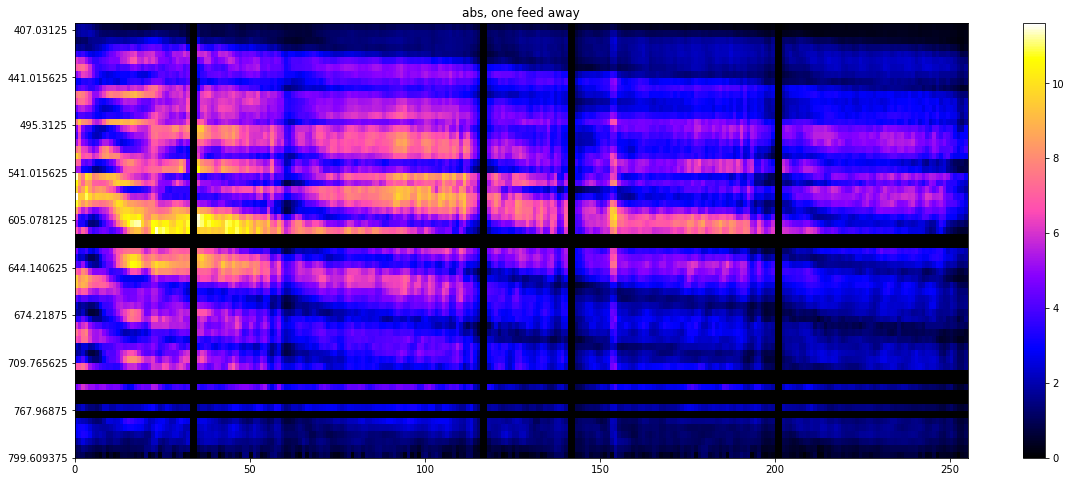

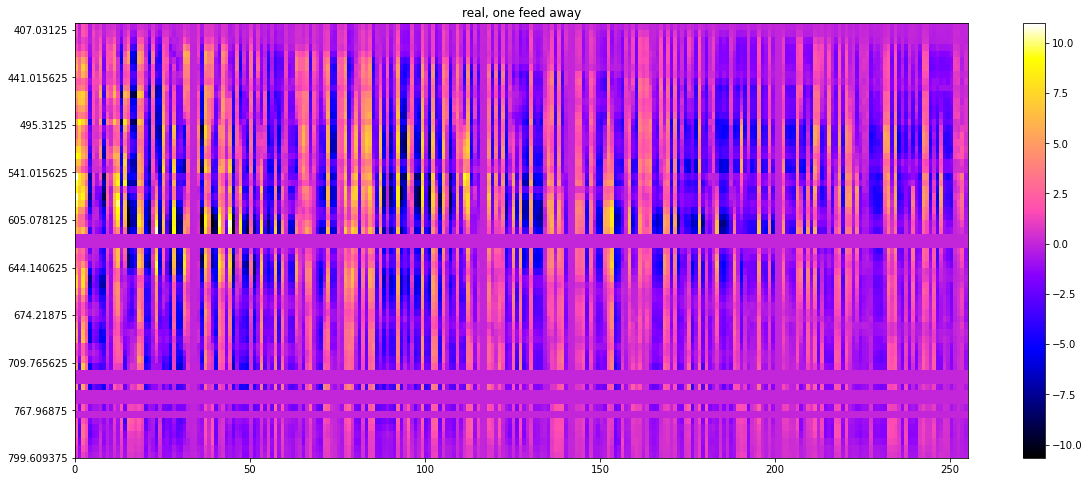

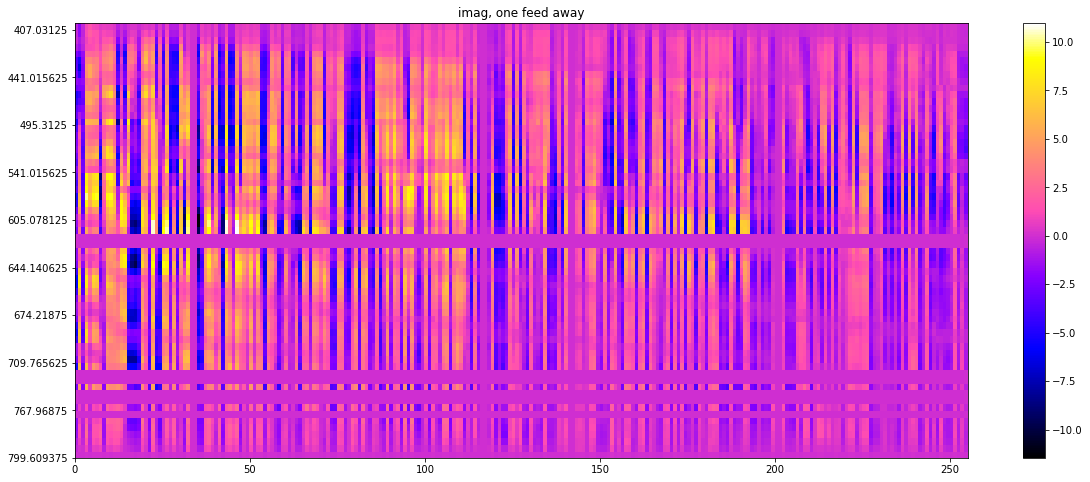

In [62]:
# Plots from the peak

plt.pcolormesh(np.arctan2(np.imag(np.transpose(vis[peakInd,:,oneAway])), np.real(np.transpose(vis[peakInd,:,oneAway]))), cmap='gnuplot2')
plt.rcParams["figure.figsize"] = (20,8)
plt.title('angle, one feed away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakInd,:,oneAway])), cmap='gnuplot2')
plt.rcParams["figure.figsize"] = (20,8)
plt.title('abs, one feed away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.real(np.transpose(vis[peakInd,:,oneAway])), cmap='gnuplot2')
plt.rcParams["figure.figsize"] = (20,8)
plt.title('real, one feed away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.imag(np.transpose(vis[peakInd,:,oneAway])), cmap='gnuplot2')
plt.rcParams["figure.figsize"] = (20,8)
plt.title('imag, one feed away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

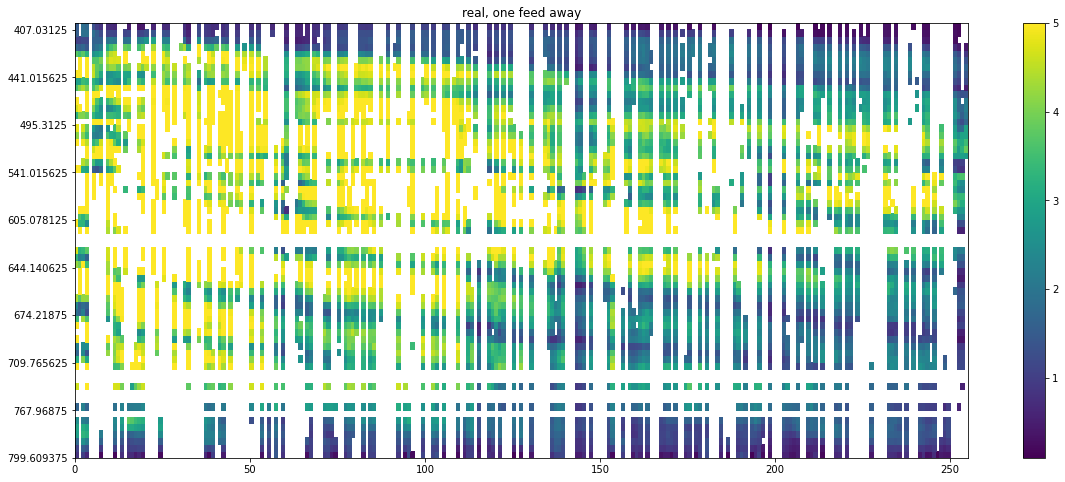

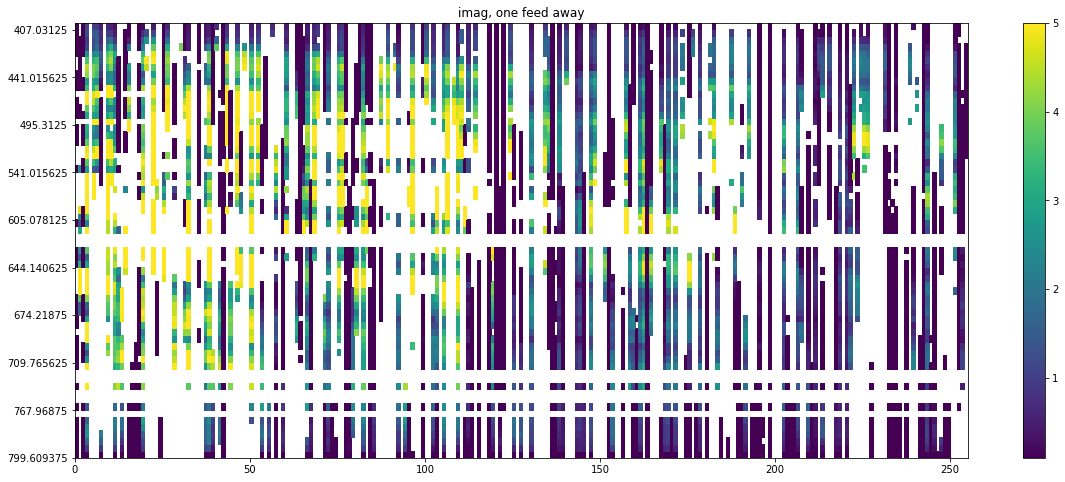

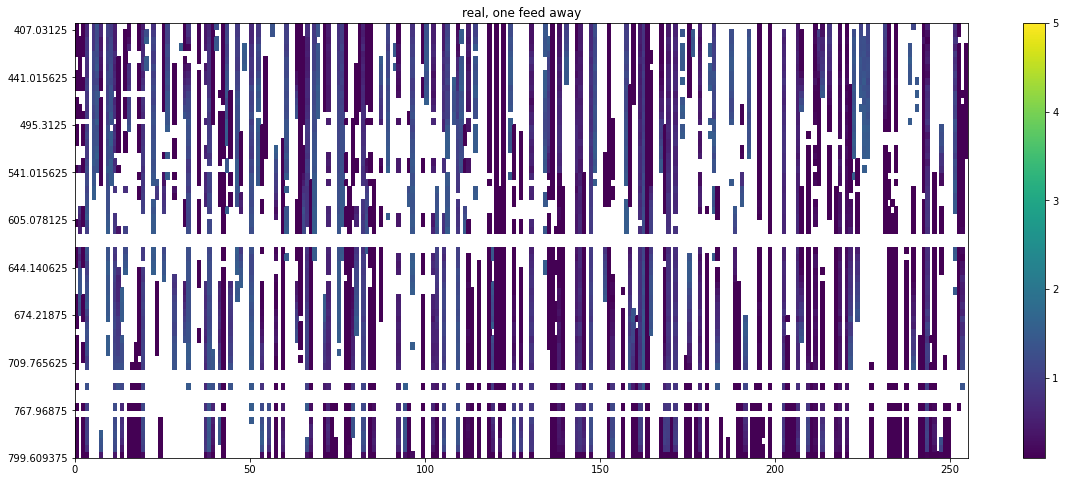

In [35]:
import numpy.ma as ma

masked_data = ma.masked_outside(np.transpose(vis[peakInd,:,oneAway]), .1, 5)
x = np.arange(np.transpose(vis[peakInd,:,oneAway]).shape[1]+1)
y = np.arange(np.transpose(vis[peakInd,:,oneAway]).shape[0]+1)
X, Y = np.meshgrid(x, y)

# Plot using pcolormesh
plt.pcolormesh(X, Y, np.abs(masked_data), cmap='viridis', vmin=.1, vmax=5)
plt.rcParams["figure.figsize"] = (20,8)
plt.title('real, one feed away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(X, Y, np.imag(masked_data), cmap='viridis', vmin=.1, vmax=5)
plt.rcParams["figure.figsize"] = (20,8)
plt.title('imag, one feed away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(X, Y, np.angle(masked_data), cmap='viridis', vmin=.1, vmax=5)
plt.rcParams["figure.figsize"] = (20,8)
plt.title('real, one feed away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()



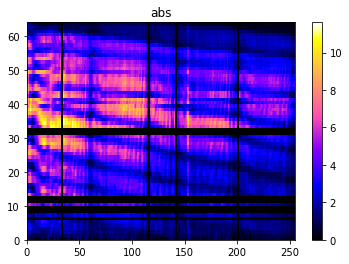

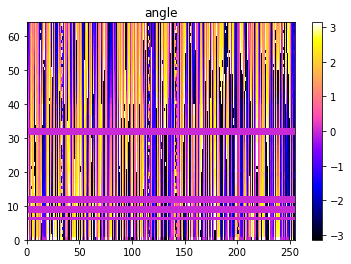

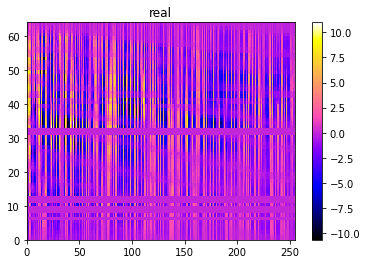

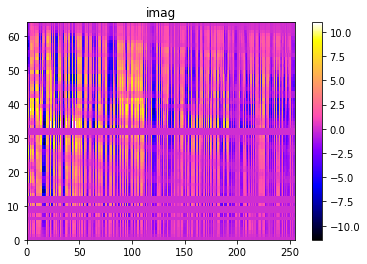

In [78]:
## Plots for the first diagonal

peakInd = 198

plt.rcParams["figure.figsize"] = (20,3)
plt.pcolormesh(np.abs(np.transpose(vis[peakInd,:,oneAway])),cmap='gnuplot2')
plt.title('abs')
plt.colorbar()
plt.show()

plt.pcolormesh(np.angle(np.transpose(vis[peakInd,:,oneAway])),cmap='gnuplot2')
plt.title('angle')
plt.colorbar()
plt.show()

plt.pcolormesh(np.real(np.transpose(vis[peakInd,:,oneAway])),cmap='gnuplot2')
plt.title('real')
plt.colorbar()
plt.show()

plt.pcolormesh(np.imag(np.transpose(vis[peakInd,:,oneAway])),cmap='gnuplot2')
plt.title('imag')
plt.colorbar()
plt.show()

In [9]:
## Second set of off-diagonals

twoAway = np.array([], dtype=int)

for i in range(256,-1,-1):
    index = 256*(256-1)//2 - i* (i-1)//2 +1
    if index >= len(XXpols):
        break
    twoAway = np.append(twoAway, XXpols[index])
    print(f"Index: {index}, Length of XXpols: {len(XXpols)}")

Index: 1, Length of XXpols: 32640
Index: 256, Length of XXpols: 32640
Index: 510, Length of XXpols: 32640
Index: 763, Length of XXpols: 32640
Index: 1015, Length of XXpols: 32640
Index: 1266, Length of XXpols: 32640
Index: 1516, Length of XXpols: 32640
Index: 1765, Length of XXpols: 32640
Index: 2013, Length of XXpols: 32640
Index: 2260, Length of XXpols: 32640
Index: 2506, Length of XXpols: 32640
Index: 2751, Length of XXpols: 32640
Index: 2995, Length of XXpols: 32640
Index: 3238, Length of XXpols: 32640
Index: 3480, Length of XXpols: 32640
Index: 3721, Length of XXpols: 32640
Index: 3961, Length of XXpols: 32640
Index: 4200, Length of XXpols: 32640
Index: 4438, Length of XXpols: 32640
Index: 4675, Length of XXpols: 32640
Index: 4911, Length of XXpols: 32640
Index: 5146, Length of XXpols: 32640
Index: 5380, Length of XXpols: 32640
Index: 5613, Length of XXpols: 32640
Index: 5845, Length of XXpols: 32640
Index: 6076, Length of XXpols: 32640
Index: 6306, Length of XXpols: 32640
Index: 

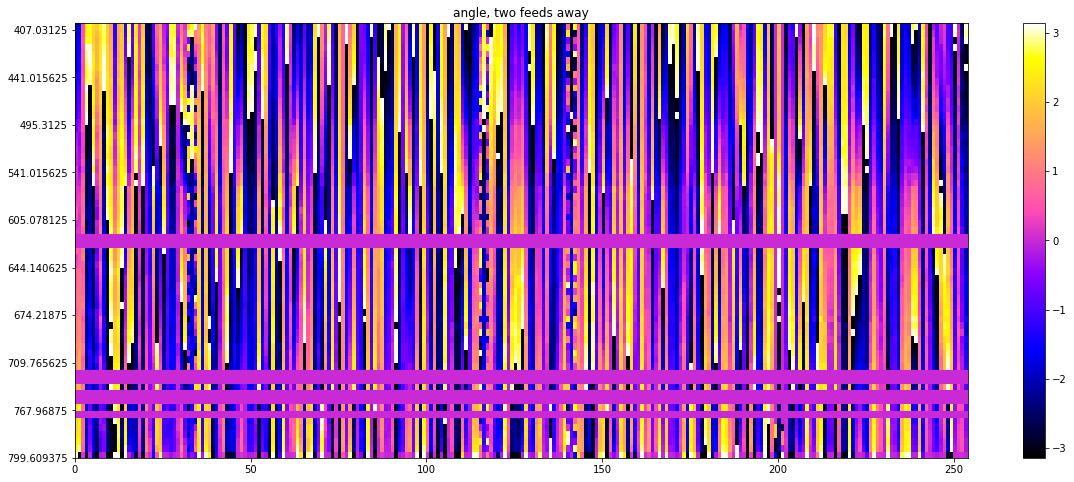

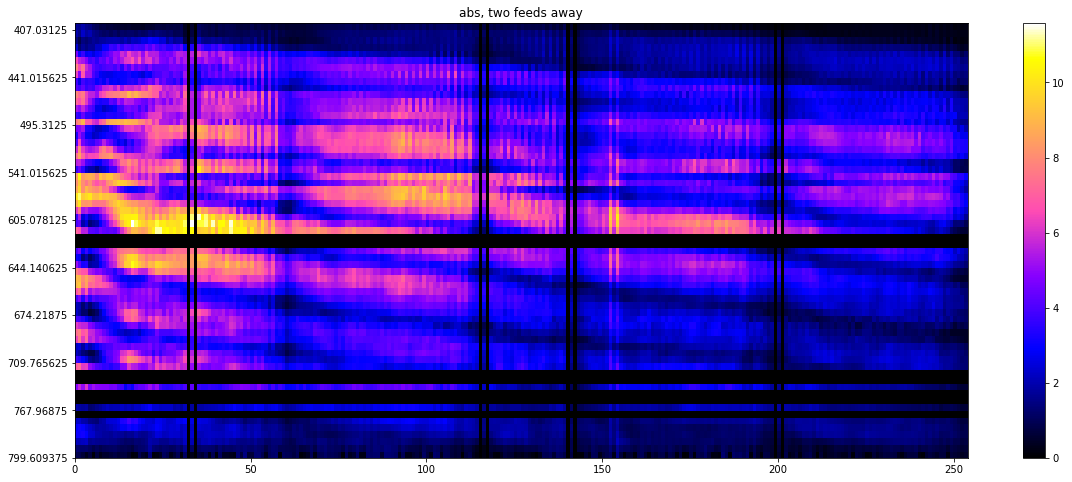

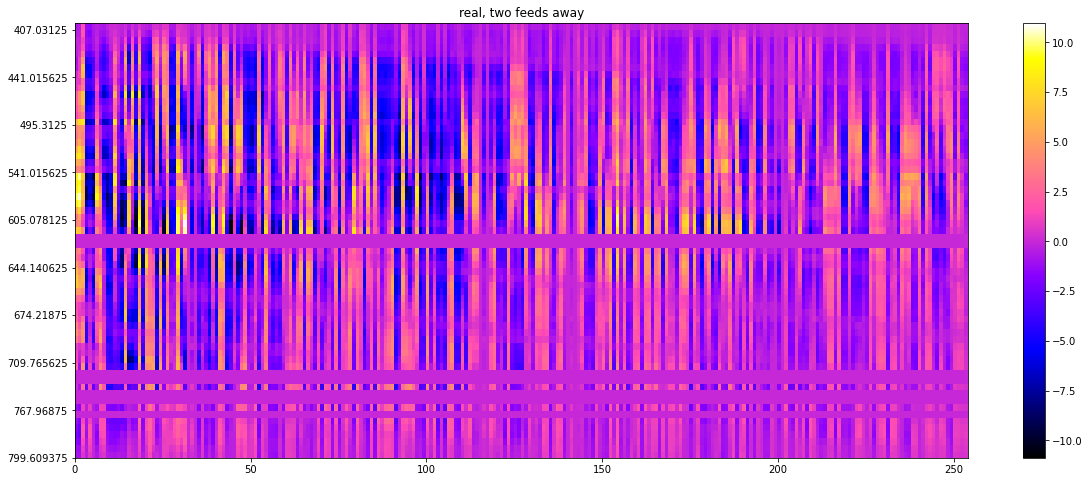

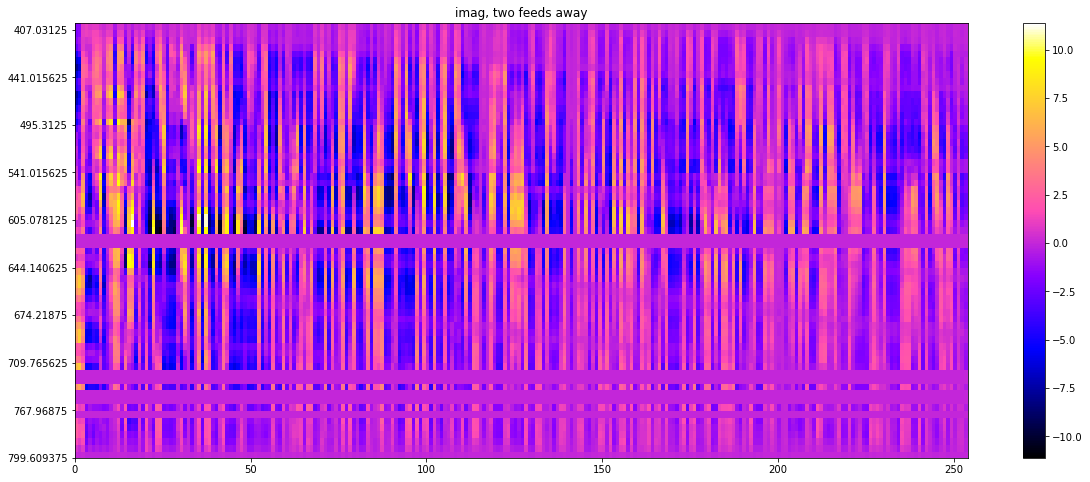

In [12]:
## Plots for the second diagonal

plt.pcolormesh(np.arctan2(np.imag(np.transpose(vis[peakInd,:,twoAway])), np.real(np.transpose(vis[peakInd,:,twoAway]))), cmap='gnuplot2')
plt.rcParams["figure.figsize"] = (20,8)
plt.title('angle, two feeds away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakInd,:,twoAway])), cmap='gnuplot2')
plt.rcParams["figure.figsize"] = (20,8)
plt.title('abs, two feeds away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.real(np.transpose(vis[peakInd,:,twoAway])), cmap='gnuplot2')
plt.rcParams["figure.figsize"] = (20,8)
plt.title('real, two feeds away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.imag(np.transpose(vis[peakInd,:,twoAway])), cmap='gnuplot2')
plt.rcParams["figure.figsize"] = (20,8)
plt.title('imag, two feeds away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

In [14]:
## Third set of diagonals

threeAway = np.array([], dtype=int)

for i in range(256,-1,-1):
    index = 256*(256-1)//2 - i* (i-1)//2 +2 
    if index >= len(XXpols):
        break
    threeAway = np.append(threeAway, XXpols[index])
    print(f"Index: {index}, Length of XXpols: {len(XXpols)}")

Index: 2, Length of XXpols: 32640
Index: 257, Length of XXpols: 32640
Index: 511, Length of XXpols: 32640
Index: 764, Length of XXpols: 32640
Index: 1016, Length of XXpols: 32640
Index: 1267, Length of XXpols: 32640
Index: 1517, Length of XXpols: 32640
Index: 1766, Length of XXpols: 32640
Index: 2014, Length of XXpols: 32640
Index: 2261, Length of XXpols: 32640
Index: 2507, Length of XXpols: 32640
Index: 2752, Length of XXpols: 32640
Index: 2996, Length of XXpols: 32640
Index: 3239, Length of XXpols: 32640
Index: 3481, Length of XXpols: 32640
Index: 3722, Length of XXpols: 32640
Index: 3962, Length of XXpols: 32640
Index: 4201, Length of XXpols: 32640
Index: 4439, Length of XXpols: 32640
Index: 4676, Length of XXpols: 32640
Index: 4912, Length of XXpols: 32640
Index: 5147, Length of XXpols: 32640
Index: 5381, Length of XXpols: 32640
Index: 5614, Length of XXpols: 32640
Index: 5846, Length of XXpols: 32640
Index: 6077, Length of XXpols: 32640
Index: 6307, Length of XXpols: 32640
Index: 

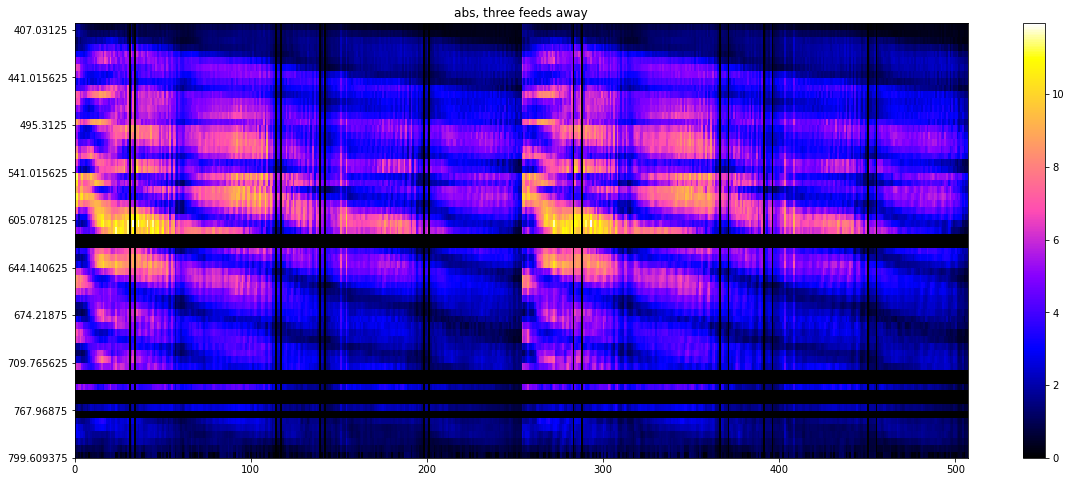

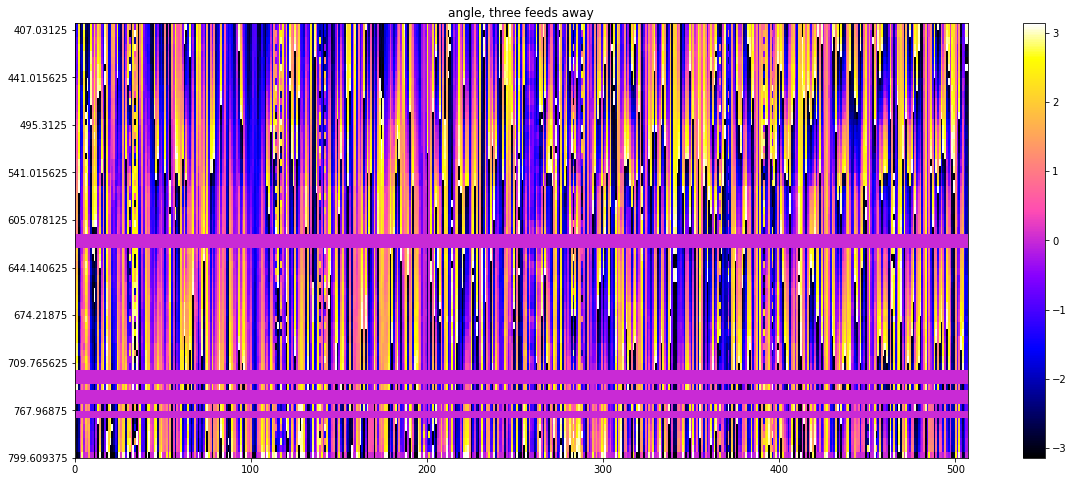

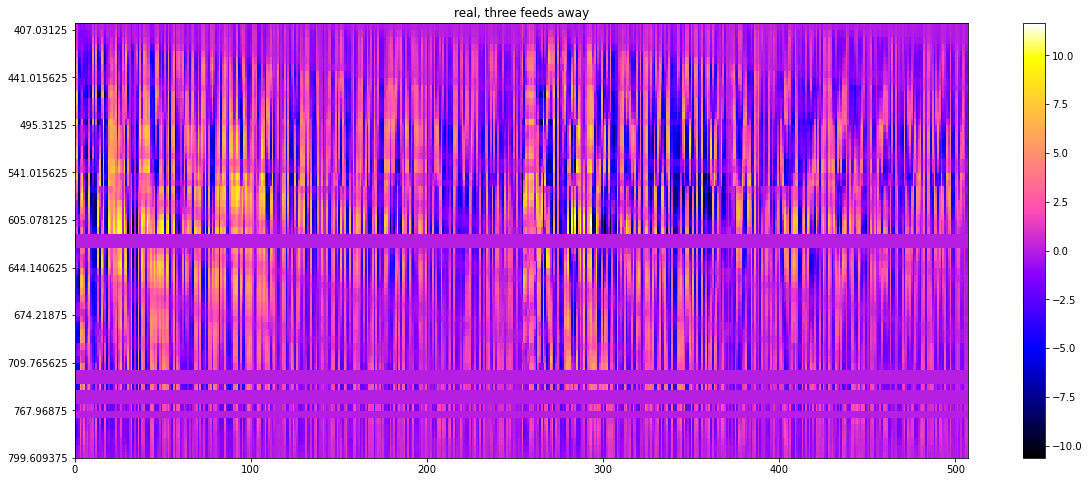

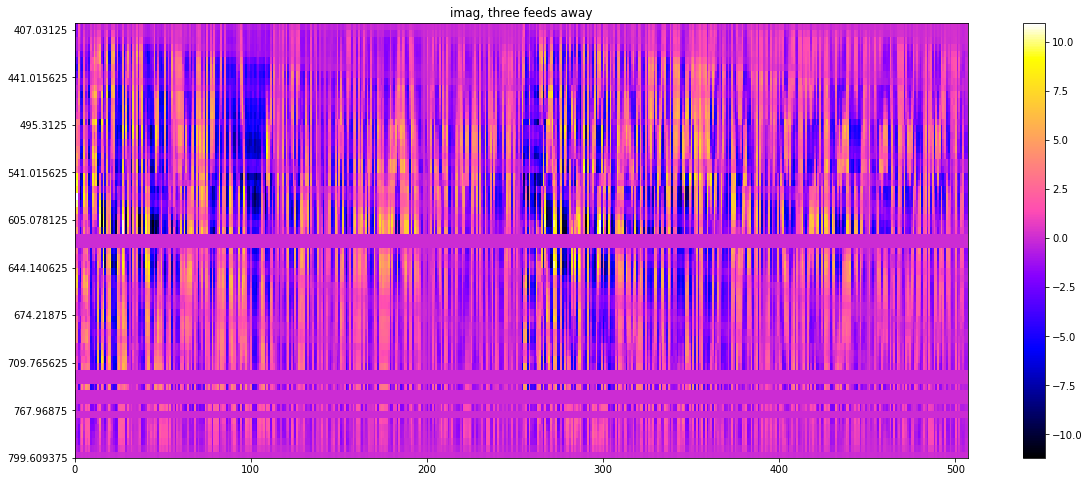

In [53]:
## Plots for the third diagonal

peakInd = 198

plt.pcolormesh(np.abs(np.transpose(vis[peakInd,:,threeAway])),cmap='gnuplot2')
plt.title('abs, three feeds away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.angle(np.transpose(vis[peakInd,:,threeAway])),cmap='gnuplot2')
plt.title('angle, three feeds away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.real(np.transpose(vis[peakInd,:,threeAway])),cmap='gnuplot2')
plt.title('real, three feeds away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.imag(np.transpose(vis[peakInd,:,threeAway])),cmap='gnuplot2')
plt.title('imag, three feeds away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

In [25]:
print(vis[peakInd,:,oneAway].shape)
print(freqList[44])

(255, 64)
525.0


"\nplt.figure(figsize=(20,7))\nplt.plot(np.angle(vis0[:,125]), color='lawngreen', label='index 127')\nplt.plot(np.angle(vis0[:,126]), color='green', label='index 126')\nplt.xlabel('Frequency (index no)')\nplt.ylabel('Phase (radians)')\nplt.title('Mid baseline')\nplt.legend()\n\n\nplt.figure(figsize=(20,7))\nplt.plot(np.angle(vis0[:,254]), color='cornflowerblue', label='index 254')\nplt.plot(np.angle(vis0[:,253]), color='blue', label='index 253')\nplt.xlabel('Frequency (index no)')\nplt.ylabel('Phase (radians)')\nplt.title('High baseline')\nplt.legend()\n\nplt.figure(figsize=(20,7))\nplt.plot(np.angle(vis0[:,0]), color='orange', label='index 0')\nplt.plot(np.angle(vis0[:,127]), color='lawngreen', label='index 127')\nplt.plot(np.angle(vis0[:,255]), color='blue', label='index 255')\nplt.xlabel('Frequency (index no)')\nplt.ylabel('Phase (radians)')\nplt.title('Phase at different baselines')\nplt.legend()\n"

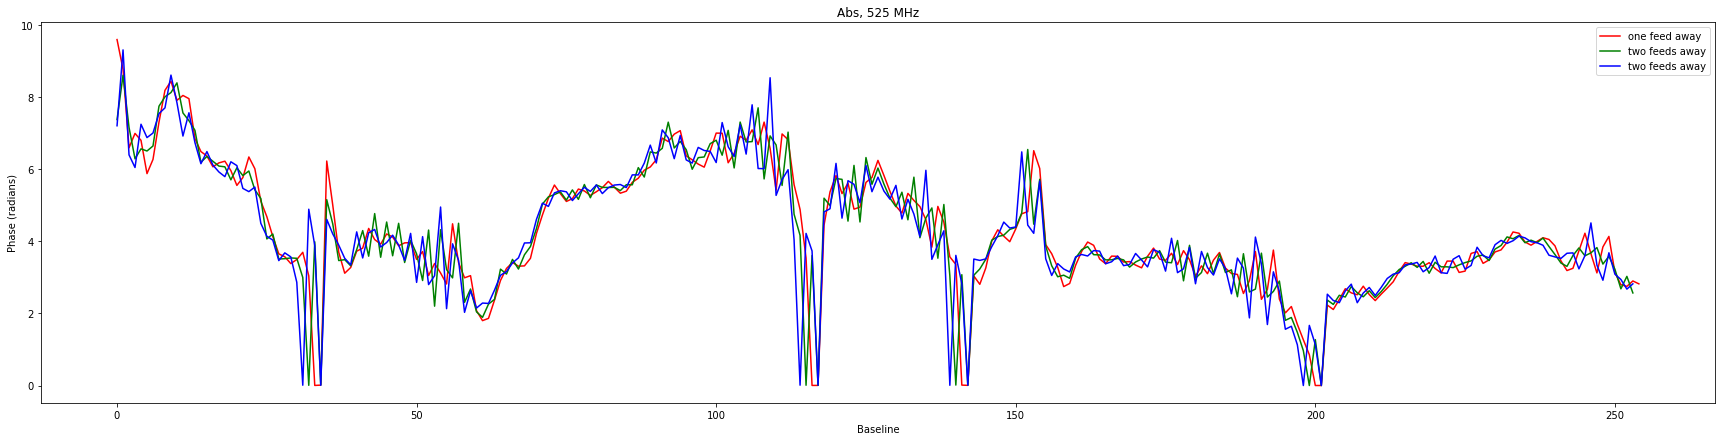

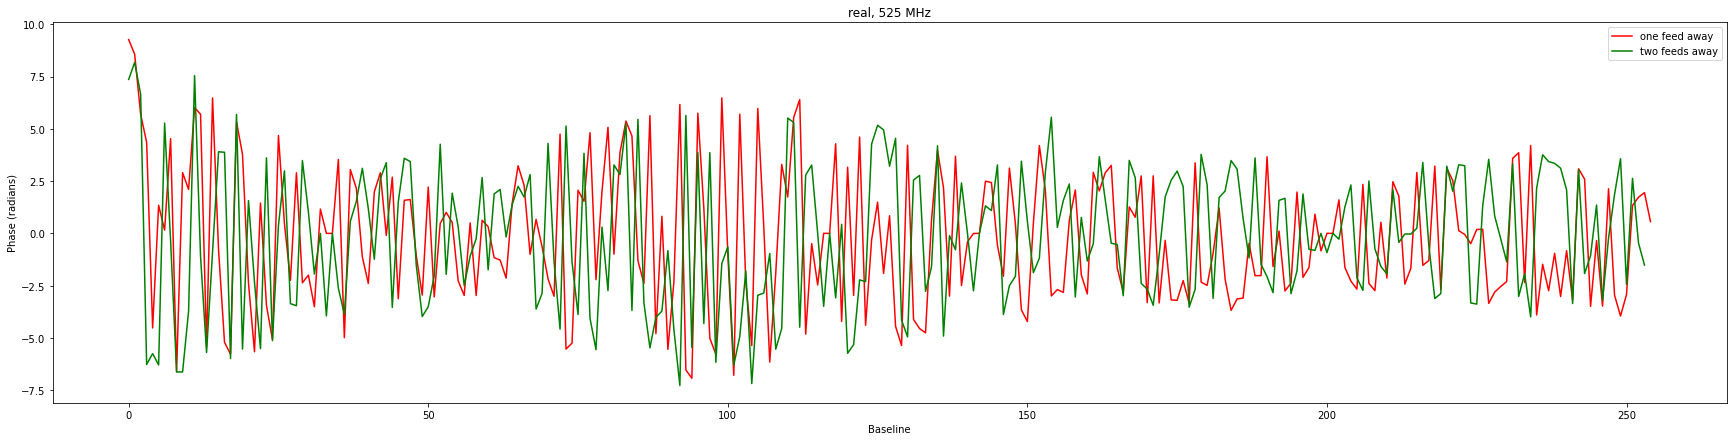

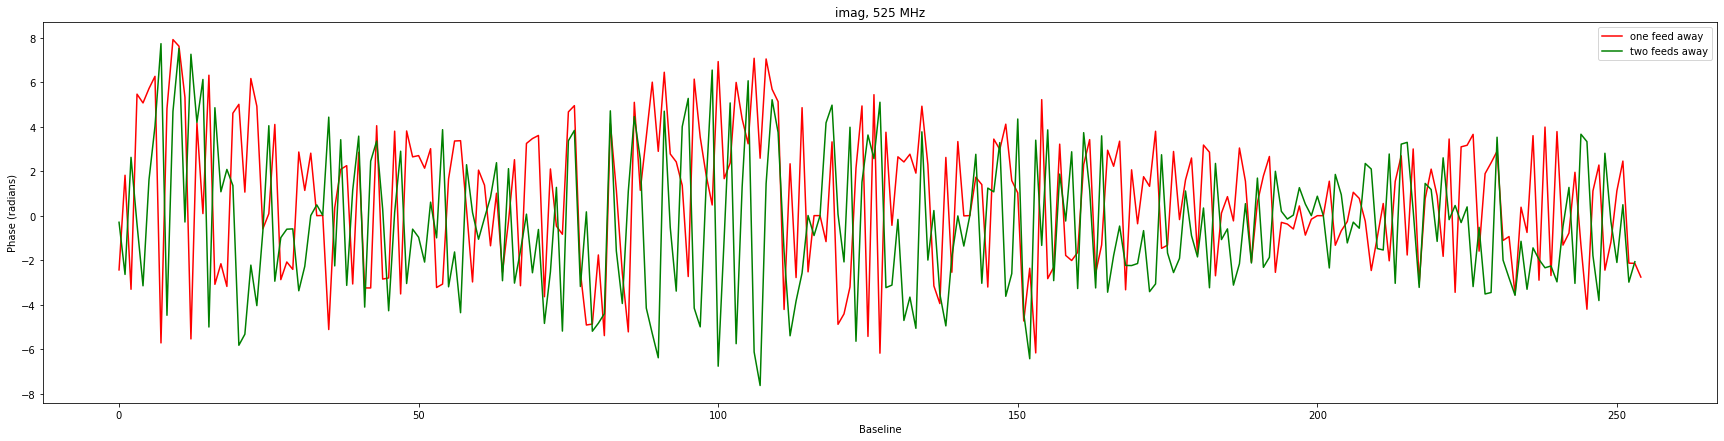

In [39]:
plt.figure(figsize=(30,7))
plt.plot(np.abs(np.transpose(vis[peakInd,44,oneAway])), color='red', label='one feed away')
plt.plot(np.abs(np.transpose(vis[peakInd,44,twoAway])), color='green', label='two feeds away')
plt.plot(np.abs(np.transpose(vis[peakInd,44,threeAway])), color='blue', label='two feeds away')
plt.xlabel('Baseline')
plt.ylabel('Phase (radians)')
plt.title('Abs, 525 MHz')
plt.legend()

'''
plt.figure(figsize=(30,7))
plt.plot(np.real(np.transpose(vis[peakInd,44,oneAway])), color='red', label='one feed away')
plt.plot(np.real(np.transpose(vis[peakInd,44,twoAway])), color='green', label='two feeds away')
#plt.plot(np.real(np.transpose(vis[peakInd,44,threeAway])), color='blue', label='two feeds away')
plt.xlabel('Baseline')
plt.ylabel('Phase (radians)')
plt.title('real, 525 MHz')
plt.legend()

plt.figure(figsize=(30,7))
plt.plot(np.imag(np.transpose(vis[peakInd,44,oneAway])), color='red', label='one feed away')
plt.plot(np.imag(np.transpose(vis[peakInd,44,twoAway])), color='green', label='two feeds away')
#plt.plot(np.imag(np.transpose(vis[peakInd,44,threeAway])), color='blue', label='two feeds away')
plt.xlabel('Baseline')
plt.ylabel('Phase (radians)')
plt.title('imag, 525 MHz')
plt.legend()

plt.figure(figsize=(20,7))
plt.plot(np.angle(vis0[:,125]), color='lawngreen', label='index 127')
plt.plot(np.angle(vis0[:,126]), color='green', label='index 126')
plt.xlabel('Frequency (index no)')
plt.ylabel('Phase (radians)')
plt.title('Mid baseline')
plt.legend()


plt.figure(figsize=(20,7))
plt.plot(np.angle(vis0[:,254]), color='cornflowerblue', label='index 254')
plt.plot(np.angle(vis0[:,253]), color='blue', label='index 253')
plt.xlabel('Frequency (index no)')
plt.ylabel('Phase (radians)')
plt.title('High baseline')
plt.legend()

plt.figure(figsize=(20,7))
plt.plot(np.angle(vis0[:,0]), color='orange', label='index 0')
plt.plot(np.angle(vis0[:,127]), color='lawngreen', label='index 127')
plt.plot(np.angle(vis0[:,255]), color='blue', label='index 255')
plt.xlabel('Frequency (index no)')
plt.ylabel('Phase (radians)')
plt.title('Phase at different baselines')
plt.legend()
'''

In [39]:
## 255th set of diagonals

furthestAway = np.array([], dtype=int)

for i in range(256,-1,-1):
    index = 256*(256-1)//2 - i* (i-1)//2 +254
    if index >= len(XXpols):
        break
    furthestAway = np.append(furthestAway, XXpols[index])
    print(f"Index: {index}, Length of XXpols: {len(XXpols)}")

Index: 254, Length of XXpols: 32640
Index: 509, Length of XXpols: 32640
Index: 763, Length of XXpols: 32640
Index: 1016, Length of XXpols: 32640
Index: 1268, Length of XXpols: 32640
Index: 1519, Length of XXpols: 32640
Index: 1769, Length of XXpols: 32640
Index: 2018, Length of XXpols: 32640
Index: 2266, Length of XXpols: 32640
Index: 2513, Length of XXpols: 32640
Index: 2759, Length of XXpols: 32640
Index: 3004, Length of XXpols: 32640
Index: 3248, Length of XXpols: 32640
Index: 3491, Length of XXpols: 32640
Index: 3733, Length of XXpols: 32640
Index: 3974, Length of XXpols: 32640
Index: 4214, Length of XXpols: 32640
Index: 4453, Length of XXpols: 32640
Index: 4691, Length of XXpols: 32640
Index: 4928, Length of XXpols: 32640
Index: 5164, Length of XXpols: 32640
Index: 5399, Length of XXpols: 32640
Index: 5633, Length of XXpols: 32640
Index: 5866, Length of XXpols: 32640
Index: 6098, Length of XXpols: 32640
Index: 6329, Length of XXpols: 32640
Index: 6559, Length of XXpols: 32640
Inde

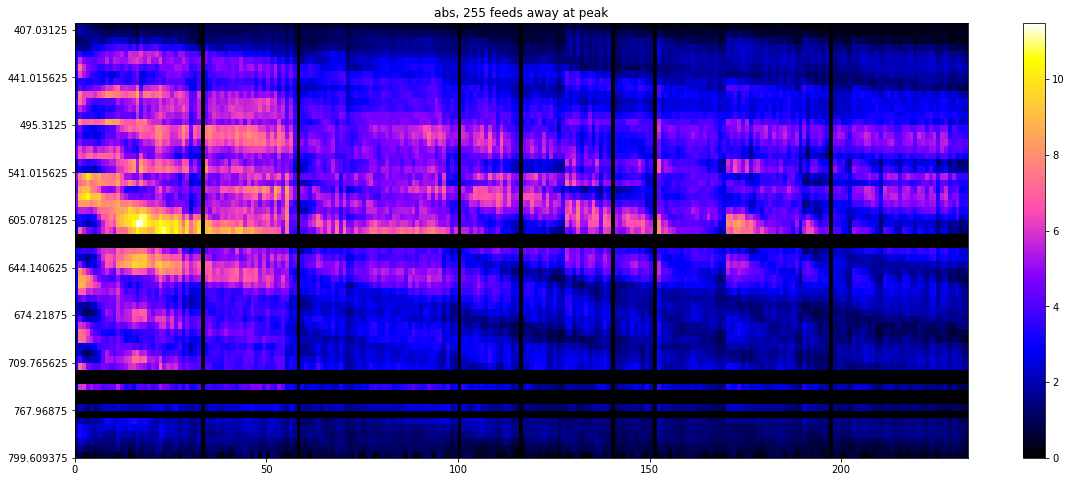

In [40]:
# Plots from peak

plt.pcolormesh(np.abs(np.transpose(vis[peakInd,:,furthestAway])),cmap='gnuplot2')
plt.title('abs, 255 feeds away at peak')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

In [9]:
## Set of diagonal entry numbers to call the data later

fiveAway = np.array([], dtype=int)

for i in range(256,-1,-1):
    index = 256*(256-1)//2 - i* (i-1)//2 + 4 #add n-1 to shift to the right to the nth diagonal
    if index >= len(XXpols):
        break
    fiveAway = np.append(fiveAway, XXpols[index])
    #print(f"Index: {index}")
    
tenAway = np.array([], dtype=int)

for i in range(256,-1,-1):
    index = 256*(256-1)//2 - i* (i-1)//2 + 9 #add n-1 to shift to the right to the nth diagonal 
    if index >= len(XXpols):
        break
    tenAway = np.append(tenAway, XXpols[index])
    #print(f"Index: {index}")
    
twentyAway = np.array([], dtype=int)

for i in range(256,-1,-1):
    index = 256*(256-1)//2 - i* (i-1)//2 + 19 
    if index >= len(XXpols):
        break
    twentyAway = np.append(twentyAway, XXpols[index])
    #print(f"Index: {index}")

fourtyAway = np.array([], dtype=int)

for i in range(256,-1,-1):
    index = 256*(256-1)//2 - i* (i-1)//2 + 39 
    if index >= len(XXpols):
        break
    fourtyAway = np.append(fourtyAway, XXpols[index])
    #print(f"Index: {index}")

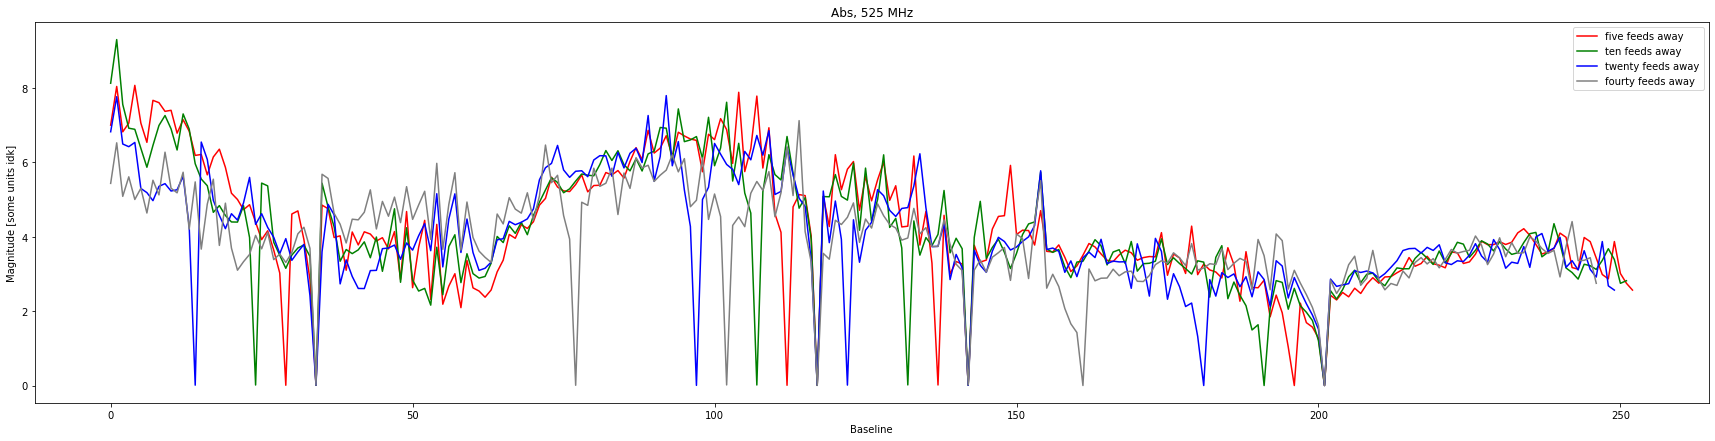

In [50]:
plt.figure(figsize=(30,7))
plt.plot(np.abs(np.transpose(vis[peakInd,44,fiveAway])), color='red', label='five feeds away')
plt.plot(np.abs(np.transpose(vis[peakInd,44,tenAway])), color='green', label='ten feeds away')
plt.plot(np.abs(np.transpose(vis[peakInd,44,twentyAway])), color='blue', label='twenty feeds away')
plt.plot(np.abs(np.transpose(vis[peakInd,44,fourtyAway])), color='gray', label='fourty feeds away')
plt.xlabel('Baseline')
plt.ylabel('Magnitude [some units idk]')
plt.title('Abs, 525 MHz')
plt.legend()

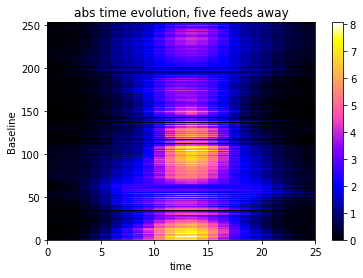

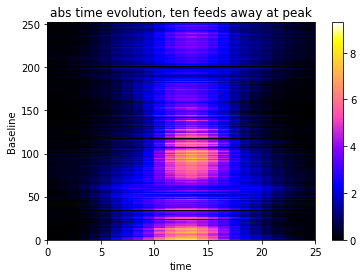

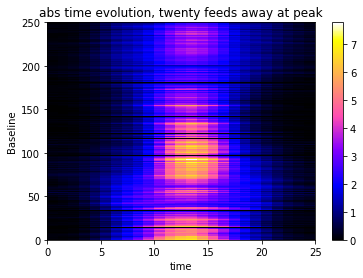

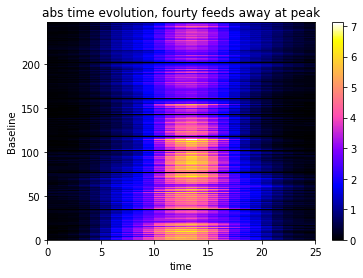

In [21]:
# Plots with time as an axis, for 525 MHz

## Abs
plt.pcolormesh(np.abs(np.transpose(vis[185:210,44,fiveAway])),cmap='gnuplot2')
plt.title('abs time evolution, five feeds away')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[185:210,44,tenAway])),cmap='gnuplot2')
plt.title('abs time evolution, ten feeds away at peak')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[185:210,44,twentyAway])),cmap='gnuplot2')
plt.title('abs time evolution, twenty feeds away at peak')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[185:210,44,fourtyAway])),cmap='gnuplot2')
plt.title('abs time evolution, fourty feeds away at peak')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

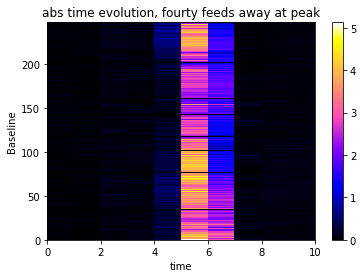

In [65]:
plt.pcolormesh(np.abs(np.transpose(vis[125:135,44,fourtyAway])),cmap='gnuplot2')
plt.title('abs time evolution, fourty feeds away at peak')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

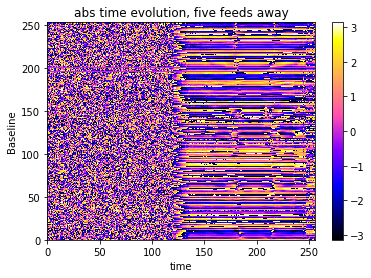

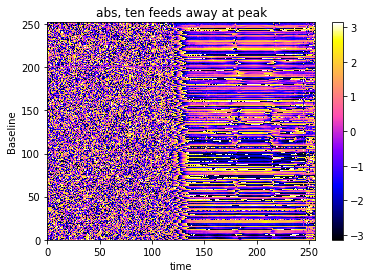

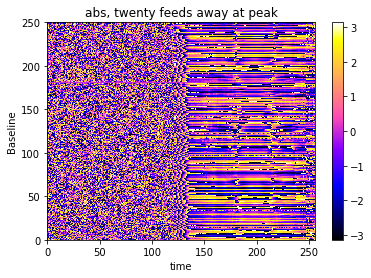

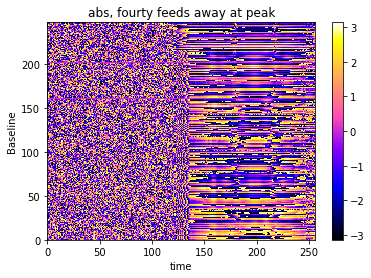

In [20]:
# Plots with time as an axis, for 525 MHz

## Angle
plt.pcolormesh(np.angle(np.transpose(vis[:,44,fiveAway])),cmap='gnuplot2')
plt.title('phase time evolution, five feeds away')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

plt.pcolormesh(np.angle(np.transpose(vis[:,44,tenAway])),cmap='gnuplot2')
plt.title('phase time evolution, ten feeds away at peak')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

plt.pcolormesh(np.angle(np.transpose(vis[:,44,twentyAway])),cmap='gnuplot2')
plt.title('phase time evolution, twenty feeds away at peak')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

plt.pcolormesh(np.angle(np.transpose(vis[:,44,fourtyAway])),cmap='gnuplot2')
plt.title('phase time evolution, fourty feeds away at peak')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

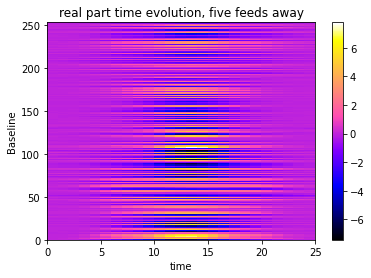

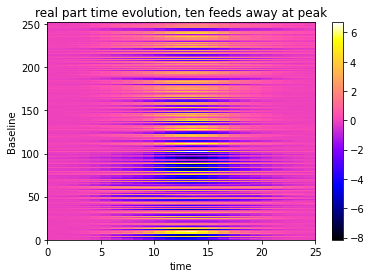

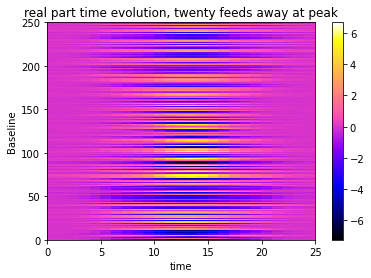

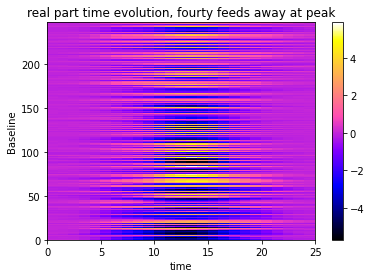

In [23]:
# Plots with time as an axis, for 525 MHz

## Real
plt.pcolormesh(np.real(np.transpose(vis[185:210,44,fiveAway])),cmap='gnuplot2')
plt.title('real part time evolution, five feeds away')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

plt.pcolormesh(np.real(np.transpose(vis[185:210,44,tenAway])),cmap='gnuplot2')
plt.title('real part time evolution, ten feeds away at peak')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

plt.pcolormesh(np.real(np.transpose(vis[185:210,44,twentyAway])),cmap='gnuplot2')
plt.title('real part time evolution, twenty feeds away at peak')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

plt.pcolormesh(np.real(np.transpose(vis[185:210,44,fourtyAway])),cmap='gnuplot2')
plt.title('real part time evolution, fourty feeds away at peak')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

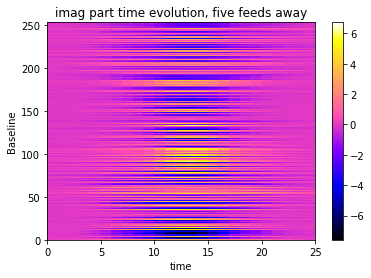

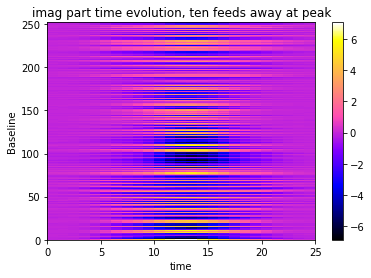

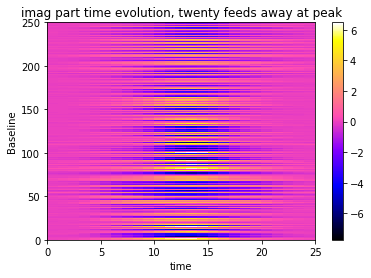

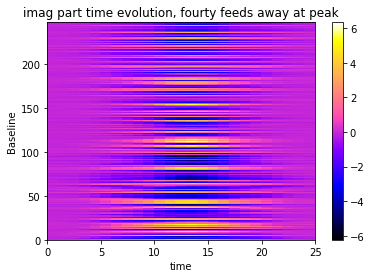

In [24]:
# Plots with time as an axis, for 525 MHz

## Imag
plt.pcolormesh(np.imag(np.transpose(vis[185:210,44,fiveAway])),cmap='gnuplot2')
plt.title('imag part time evolution, five feeds away')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

plt.pcolormesh(np.imag(np.transpose(vis[185:210,44,tenAway])),cmap='gnuplot2')
plt.title('imag part time evolution, ten feeds away at peak')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

plt.pcolormesh(np.imag(np.transpose(vis[185:210,44,twentyAway])),cmap='gnuplot2')
plt.title('imag part time evolution, twenty feeds away at peak')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

plt.pcolormesh(np.imag(np.transpose(vis[185:210,44,fourtyAway])),cmap='gnuplot2')
plt.title('imag part time evolution, fourty feeds away at peak')
plt.xlabel('time')
plt.ylabel('Baseline')
plt.colorbar()
plt.show()

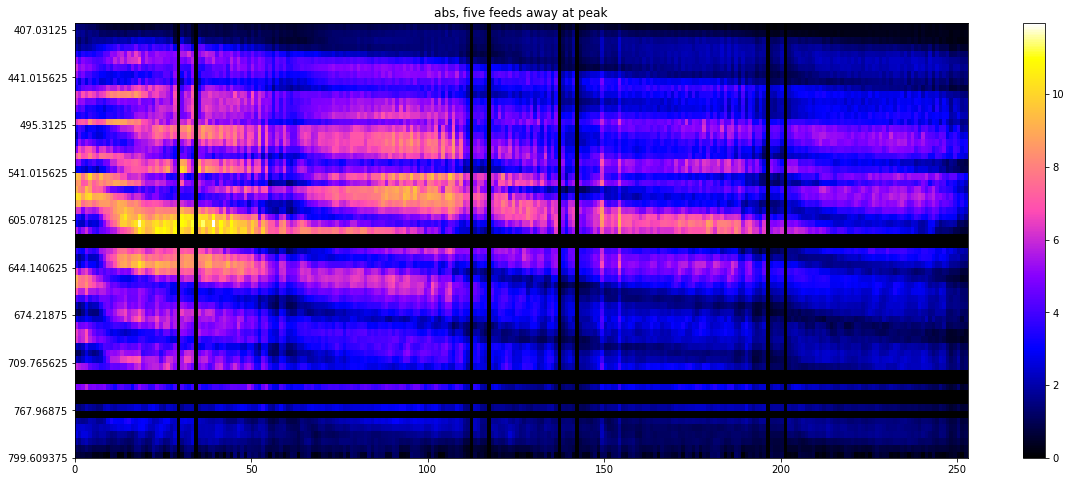

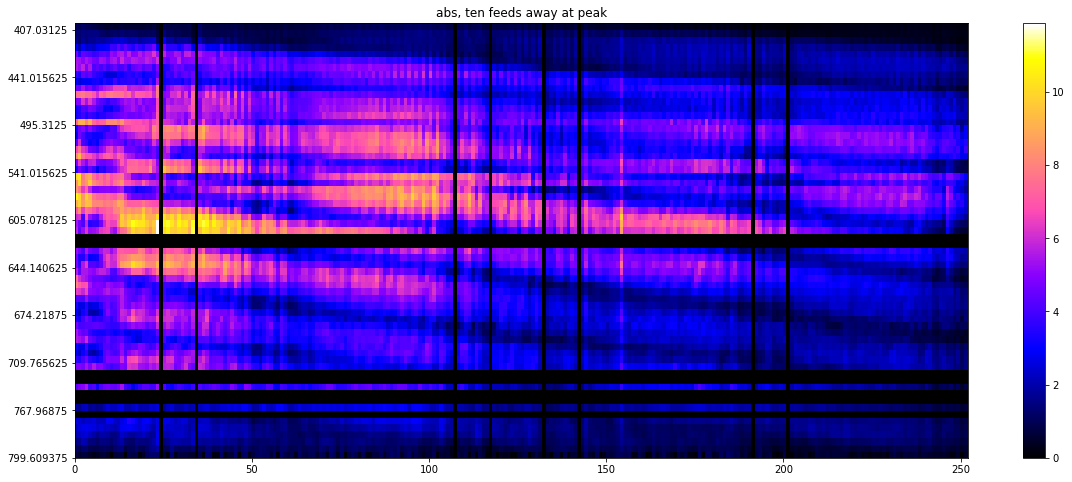

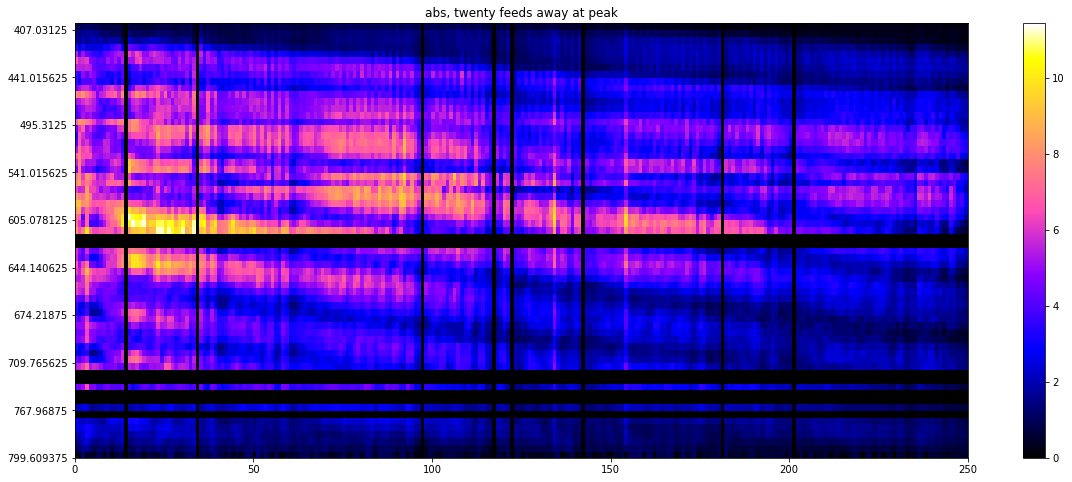

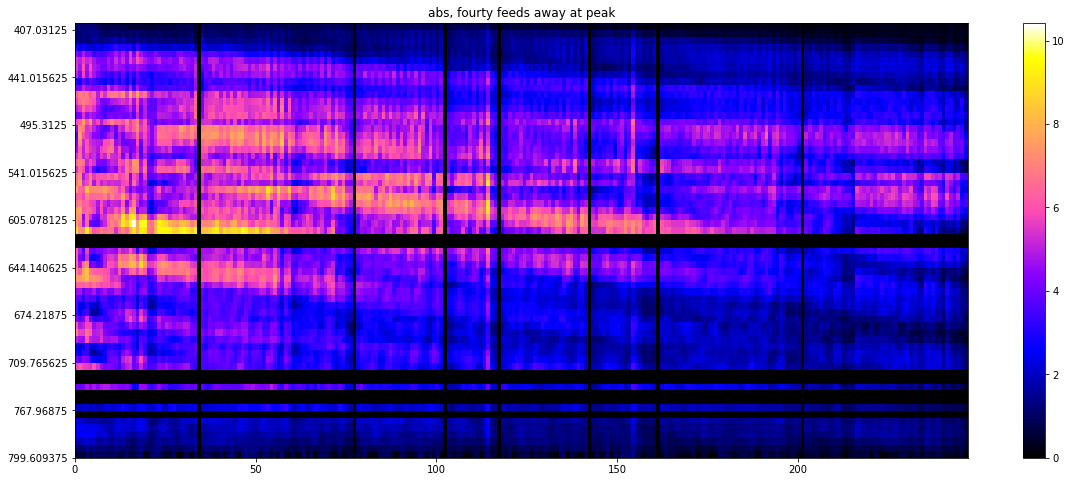

In [26]:
# Plots from peak

plt.pcolormesh(np.abs(np.transpose(vis[peakInd,:,fiveAway])),cmap='gnuplot2')
plt.title('abs, five feeds away at peak')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakInd,:,tenAway])),cmap='gnuplot2')
plt.title('abs, ten feeds away at peak')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakInd,:,twentyAway])),cmap='gnuplot2')
plt.title('abs, twenty feeds away at peak')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakInd,:,fourtyAway])),cmap='gnuplot2')
plt.title('abs, fourty feeds away at peak')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

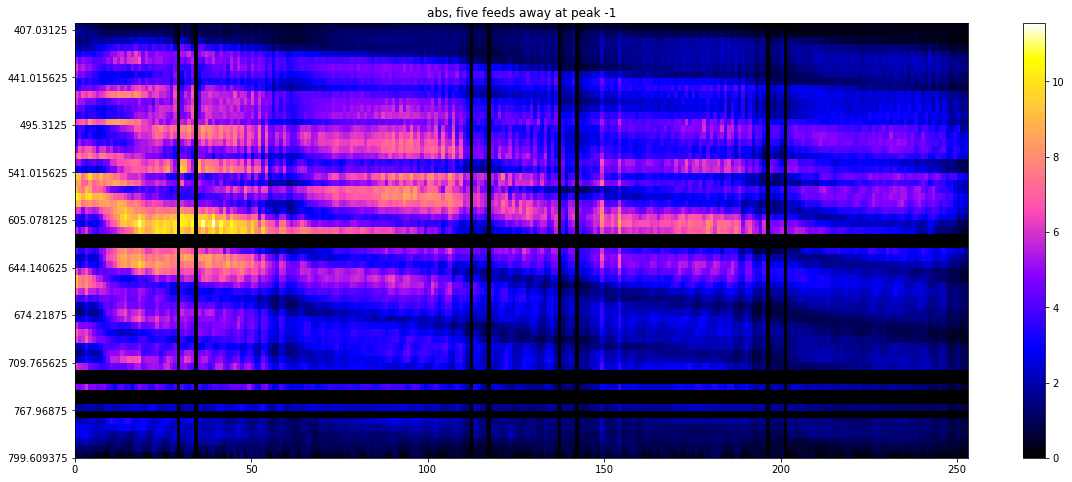

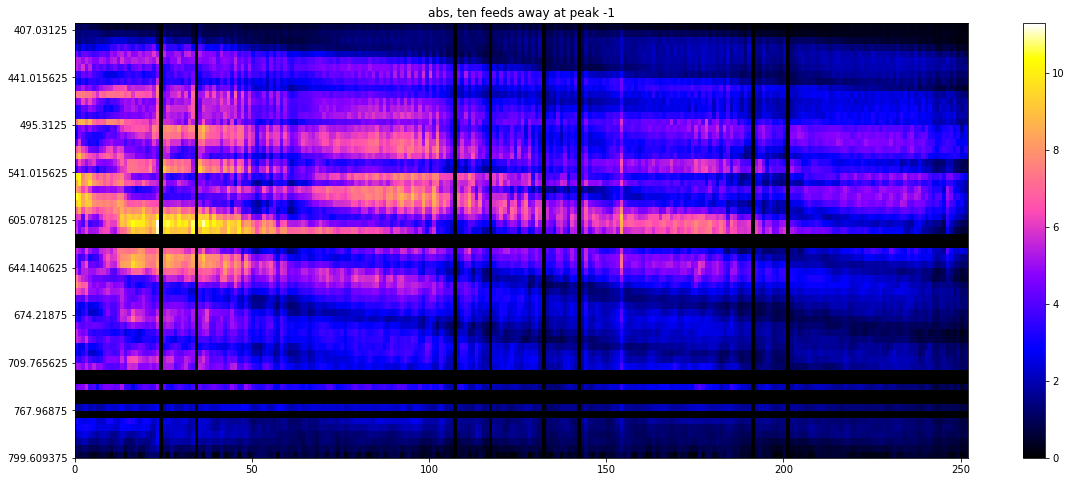

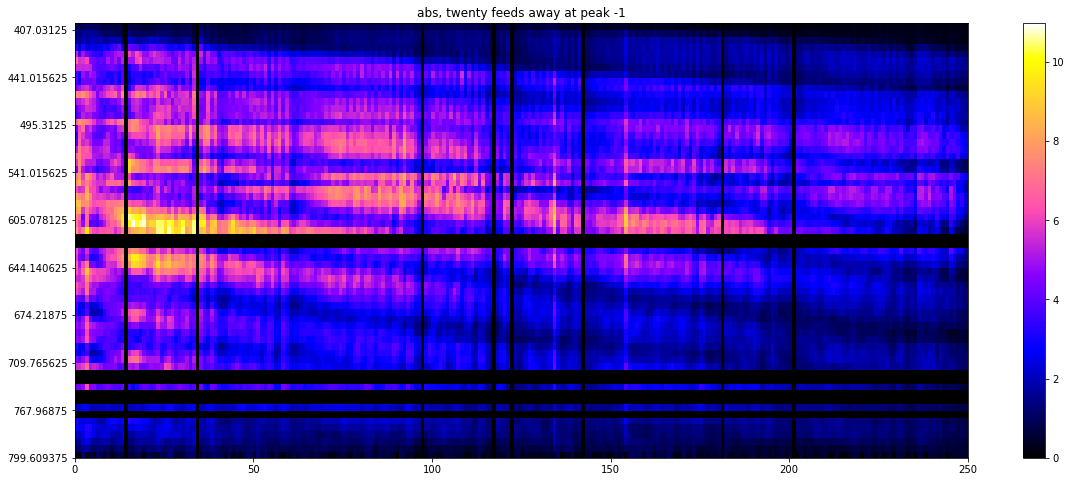

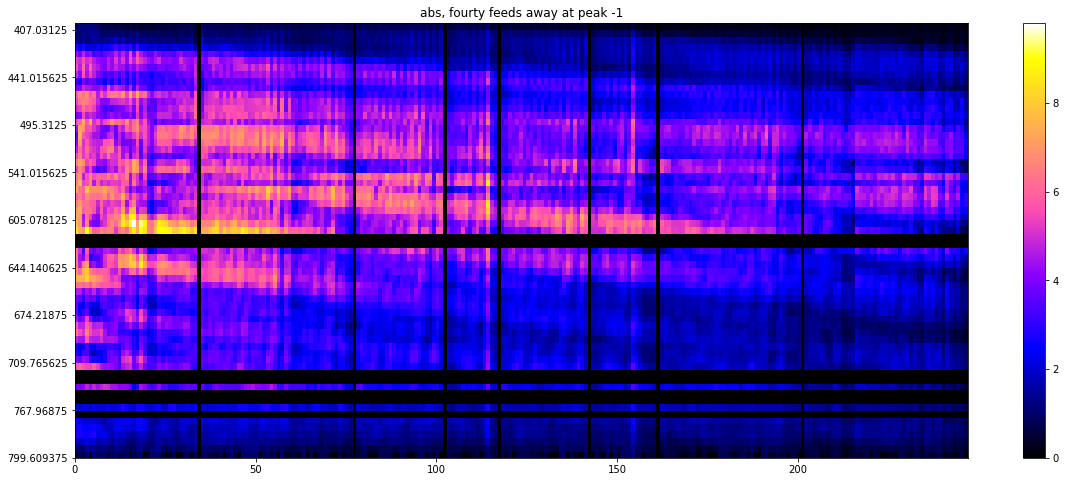

In [28]:
# Plots for peak -1

plt.pcolormesh(np.abs(np.transpose(vis[peakIndMinOne,:,fiveAway])),cmap='gnuplot2')
plt.title('abs, five feeds away at peak -1')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndMinOne,:,tenAway])),cmap='gnuplot2')
plt.title('abs, ten feeds away at peak -1')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndMinOne,:,twentyAway])),cmap='gnuplot2')
plt.title('abs, twenty feeds away at peak -1')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndMinOne,:,fourtyAway])),cmap='gnuplot2')
plt.title('abs, fourty feeds away at peak -1')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

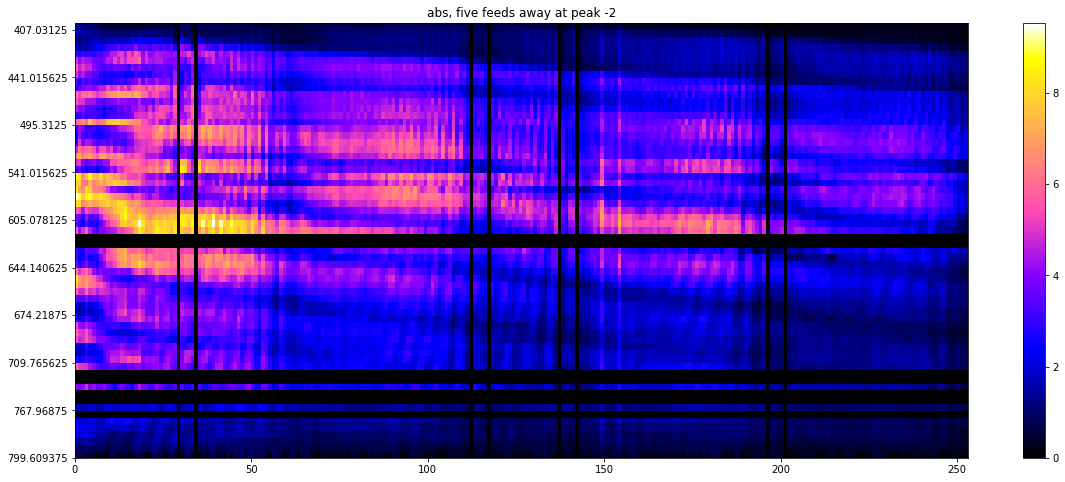

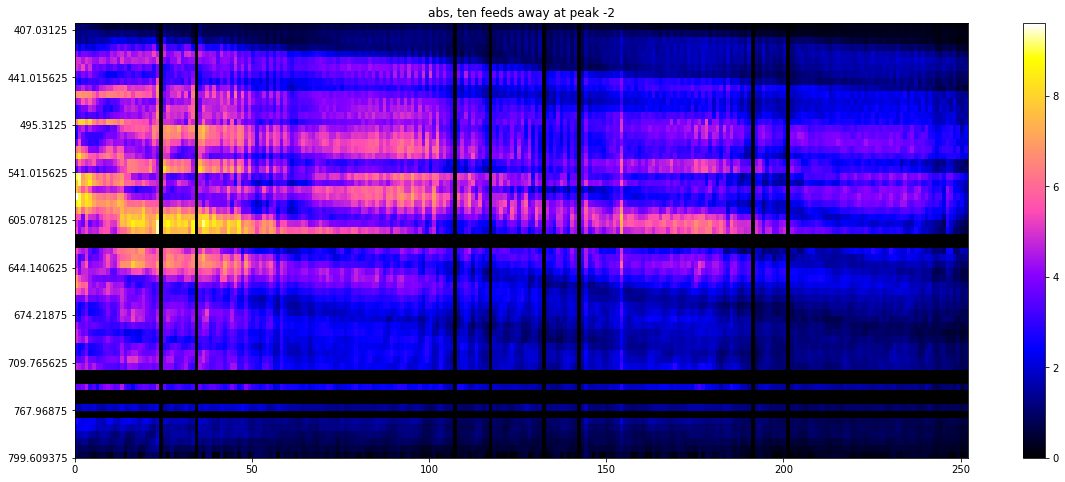

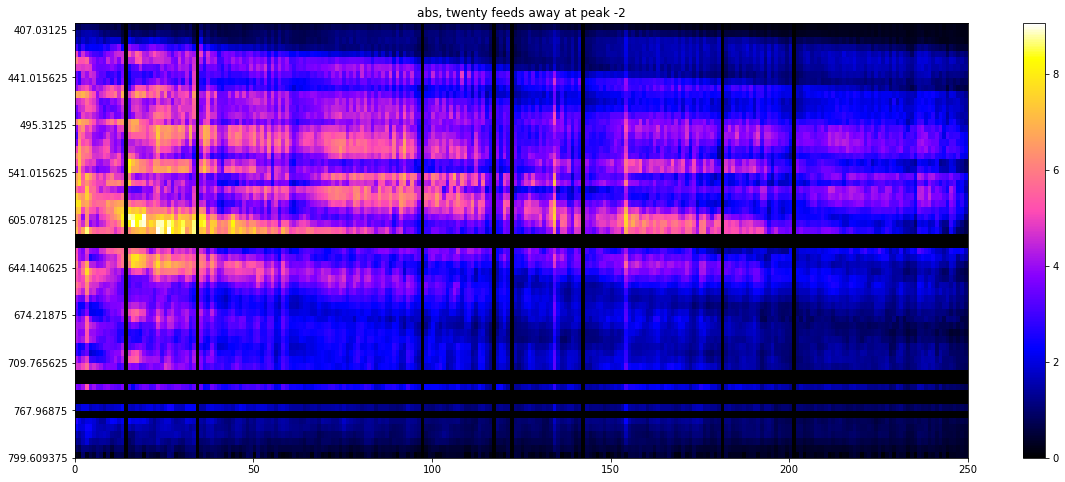

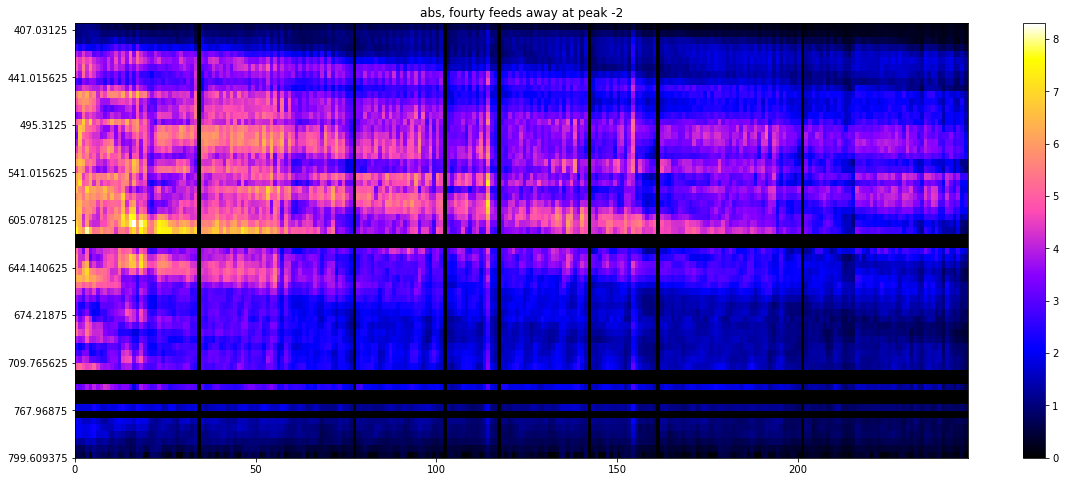

In [30]:
# Plots for peak -2

plt.pcolormesh(np.abs(np.transpose(vis[peakIndMinTwo,:,fiveAway])),cmap='gnuplot2')
plt.title('abs, five feeds away at peak -2')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndMinTwo,:,tenAway])),cmap='gnuplot2')
plt.title('abs, ten feeds away at peak -2')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndMinTwo,:,twentyAway])),cmap='gnuplot2')
plt.title('abs, twenty feeds away at peak -2')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndMinTwo,:,fourtyAway])),cmap='gnuplot2')
plt.title('abs, fourty feeds away at peak -2')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

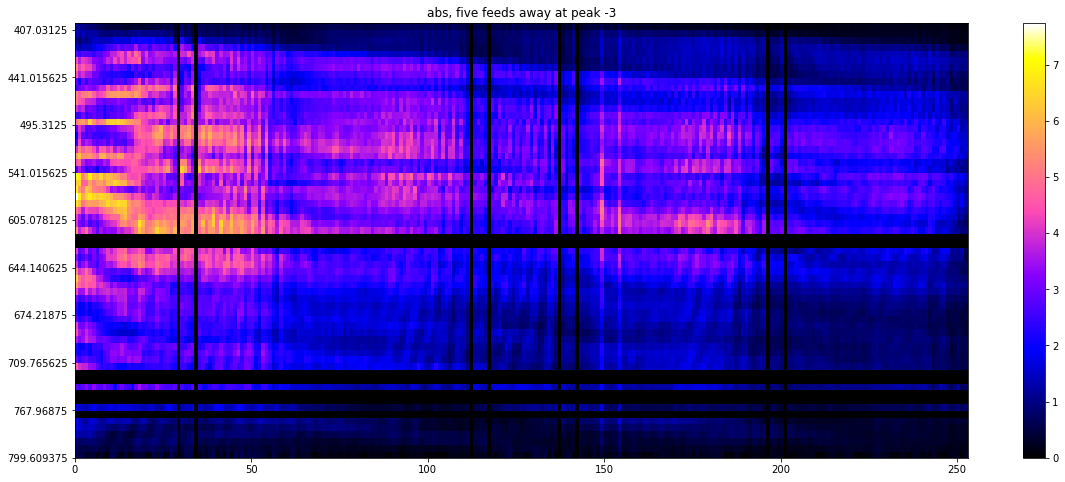

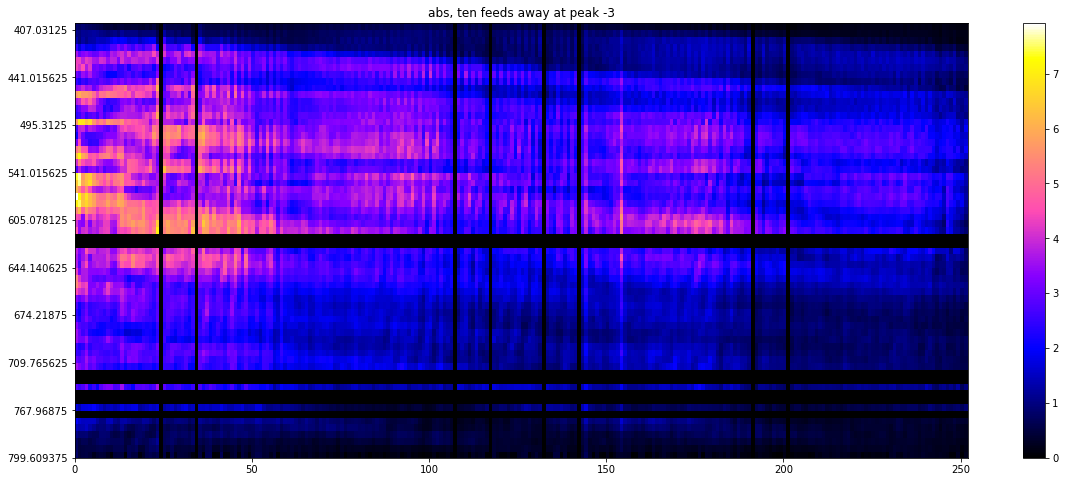

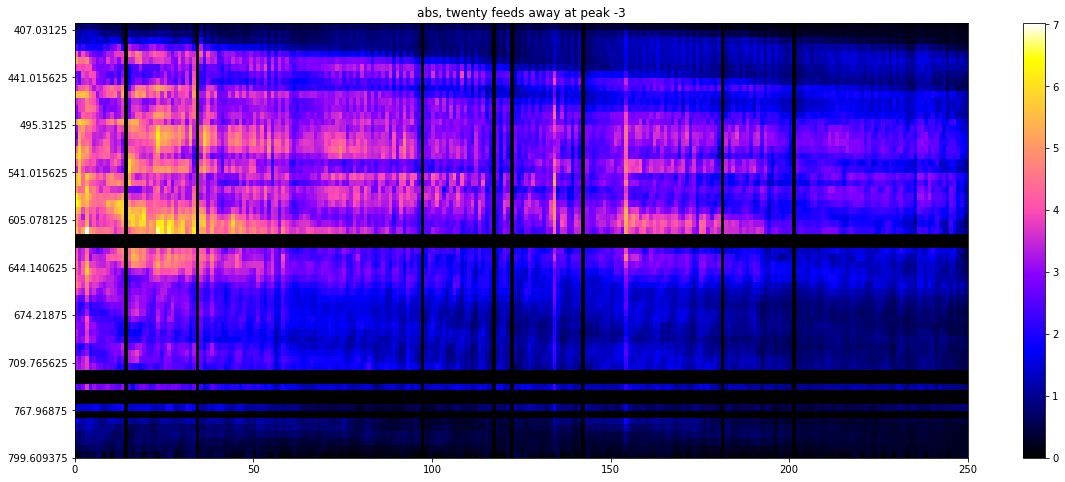

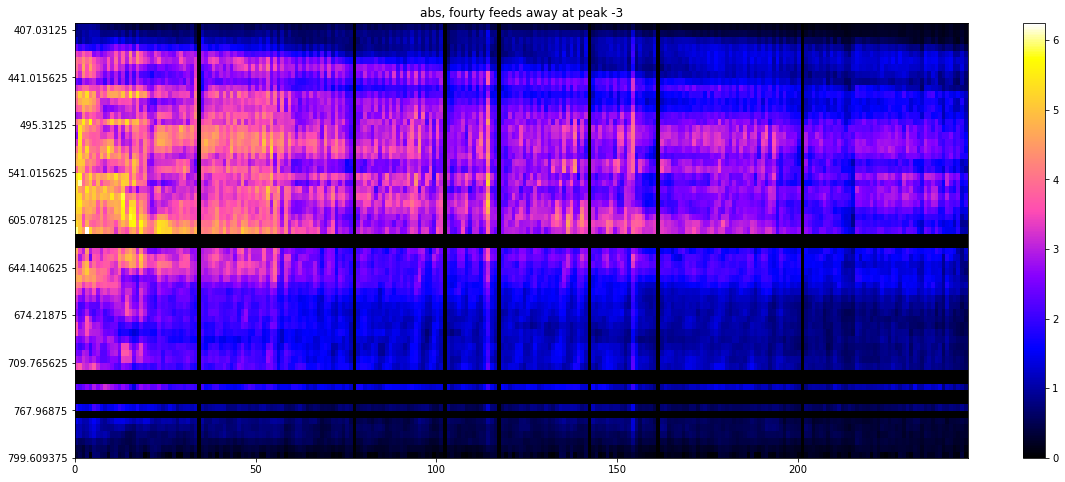

In [31]:
# Plots for peak -3

plt.pcolormesh(np.abs(np.transpose(vis[peakIndMinThree,:,fiveAway])),cmap='gnuplot2')
plt.title('abs, five feeds away at peak -3')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndMinThree,:,tenAway])),cmap='gnuplot2')
plt.title('abs, ten feeds away at peak -3')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndMinThree,:,twentyAway])),cmap='gnuplot2')
plt.title('abs, twenty feeds away at peak -3')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndMinThree,:,fourtyAway])),cmap='gnuplot2')
plt.title('abs, fourty feeds away at peak -3')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

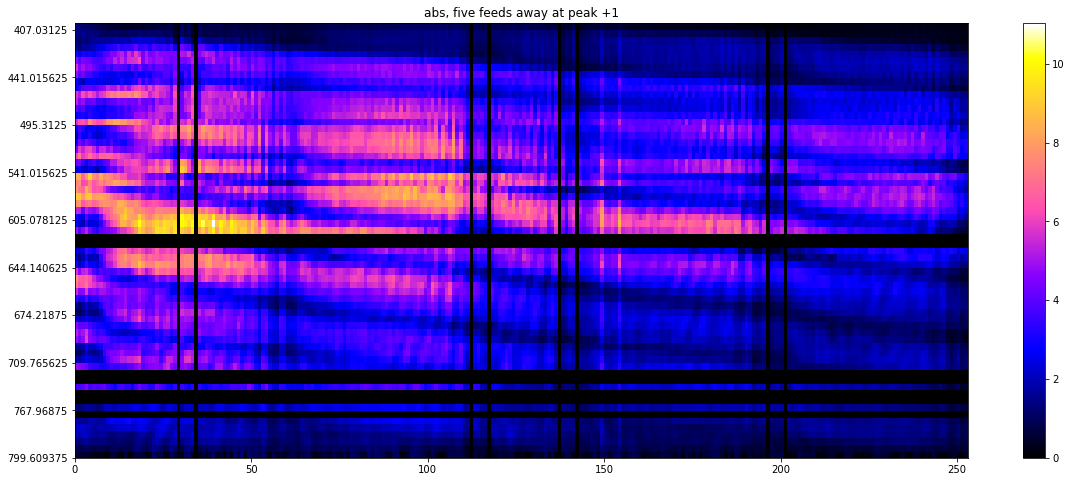

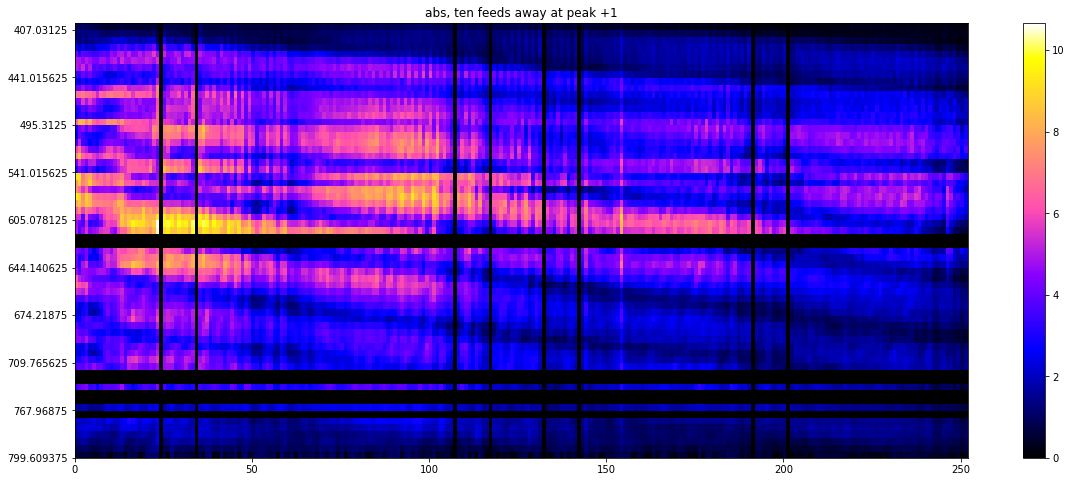

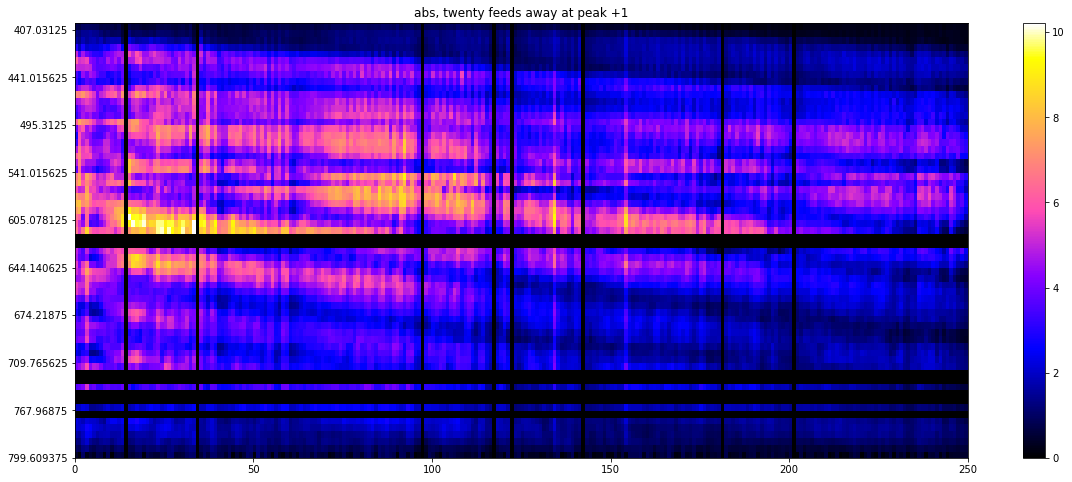

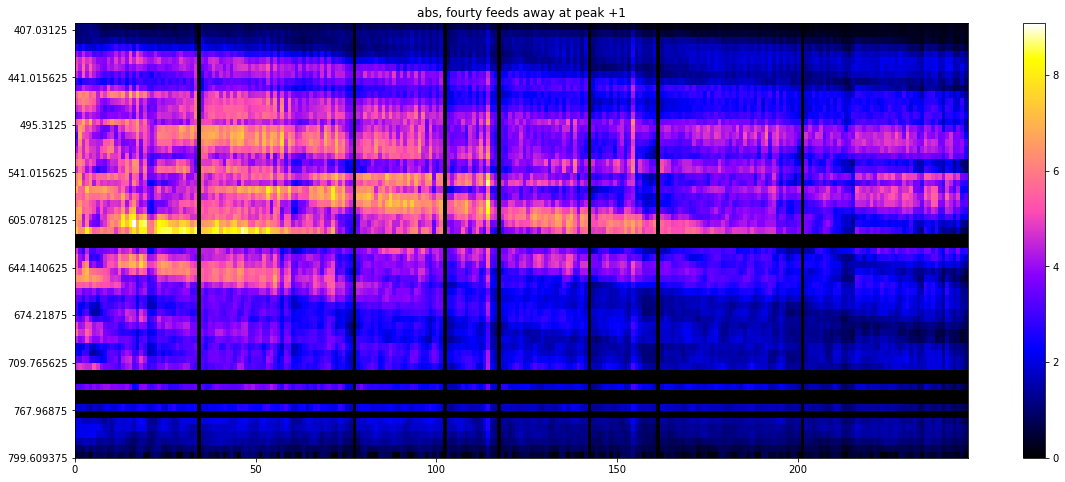

In [32]:
# Plots for peak +1

plt.pcolormesh(np.abs(np.transpose(vis[peakIndPluOne,:,fiveAway])),cmap='gnuplot2')
plt.title('abs, five feeds away at peak +1')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndPluOne,:,tenAway])),cmap='gnuplot2')
plt.title('abs, ten feeds away at peak +1')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndPluOne,:,twentyAway])),cmap='gnuplot2')
plt.title('abs, twenty feeds away at peak +1')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndPluOne,:,fourtyAway])),cmap='gnuplot2')
plt.title('abs, fourty feeds away at peak +1')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

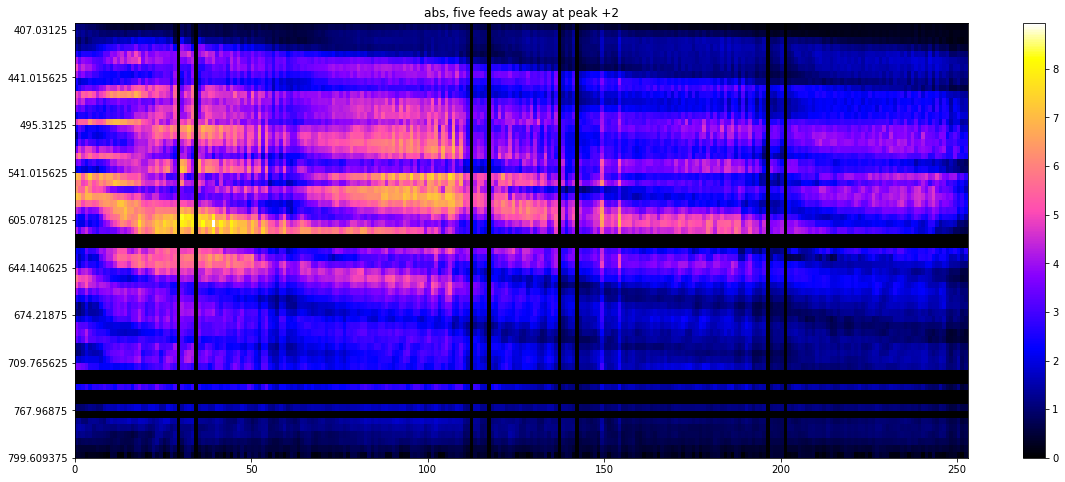

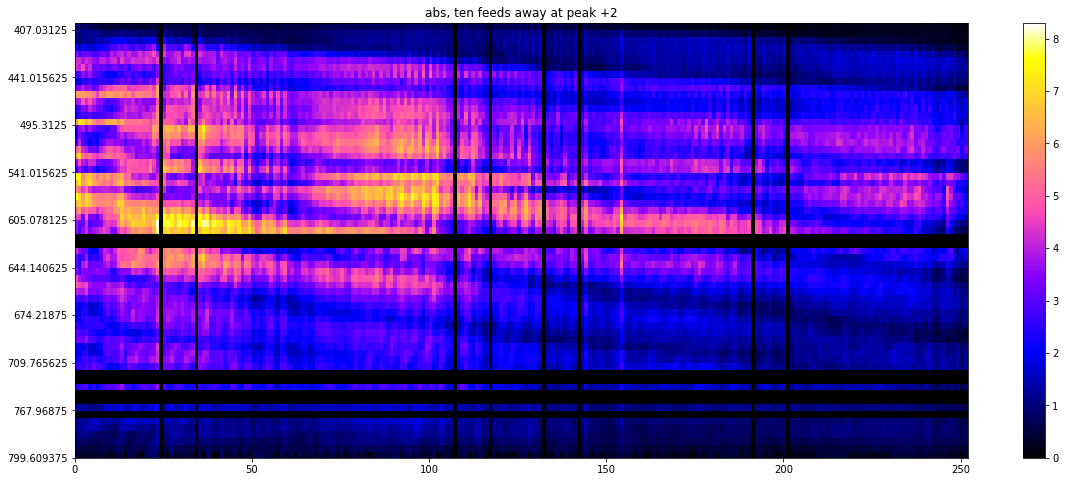

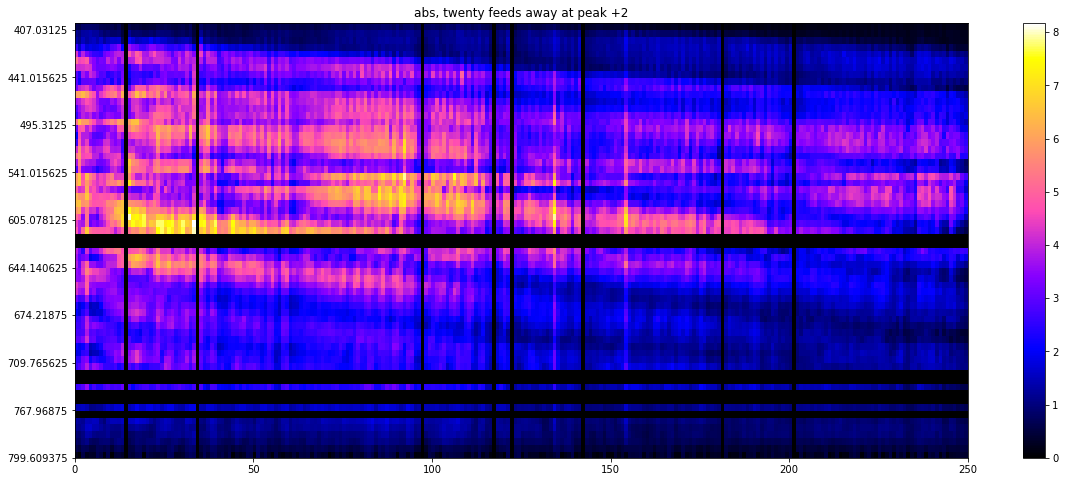

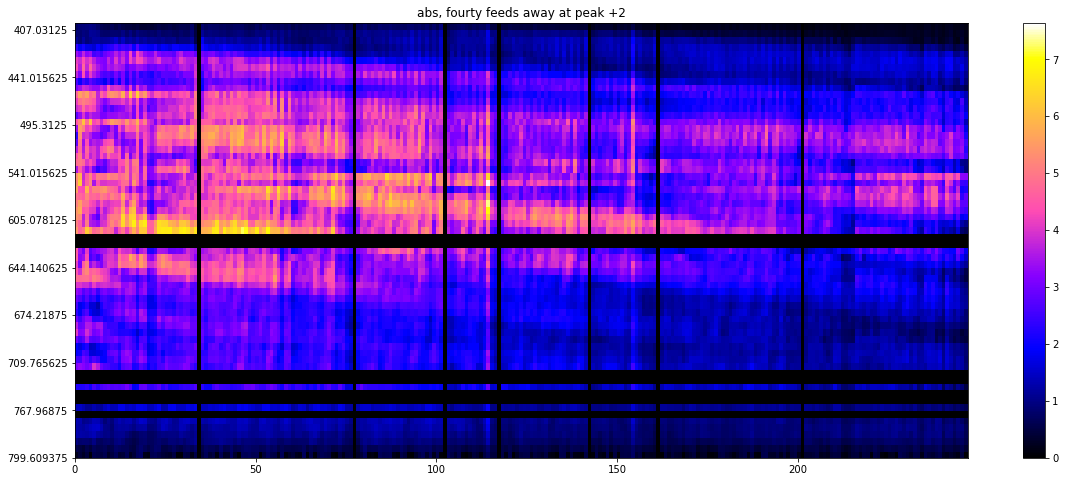

In [33]:
# Plots for peak +2

plt.pcolormesh(np.abs(np.transpose(vis[peakIndPluTwo,:,fiveAway])),cmap='gnuplot2')
plt.title('abs, five feeds away at peak +2')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndPluTwo,:,tenAway])),cmap='gnuplot2')
plt.title('abs, ten feeds away at peak +2')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndPluTwo,:,twentyAway])),cmap='gnuplot2')
plt.title('abs, twenty feeds away at peak +2')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndPluTwo,:,fourtyAway])),cmap='gnuplot2')
plt.title('abs, fourty feeds away at peak +2')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

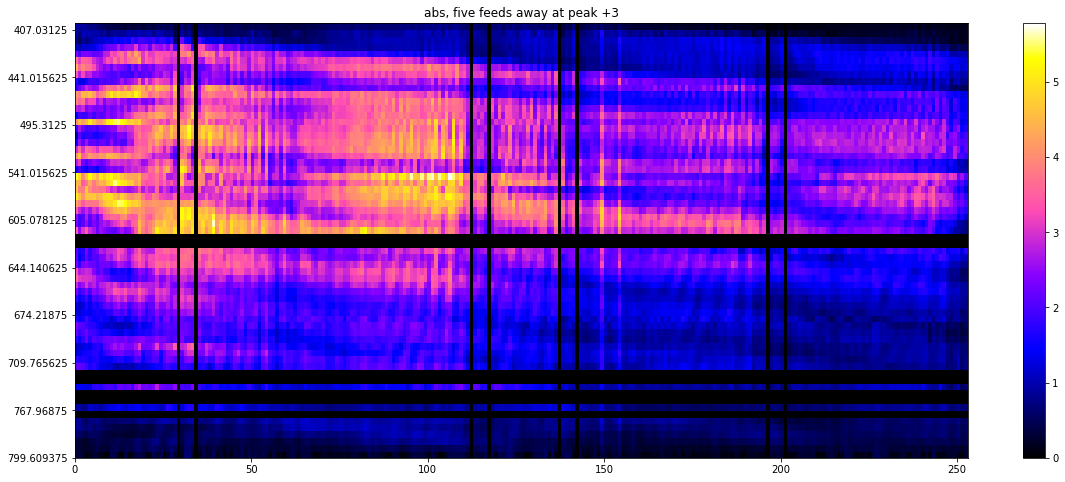

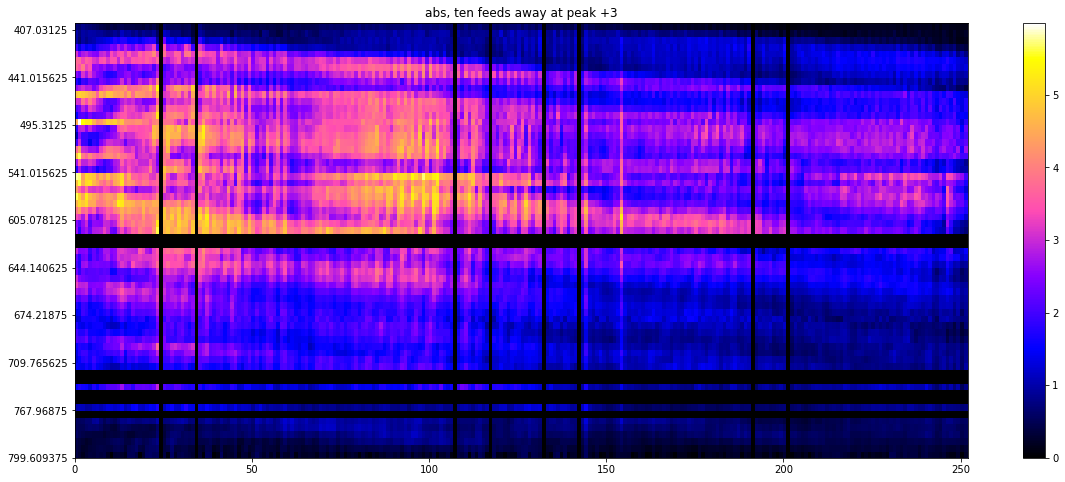

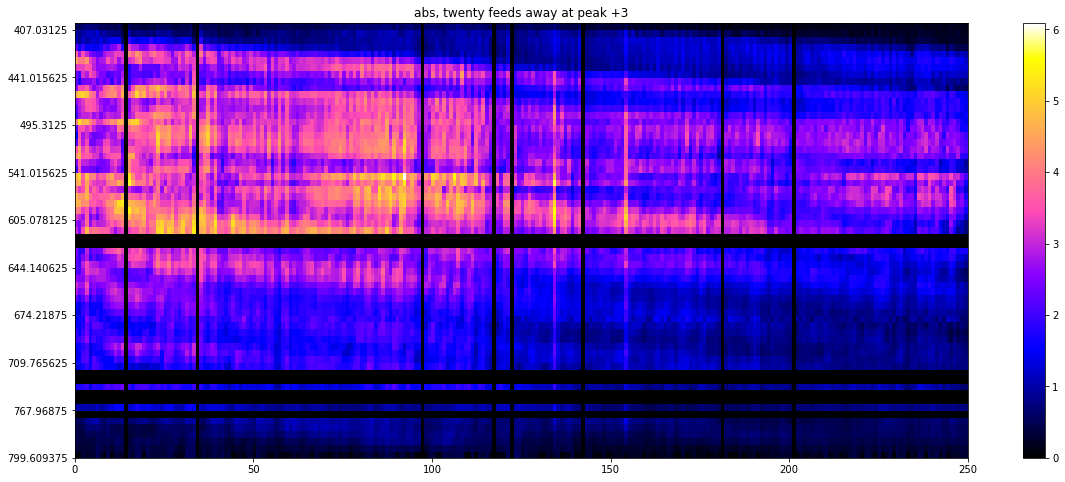

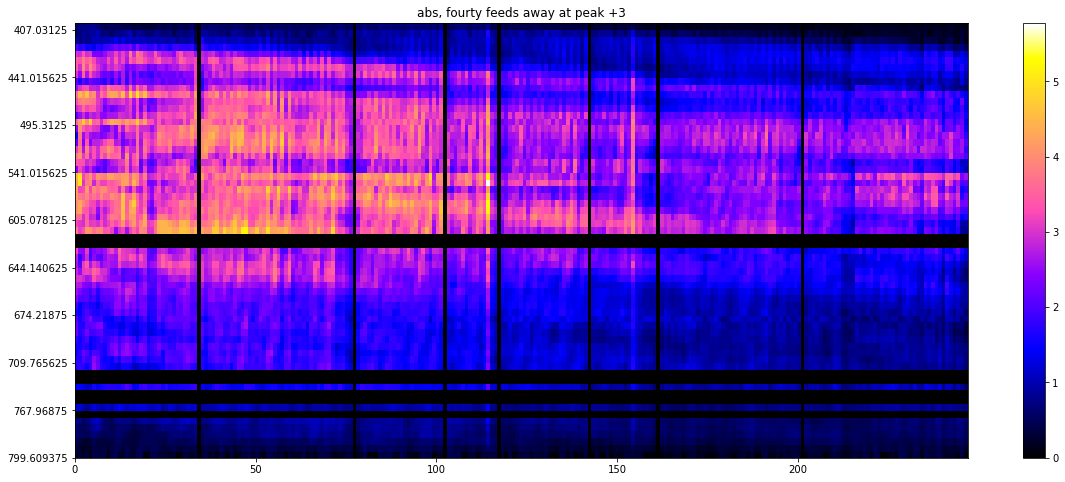

In [34]:
# Plots for peak +3

plt.pcolormesh(np.abs(np.transpose(vis[peakIndPluThree,:,fiveAway])),cmap='gnuplot2')
plt.title('abs, five feeds away at peak +3')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndPluThree,:,tenAway])),cmap='gnuplot2')
plt.title('abs, ten feeds away at peak +3')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndPluThree,:,twentyAway])),cmap='gnuplot2')
plt.title('abs, twenty feeds away at peak +3')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(np.transpose(vis[peakIndPluThree,:,fourtyAway])),cmap='gnuplot2')
plt.title('abs, fourty feeds away at peak +3')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

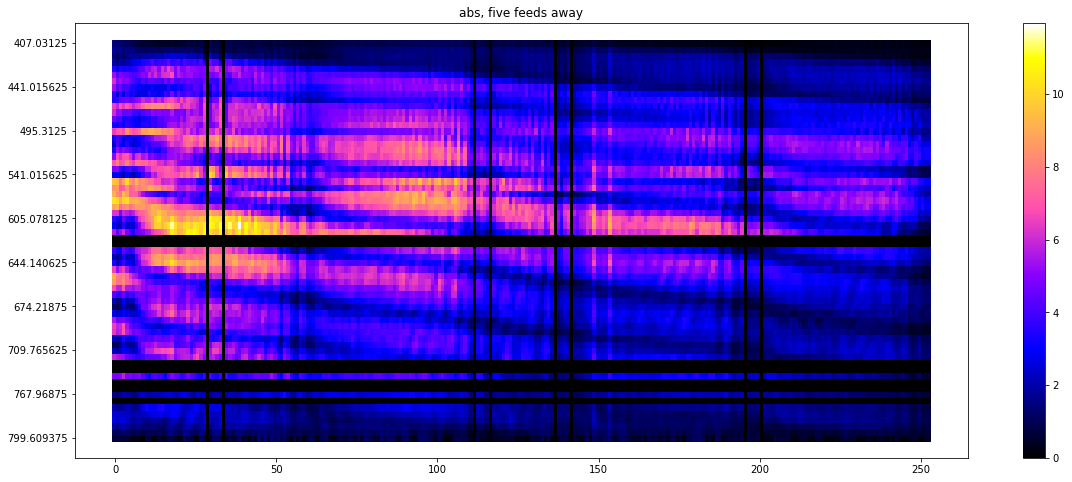

In [64]:
plt.scatter(*np.meshgrid(np.arange(np.abs(np.transpose(vis[peakInd,:,fiveAway])).shape[1]), np.arange(np.abs(np.transpose(vis[peakInd,:,fiveAway])).shape[0])), c=np.abs(np.transpose(vis[peakInd,:,fiveAway])).flatten(), cmap='gnuplot2', marker='s')
plt.title('abs, five feeds away')
plt.yticks(np.arange(0, len(freqList), 7), freqList[::7])
plt.colorbar()
plt.show()

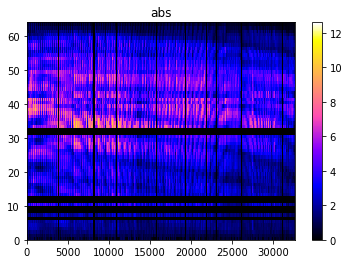

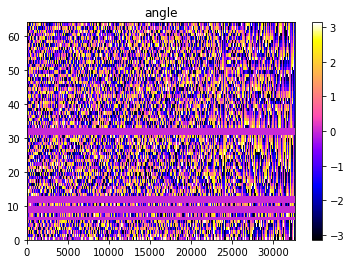

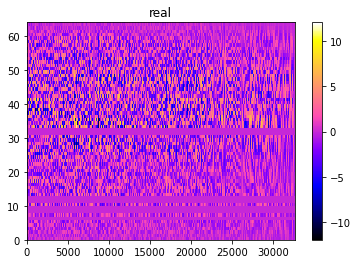

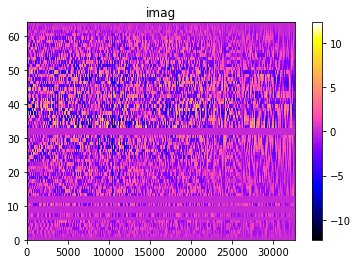

In [27]:
plt.pcolormesh(np.abs(np.transpose(vis[peakInd,:,XXpols])),cmap='gnuplot2')
plt.title('abs')
plt.colorbar()
plt.show()

plt.pcolormesh(np.angle(np.transpose(vis[peakInd,:,XXpols])),cmap='gnuplot2')
plt.title('angle')
plt.colorbar()
plt.show()

plt.pcolormesh(np.real(np.transpose(vis[peakInd,:,XXpols])),cmap='gnuplot2')
plt.title('real')
plt.colorbar()
plt.show()

plt.pcolormesh(np.imag(np.transpose(vis[peakInd,:,XXpols])),cmap='gnuplot2')
plt.title('imag')
plt.colorbar()
plt.show()

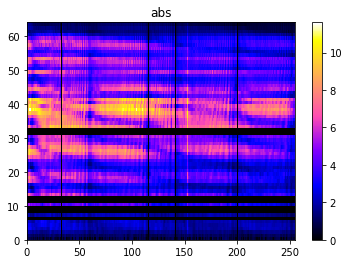

In [10]:
plt.pcolormesh(np.abs(np.transpose(vis[peakInd,:,XXpols[0:255]])),cmap='gnuplot2')
plt.title('abs')
plt.colorbar()
plt.show()

In [33]:

#print(XXpols)

32640


In [17]:
plt.pcolormesh(vis[peakInd,:,np.array(XXpols)],cmap='gnuplot2')
plt.colorbar()
plt.show()

IndexError: arrays used as indices must be of integer (or boolean) type

<Figure size 432x288 with 2 Axes>

In [98]:
np.sort([x for x in os.listdir(datadir)])[7]

'00003495_0000.h5'

In [95]:
print(len(range(7,9)))

2


In [25]:
## Drone flight Data: y throw complex data:
gaindir='/hirax/20220824_WLC_NFandFF/WLC_Corr_Data/20220825T202602Z_Suit_digitalgain/'
datadir='/hirax/CHIME_Oct_2022/20221028T212339Z_chimedronegatedN2_corr/'
EWN2corr=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,Data_File_Index=range(7,9),Fix_Gains=True,Gain_Params=[1,1],Apply_Gains=False,Load_Gains=False,crossmap=[],site_class=chimesite,use_ctime=True)
#EWN2corr=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,Data_File_Index=range(7,9),Fix_Gains=True,Gain_Params=[1,1],Apply_Gains=False,Load_Gains=False,crossmap=list(range(98176-256,98176+256)),site_class=chimesite,use_ctime=True)
#Print statement "Loading File:" is WRONG!!!
EWN2drone=drone.Drone_Data(dronedir,'FLY758.csv',site_class=chimesite)
EWN2corr.gainfile='lol'
EWN2concat=concat.CONCAT(CORRDATCLASS=EWN2corr,DRONEDATCLASS=EWN2drone,\
                       config_directory="/hirax/CHIME_Oct_2022/outputs/",\
                       output_directory="/hirax/CHIME_Oct_2022/outputs/",\
                       load_yaml=False,save_traceback=False)
                       

Initializing Correlator Class using:
  --> /hirax/CHIME_Oct_2022/20221028T212339Z_chimedronegatedN2_corr/
  --> Arrays initialized with shape (2, 256, 64, 512)
Assigning array values by reading in data files:
  --> Loading File: 00000499_0000.h5/00004992_0000.h5
  --> Finished. Reshaping arrays.
Initializing drone data via datcon_csv routine: FLY758.csv
  --> Skipping rows 1 to 499 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK data contains 7737/7737 non-nan values
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.
Initializing CONCAT CLASS with active traceback using:
  --> /hirax/CHIME_Oct_2022/20221028T212339Z_chimedronegatedN2_corr/
  --> FLY758.csv
  --> Traceback outputs will not be saved...
Concat initialized without previous config file...
Interpolating drone coordinates for each correlator timestamp:
  

In [29]:
print(EWN2corr.)

[nan nan nan]


In [20]:
print(EWN2corr.t_arr_datetime[197])

2022-10-28 22:28:18.669437+00:00


In [85]:
print(EWN2corr.t_arr_datetime[0])
print(EWN2corr.t_arr_datetime[-1])

2022-10-28 21:23:39.420582+00:00
2022-10-28 21:31:56.760179+00:00


In [89]:
datadirp='/hirax/CHIME_Oct_2022/20221028T212339Z_chimedronegatedN2_corr/'
fnp='00003994_0000.h5'
fd_np=h5py.File(datadirp+fnp, 'r')
index_map=fd_np['index_map']
print(index_map['time'][0][1])
print(index_map['time'][-1][1])

1666996213.7401676
1666996711.0797644


1666997867.638121


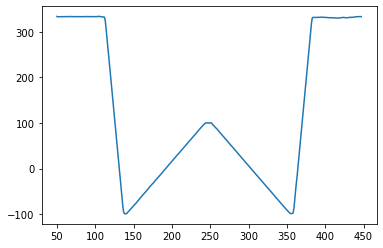

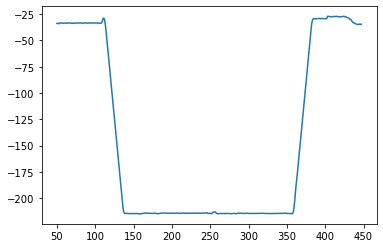

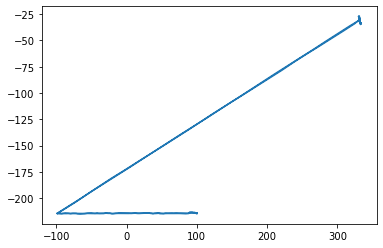

In [102]:
plt.plot(EWN2concat.drone_xyz_LC_interp[:,0])
plt.show()
plt.plot(EWN2concat.drone_xyz_LC_interp[:,1])
plt.show()
plt.plot(EWN2concat.drone_xyz_LC_interp[:,0], EWN2concat.drone_xyz_LC_interp[:,1])

In [70]:
## For FLY763 EW
print(EWN2drone.t_arr_timestamp[0])
print(EWN2drone.t_arr_timestamp[-1])

2022-10-28T23:35:14Z
2022-10-28T23:51:08Z


In [126]:
print(EWN2concat.V.shape)
print(EWN2concat.V_cross.shape)

(512, 64, 512)
(512, 64, 0)


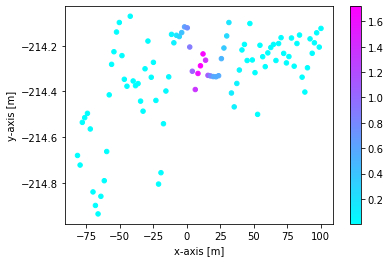

In [26]:
tlb, tub = [150,245]
feed = 2
#xmg, ymg = np.meshgrid(EWN2concat.drone_xyz_LC_interp[tlb:tub,0], EWN2concat.drone_xyz_LC_interp[tlb:tub,1])
pwrEWN2= np.abs(np.transpose(EWN2concat.V[tlb:tub,:,feed]))[44,:] #Index 44 corresponds to 525 MHz

plt.scatter(EWN2concat.drone_xyz_LC_interp[tlb:tub,0], EWN2concat.drone_xyz_LC_interp[tlb:tub,1], c=pwrEWN2 , cmap='cool', s=20, alpha=1)
plt.xlabel('x-axis [m]')
plt.ylabel('y-axis [m]')
plt.colorbar()

10.277289320463598


<function matplotlib.pyplot.show(close=None, block=None)>

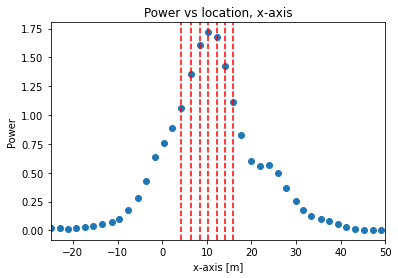

In [4]:
tlb, tub = [150,245]
feed = 2
#xmg, ymg = np.meshgrid(EWN2concat.drone_xyz_LC_interp[tlb:tub,0], EWN2concat.drone_xyz_LC_interp[tlb:tub,1])
pwrEWN2= np.abs(np.transpose(EWN2concat.V[tlb:tub,:,feed]))[44,:] #Index 44 corresponds to 525 MHz

print(EWN2concat.drone_xyz_LC_interp[197,0])

plt.scatter(EWN2concat.drone_xyz_LC_interp[tlb:tub,0], pwrEWN2)#, c=EWN2concat.drone_xyz_LC_interp[tlb:tub,1], cmap='cool', s=20, alpha=1)
plt.title('Power vs location, x-axis')
plt.xlabel('x-axis [m]')
plt.ylabel('Power')
plt.xlim(-25,50)
plt.axvline(x=EWN2concat.drone_xyz_LC_interp[197,0], color='r', linestyle='--')
plt.axvline(x=EWN2concat.drone_xyz_LC_interp[196,0], color='r', linestyle='--')
plt.axvline(x=EWN2concat.drone_xyz_LC_interp[195,0], color='r', linestyle='--')
plt.axvline(x=EWN2concat.drone_xyz_LC_interp[194,0], color='r', linestyle='--')
plt.axvline(x=EWN2concat.drone_xyz_LC_interp[198,0], color='r', linestyle='--')
plt.axvline(x=EWN2concat.drone_xyz_LC_interp[199,0], color='r', linestyle='--')
plt.axvline(x=EWN2concat.drone_xyz_LC_interp[200,0], color='r', linestyle='--')
#cbar=plt.colorbar()
#cbar.set_label('y-axis [m]')
plt.show

In [35]:
print(EWN2concat.drone_xyz_LC_interp.shape)

(512, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

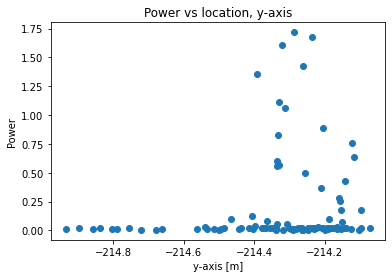

In [36]:
tlb, tub = [150,245]
feed = 2
#xmg, ymg = np.meshgrid(EWN2concat.drone_xyz_LC_interp[tlb:tub,0], EWN2concat.drone_xyz_LC_interp[tlb:tub,1])
pwrEWN2= np.abs(np.transpose(EWN2concat.V[tlb:tub,:,feed]))[44,:] #Index 44 corresponds to 525 MHz

plt.scatter(EWN2concat.drone_xyz_LC_interp[tlb:tub,1], pwrEWN2)#, c=EWN2concat.drone_xyz_LC_interp[tlb:tub,1], cmap='cool', s=20, alpha=1)
plt.title('Power vs location, y-axis')
plt.xlabel('y-axis [m]')
plt.ylabel('Power')
#cbar=plt.colorbar()
#cbar.set_label('y-axis [m]')
plt.show

In [9]:
tpeak=197

pwrEWN2= np.abs(np.transpose(EWN2concat.V[tpeak,:,:]))#[feed:(feed+1),:] #time, freq, baseline?
print(pwrEWN2.shape)
print(EWN2concat.V[197,:,0:256].shape)
print(EWN2concat.V.shape)
print(EWN2concat.V_cross.shape)
print(EWN2concat.V_cross[0:256,:,0].shape)
print(EWN2concat.V_cross[:,:,2].shape)
#Dont need x coordinate no more. (baseline[256:512], freq[:], power[256:512])
#(pwrEWN2)

(512, 64)
(64, 256)
(512, 64, 512)
(512, 64, 513)
(256, 64)
(512, 64)


In [9]:
xmap_indexes=np.empty(256)
for i in range(0,255):
    fst_entry=98176
    xmap_indexes[i]=fst_entry+i
print(xmap_indexes)

[9.8176000e+004 9.8177000e+004 9.8178000e+004 9.8179000e+004
 9.8180000e+004 9.8181000e+004 9.8182000e+004 9.8183000e+004
 9.8184000e+004 9.8185000e+004 9.8186000e+004 9.8187000e+004
 9.8188000e+004 9.8189000e+004 9.8190000e+004 9.8191000e+004
 9.8192000e+004 9.8193000e+004 9.8194000e+004 9.8195000e+004
 9.8196000e+004 9.8197000e+004 9.8198000e+004 9.8199000e+004
 9.8200000e+004 9.8201000e+004 9.8202000e+004 9.8203000e+004
 9.8204000e+004 9.8205000e+004 9.8206000e+004 9.8207000e+004
 9.8208000e+004 9.8209000e+004 9.8210000e+004 9.8211000e+004
 9.8212000e+004 9.8213000e+004 9.8214000e+004 9.8215000e+004
 9.8216000e+004 9.8217000e+004 9.8218000e+004 9.8219000e+004
 9.8220000e+004 9.8221000e+004 9.8222000e+004 9.8223000e+004
 9.8224000e+004 9.8225000e+004 9.8226000e+004 9.8227000e+004
 9.8228000e+004 9.8229000e+004 9.8230000e+004 9.8231000e+004
 9.8232000e+004 9.8233000e+004 9.8234000e+004 9.8235000e+004
 9.8236000e+004 9.8237000e+004 9.8238000e+004 9.8239000e+004
 9.8240000e+004 9.824100

In [ ]:
fnp2='00000998_0000.h5'
fd_np2=h5py.File(datadirp+fnp2, 'r')

index_map2=fd_np2['index_map']
blTot = 131328
blMatrix2 = np.zeros((512,512), dtype=int)

for i in range(blTot):
    x,y=index_map2['prod'][i]
    blMatrix2[x,y] = i 

diagEnt2 = np.diagonal(blMatrix2) #512 indexes
vis2=fd_np2['vis']
print(vis2.shape)
visp2 = np.array(vis2).transpose(2,0,1)
vis02 = visp2[:,44,:]


selected_values_list2 = [vis02[1][i] for i in diagEnt]

selected_values_list2 = selected_values_list2[255:511]

In [44]:
print(np.angle(EWN2concat.V_cross[0:256,:,2]))

[[-1.10714872 -1.19028995  2.12939564 ...  0.85670563  0.62879629
   0.32175055]
 [ 1.91956733  1.82812004 -0.8685394  ... -1.57079633 -2.86329299
  -0.98279372]
 [-2.35619449  0.19739556  1.17845618 ... -0.15660188  0.28605144
   1.66145621]
 ...
 [ 2.9411941   2.66589743  2.1006454  ...  1.44644133 -0.09495171
  -2.67794504]
 [-0.68231655  0.16514868 -0.78539816 ... -2.32590073  1.51371554
  -1.43526861]
 [-1.72945159  2.28488703  1.40564765 ...  1.81577499 -2.62920319
   2.58299334]]


In [ ]:
EWN2concat.V_cross[tpeak,:,0:256]

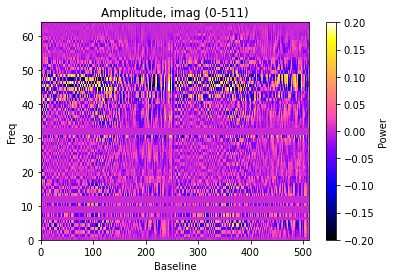

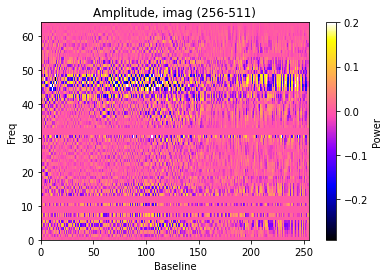

In [23]:
tpeak= 197

plt.pcolormesh(np.imag(EWN2concat.V_cross[tpeak,:,0:511]),cmap='gnuplot2', vmin=-.2,vmax=.2)
plt.colorbar().set_label('Power')
plt.title('Amplitude, imag (0-511)')
plt.xlabel('Baseline')
plt.ylabel('Freq')
plt.show()

plt.pcolormesh(np.imag(EWN2concat.V_cross[tpeak,:,256:511]),cmap='gnuplot2', vmax=.2)
plt.colorbar().set_label('Power')
plt.title('Amplitude, imag (256-511)')
plt.xlabel('Baseline')
plt.ylabel('Freq')
plt.show()

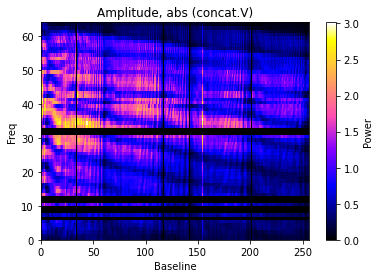

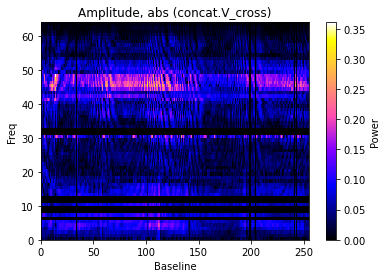

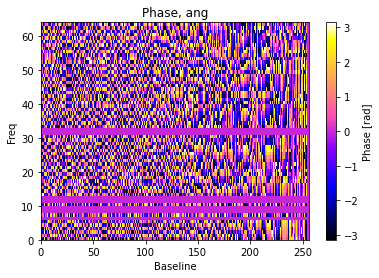

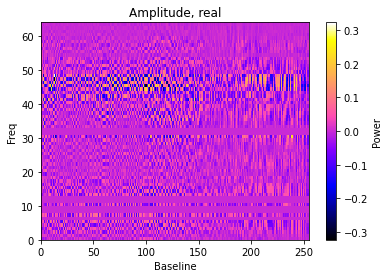

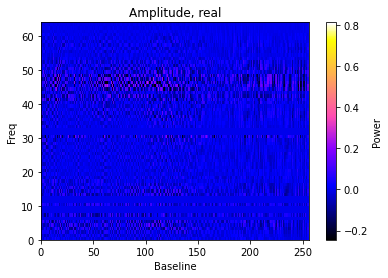

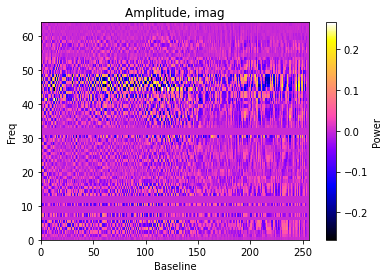

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 432x288 with 0 Axes>

In [48]:
# Wanna plot baseline, freq, power

#fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(40,10))

## Cross Only: Look at cross-corr data for one baseline?
#fig,[ax1,ax2,ax3,ax4]=subplots(nrows=1,ncols=4,figsize=(40,10))
#feeds=[0,1,2,3]
#tlb,tub=[234,265]
tpeak= 197
feed=2
pwrEWN2= np.transpose(np.abs(np.transpose(EWN2concat.V[tpeak,:,0:256])))
#pwrEWN2cplx= np.abs(np.transpose(EWN2concat.V_cross[0:256,:,2]))

plt.pcolormesh(np.abs(pwrEWN2),cmap='gnuplot2')
plt.colorbar().set_label('Power')
plt.title('Amplitude, abs (concat.V)')
plt.xlabel('Baseline')
plt.ylabel('Freq')
plt.show()

plt.pcolormesh(np.abs(EWN2concat.V_cross[tpeak,:,256:511]),cmap='gnuplot2')
plt.colorbar().set_label('Power')
plt.title('Amplitude, abs (concat.V_cross)')
plt.xlabel('Baseline')
plt.ylabel('Freq')
plt.show()


plt.pcolormesh(np.angle(EWN2concat.V_cross[tpeak,:,0:256]),cmap='gnuplot2')
plt.colorbar().set_label('Phase [rad]')
plt.title('Phase, ang')
plt.xlabel('Baseline')
plt.ylabel('Freq')
plt.show()

plt.pcolormesh(np.real(EWN2concat.V_cross[tpeak,:,0:255]),cmap='gnuplot2')
plt.colorbar().set_label('Power')
plt.title('Amplitude, real')
plt.xlabel('Baseline')
plt.ylabel('Freq')
plt.show()

plt.pcolormesh(np.real(EWN2concat.V_cross[tpeak,:,255:511]),cmap='gnuplot2')
plt.colorbar().set_label('Power')
plt.title('Amplitude, real')
plt.xlabel('Baseline')
plt.ylabel('Freq')
plt.show()

plt.pcolormesh(np.imag(EWN2concat.V_cross[tpeak,:,0:256]),cmap='gnuplot2')
plt.colorbar().set_label('Power')
plt.title('Amplitude, imag')
plt.xlabel('Baseline')
plt.ylabel('Freq')
plt.show()

#Interpolate real and imag
#plt.pcolormesh(np.imag(EWN2concat.V_cross[tpeak,:,0:256]+np.real(EWN2concat.V_cross[tpeak,:,0:256]),cmap='gnuplot2')
plt.colorbar().set_label('Power')
plt.title('Amplitude, imag')
plt.xlabel('Baseline')
plt.ylabel('Freq')
plt.show()

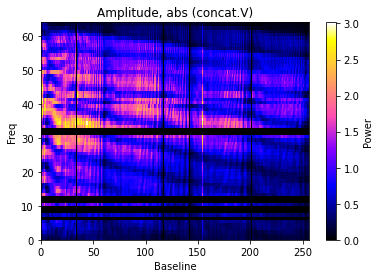

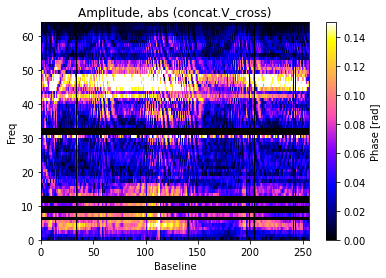

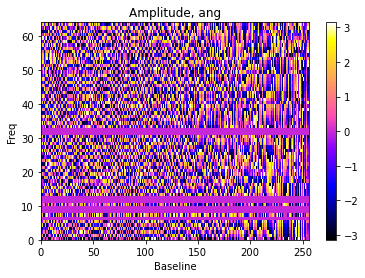

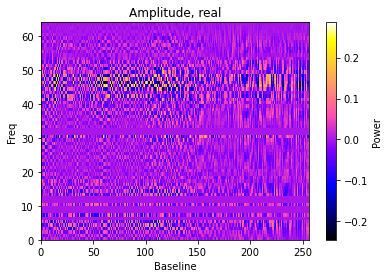

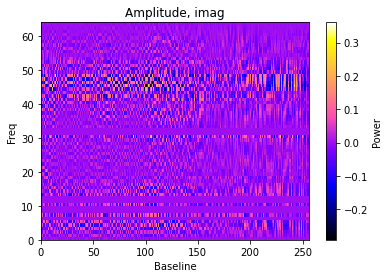

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 432x288 with 0 Axes>

In [8]:
# Wanna plot baseline, freq, power

#fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(40,10))

## Cross Only: Look at cross-corr data for one baseline?
#fig,[ax1,ax2,ax3,ax4]=subplots(nrows=1,ncols=4,figsize=(40,10))
#feeds=[0,1,2,3]
#tlb,tub=[234,265]
tpeak= 197
feed=2
pwrEWN2= np.transpose(np.abs(np.transpose(EWN2concat.V[tpeak,:,0:256])))
pwrEWN2cplx= np.abs(np.transpose(EWN2concat.V_cross[0:256,:,2]))

plt.pcolormesh(np.abs(pwrEWN2),cmap='gnuplot2')
plt.colorbar().set_label('Power')
plt.title('Amplitude, abs (concat.V)')
plt.xlabel('Baseline')
plt.ylabel('Freq')
plt.show()

plt.pcolormesh(np.abs(EWN2concat.V_cross[tpeak,:,0:256]),cmap='gnuplot2', vmax=0.15)
plt.colorbar().set_label('Phase [rad]')
plt.title('Amplitude, abs (concat.V_cross)')
plt.xlabel('Baseline')
plt.ylabel('Freq')
plt.show()

plt.pcolormesh(np.angle(EWN2concat.V_cross[tpeak,:,0:256]),cmap='gnuplot2')
plt.colorbar()
plt.title('Phase, ang')
plt.xlabel('Baseline')
plt.ylabel('Freq')
plt.show()

plt.pcolormesh(np.real(EWN2concat.V_cross[tpeak,:,0:256]),cmap='gnuplot2')
plt.colorbar().set_label('Power')
plt.title('Amplitude, real')
plt.xlabel('Baseline')
plt.ylabel('Freq')
plt.show()

plt.pcolormesh(np.imag(EWN2concat.V_cross[tpeak,:,0:256]),cmap='gnuplot2')
plt.colorbar().set_label('Power')
plt.title('Amplitude, imag')
plt.xlabel('Baseline')
plt.ylabel('Freq')
plt.show()

#Interpolate real and imag
#plt.pcolormesh(np.imag(EWN2concat.V_cross[tpeak,:,0:256]+np.real(EWN2concat.V_cross[tpeak,:,0:256]),cmap='gnuplot2')
plt.colorbar().set_label('Power')
plt.title('Amplitude, imag')
plt.xlabel('Baseline')
plt.ylabel('Freq')
plt.show

In [ ]:
tlb,tub=[0,-1]
print(len(EWN2concat.drone_xyz_LC_interp[tlb:tub,0]))
# Sample array with NaN values
arr = EWN2concat.drone_xyz_LC_interp[tlb:tub,0]

# Create a boolean mask for non-NaN values
non_nan_mask = ~np.isnan(arr)

# Get the indices of non-NaN values
non_nan_indices = np.where(non_nan_mask)[0]

# Get the last index of non-NaN values
if len(non_nan_indices) > 0:
    last_non_nan_index = non_nan_indices[-1]
    print("Index of the last non-NaN value:", last_non_nan_index)
else:
    print("All values are NaN")


(768, 64, 512)


Text(0, 0.5, 'y [m]')

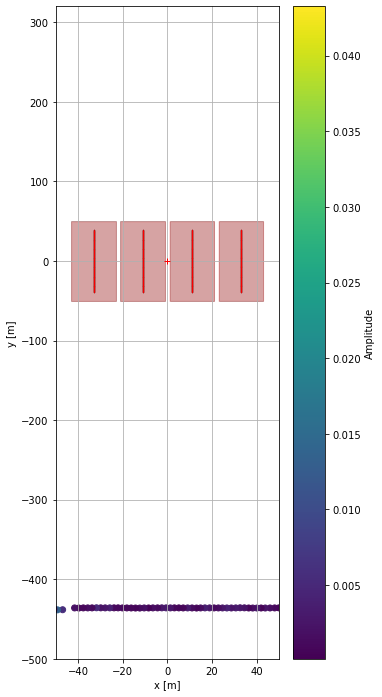

In [75]:
figure(figsize=(5,12))
#xlim(-50,50)
xlim(-50,50)
ylim(-500,320)
plot(0,0,'r+')
for j in [-33,-11,11,33]:
    x=np.array([j-10,j+10])
    y1=np.array([-50,-50])
    y2=np.array([50,50])
    fill_between(x,y1,y2,color='k',alpha=0.2)
    x0,y10=CHIME_2d_Rot(x,y1)
    x0,y20=CHIME_2d_Rot(x,y2)
    fill_between(x0,y10,y20,color='r',alpha=0.2)
    xf=j*np.ones(256)
    yf=np.linspace(-0.3048*(256/2),+0.3048*(256/2),256)
    xf0,yf0=CHIME_2d_Rot(xf,yf)
    plot(xf,yf,'k.',markersize=0.5)
    plot(xf0,yf0,'r.',markersize=0.5)
grid()
print(EWN2concat.V.shape)
#The range tlb,tub=[198,300] has one EW pass
tlb,tub=[198,300]
scatter(EWN2concat.drone_xyz_LC_interp[tlb:tub,0],EWN2concat.drone_xyz_LC_interp[tlb:tub,1],c=np.abs(EWN2concat.V_cross[tlb:tub,50,0]))#norm=LogNorm())
colorbar(label='Amplitude')
#scatter(NSconcat.drone_xyz_LC_interp[tlb:tub,0],NSconcat.drone_xyz_LC_interp[tlb:tub,1],c=NSconcat.V[tlb:tub,50,350])#norm=LogNorm())
xlabel('x [m]')
ylabel('y [m]')

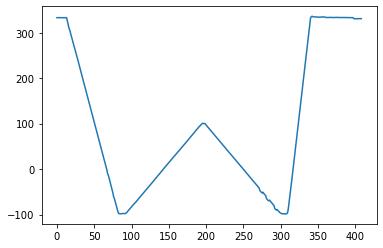

In [57]:
plt.plot(EWN2concat.drone_xyz_LC_interp[:,0])

In [ ]:
print(EWN2concat.)

In [5]:
print(EWN2concat.V.shape)

(768, 64, 512)


In [39]:
datadirp='/hirax/CHIME_Oct_2022/20221028T193747Z_chimedronegatedN2_corr/'
'''
fnp1='00000499_0000.h5'
fd_np1=h5py.File(datadirp+fnp1, 'r')

fnp2='00000998_0000.h5'
fd_np2=h5py.File(datadirp+fnp2, 'r')
'''
fnp='00001497_0000.h5'
fd_np=h5py.File(datadirp+fnp, 'r')

In [4]:

print(fd_np.keys)

<bound method MappingHDF5.keys of <HDF5 file "00001497_0000.h5" (mode r)>>


In [4]:
## Trying to read files with the signal peak
## DOESNT WORK, TOO MEMORY HEAVY
'''
datadirp='/hirax/CHIME_Oct_2022/20221028T233752Z_chimedronegatedN2_corr/'
filenames = ['00000499_0000.h5', '00000998_0000.h5', '00001497_0000.h5']

def read_h5_file(file):
    data_list = []
    
    def visitor(name, node):
        if isinstance(node, h5py.Dataset):
            data_list.append(node[:])
    
    file.visititems(visitor)
    return data_list

# List to store data from each file
all_data = []

# Loop through the filenames and read the entire file contents
for filename in filenames:
    with h5py.File(datadirp + filename, 'r') as f:
        file_data = read_h5_file(f)
        all_data.append(file_data)

# Check if all datasets have the same shape and concatenate them
concatenated_data = []

for dataset in zip(*all_data):
    concatenated_dataset = np.stack(dataset, axis=0)
    concatenated_data.append(concatenated_dataset)

# Convert the list of concatenated datasets to a numpy array
concatenated_data = np.array(concatenated_data)

# Example: Print the shape of the concatenated data array for the first dataset
print(concatenated_data[0].shape)

# If you want to concatenate them all into a single array
# Assumes each file has one dataset with the same shape
all_datasets_concatenated = np.concatenate([data[0] for data in all_data], axis=0)

print(all_datasets_concatenated.shape)

MemoryError: Unable to allocate 8.02 GiB for an array with shape (64, 131328, 256) and data type float32

In [6]:
print(fd_np1.keys())

<KeysViewHDF5 ['erms', 'eval', 'evec', 'flags', 'gain', 'index_map', 'vis']>


In [5]:
vis=fd_np['vis']

In [6]:
print(vis.shape)
print(np.array(vis).transpose(2,0,1).shape) #time, freq, x-prod

(64, 131328, 256)
(256, 64, 131328)


In [ ]:
tlb,tub=[234,265]
plot(EWN2concat.drone_xyz_LC_interp[tlb:tub,0])
print(EWN2concat.V.shape) #time, freq, feed
print(EWN2concat.V_cross.shape)

In [ ]:
print('entries per file: ', 768/14)
print(198/54)
print(300/54)
#So then the -25 to +25 m region is in the 4th file (00001497_0000.h5)?

In [21]:
#datadirp='/hirax/CHIME_Oct_2022/20221028T233752Z_chimedronegatedN2_corr/'
#fn='00001497_0000.h5'

#fd_n=h5py.File(datadirp+fn, 'r')
vis=fd_np['vis']
print(vis.shape)
visp = np.array(vis).transpose(2,0,1)
print(visp.shape) #time, freq, x-prod

(64, 131328, 256)
(256, 64, 131328)


In [9]:
print(fd_np.keys())
index_map=fd_np['index_map']
print(index_map.attrs)

<KeysViewHDF5 ['erms', 'eval', 'evec', 'flags', 'gain', 'index_map', 'vis']>
<Attributes of HDF5 object at 140009630799728>


In [9]:
print(index_map.keys())
print(index_map['prod'])
print(index_map['ev'])
print(index_map['freq'])
print(index_map['input'])
print(index_map['time'])
print(index_map['prod'][0]) #gives the coord for nth entry

<KeysViewHDF5 ['ev', 'freq', 'input', 'prod', 'time']>
<HDF5 dataset "prod": shape (131328,), type "|V4">
<HDF5 dataset "ev": shape (10,), type "<u4">
<HDF5 dataset "freq": shape (64,), type "|V16">
<HDF5 dataset "input": shape (512,), type "|V34">
<HDF5 dataset "time": shape (256,), type "|V16">
(0, 0)


In [39]:
print(index_map['time'][0][1])
print(index_map['time'][-1][1])
print(1667001772.2415435 - 1667001770.2911923)

1667001770.2911923
1667002267.630789
1.9503512382507324


1970-01-04 17:38:50.953728


In [13]:
print(index_map['freq'].shape)
print(index_map['freq'][0:63])

freqList=index_map['freq'][0:63]

(64,)
[(799.609375, 0.390625) (795.3125  , 0.390625) (791.015625, 0.390625)
 (785.9375  , 0.390625) (781.640625, 0.390625) (777.34375 , 0.390625)
 (772.65625 , 0.390625) (767.96875 , 0.390625) (764.0625  , 0.390625)
 (759.765625, 0.390625) (728.125   , 0.390625) (724.21875 , 0.390625)
 (719.921875, 0.390625) (715.625   , 0.390625) (709.765625, 0.390625)
 (705.859375, 0.390625) (701.5625  , 0.390625) (691.796875, 0.390625)
 (687.5     , 0.390625) (682.8125  , 0.390625) (678.515625, 0.390625)
 (674.21875 , 0.390625) (670.3125  , 0.390625) (666.015625, 0.390625)
 (661.71875 , 0.390625) (657.8125  , 0.390625) (653.125   , 0.390625)
 (648.828125, 0.390625) (644.140625, 0.390625) (640.234375, 0.390625)
 (635.9375  , 0.390625) (631.640625, 0.390625) (627.34375 , 0.390625)
 (613.671875, 0.390625) (609.375   , 0.390625) (605.078125, 0.390625)
 (601.171875, 0.390625) (596.875   , 0.390625) (592.1875  , 0.390625)
 (587.890625, 0.390625) (563.28125 , 0.390625) (558.59375 , 0.390625)
 (541.015625, 

In [ ]:
print(index_map['prod'].shape)

In [8]:
index_map1=fd_np1['index_map']
blTot = 131328
blMatrix1 = np.zeros((512,512), dtype=int)

for i in range(blTot):
    x,y=index_map1['prod'][i]
    blMatrix1[x,y] = i 
    
print(blMatrix1)

[[     0      1      2 ...    509    510    511]
 [     0    512    513 ...   1020   1021   1022]
 [     0      0   1023 ...   1530   1531   1532]
 ...
 [     0      0      0 ... 131322 131323 131324]
 [     0      0      0 ...      0 131325 131326]
 [     0      0      0 ...      0      0 131327]]


In [7]:
index_map2=fd_np2['index_map']
blTot = 131328
blMatrix2 = np.zeros((512,512), dtype=int)

for i in range(blTot):
    x,y=index_map2['prod'][i]
    blMatrix2[x,y] = i 
    
print(blMatrix2)

[[     0      1      2 ...    509    510    511]
 [     0    512    513 ...   1020   1021   1022]
 [     0      0   1023 ...   1530   1531   1532]
 ...
 [     0      0      0 ... 131322 131323 131324]
 [     0      0      0 ...      0 131325 131326]
 [     0      0      0 ...      0      0 131327]]


In [3]:
index_map=fd_np['index_map']
blTot = 131328
blMatrix = np.zeros((512,512), dtype=int)

for i in range(blTot):
    x,y=index_map['prod'][i]
    blMatrix[x,y] = i 
    
print(blMatrix)

[[     0      1      2 ...    509    510    511]
 [     0    512    513 ...   1020   1021   1022]
 [     0      0   1023 ...   1530   1531   1532]
 ...
 [     0      0      0 ... 131322 131323 131324]
 [     0      0      0 ...      0 131325 131326]
 [     0      0      0 ...      0      0 131327]]


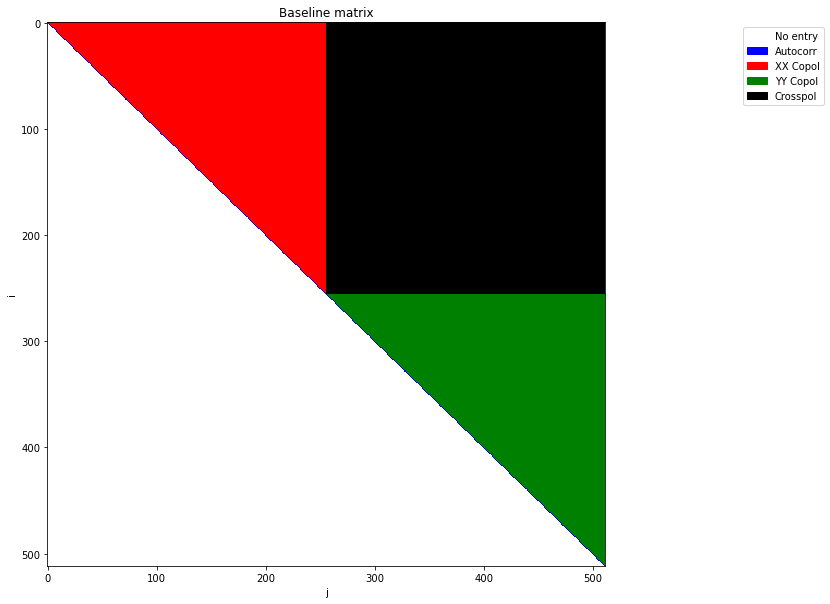

In [65]:
# This is just a graphic representation of the data set

import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

def bsColorMap(blMatrix):
    color_matrix = np.full(blMatrix.shape, -1)
    
    for i in range(blMatrix.shape[0]):
        for j in range(blMatrix.shape[1]):
            if blMatrix[i, j] == 0:
                color_matrix[i, j] = 0  # white for zero values
            elif i == j:
                color_matrix[i, j] = 1  # blue for diagonal
            elif i < 256 and j < 256:
                color_matrix[i, j] = 2  # red for region (0,0)-(255,255)
            elif i < 256 and j >=256:
                color_matrix[i, j] = 4  # black for region (0,0)-(255,511)
            elif i>=256 and j>=256:
                color_matrix[i, j] = 3  # green for mirrored off-diagonal, region x=(256,511) and y=(0,255)
    return color_matrix

color_matrix = bsColorMap(blMatrix)

colors = ['white', 'blue', 'red', 'green', 'black']
cmap = mcolors.ListedColormap(colors)
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the matrix
plt.figure(figsize=(10, 10))
plt.imshow(color_matrix, cmap=cmap, norm=norm, interpolation='nearest', aspect='auto')

# Create legend patches
white_patch = mpatches.Patch(color='white', label='No entry')
blue_patch = mpatches.Patch(color='blue', label='Autocorr')
red_patch = mpatches.Patch(color='red', label='XX Copol')
green_patch = mpatches.Patch(color='green', label='YY Copol')
black_patch = mpatches.Patch(color='black', label='Crosspol')

# Add the legend to the plot
plt.legend(handles=[white_patch, blue_patch, red_patch, green_patch, black_patch], loc='upper right', bbox_to_anchor=(1.4, 1))
plt.xlabel('j')
plt.ylabel('i')
plt.title('Baseline matrix')


# Display the plot
plt.show()

In [4]:
'''
We are interested in the YY region of the data.
Let's first look at all the different baseline distances (i=255,j>=256)
'''
entry_number_255_256 = sum(512 - i for i in range(0, 255)) +1
print("Entry number at coordinates (255, 256) in a 512x512 diagonal matrix:", entry_number_255_256)


print(index_map['prod'][entry_number_255_256])
print(index_map['prod'][entry_number_255_256+255])
print(entry_number_255_256+255)


# According to this code, it should be entry 98176 to 98431

Entry number at coordinates (255, 256) in a 512x512 diagonal matrix: 98176


NameError: name 'index_map' is not defined

In [ ]:
def list_subgroups(group, path=''):
    subgroups = []
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Group):
            full_path = f'{path}/{key}' if path else key
            subgroups.append(full_path)
            subgroups.extend(list_subgroups(item, full_path))
    return subgroups

file_path = 'your_file.h5'  # Replace with your actual file path
with h5py.File(file_path, 'r') as h5file:
    group_name = 'some_group'  # Replace with your actual group name
    if group_name in h5file:
        group = h5file[group_name]
        all_subgroups = list_subgroups(group)
        print(f"All subgroups in the group '{group_name}':", all_subgroups)


In [ ]:
131328-2*(256*255)

In [ ]:
131328-2*(256**2)

In [11]:
vis0 = visp[:,44,:]
#xprods=index_map['prod'][0:131328]
#freqList=index_map['freq'][0:64]
#print(xprods.shape)
#print(freqList.shape)
print(vis0.shape)
print(vis0)

(256, 131328)
[[ 0.04370117+0.j         -0.02392578+0.03173828j  0.03417969+0.00488281j
  ...  0.09472656+0.j         -0.08007812+0.01708984j
   0.07617188+0.j        ]
 [ 0.04321289+0.j         -0.02099609+0.02978516j  0.01904297+0.00439453j
  ...  0.08007812+0.j         -0.05957031+0.02441406j
   0.04882812+0.j        ]
 [ 0.11010742+0.j         -0.02880859+0.06787109j  0.02148438-0.00048828j
  ...  0.04833984+0.j         -0.05126953+0.00683594j
   0.05761719+0.j        ]
 ...
 [ 0.07177734+0.j         -0.03027344+0.04736328j  0.00830078-0.01904297j
  ...  0.04785156+0.j         -0.06933594+0.06396484j
   0.19042969+0.j        ]
 [ 0.05615234+0.j         -0.02709961+0.01782227j  0.02929688+0.00244141j
  ...  0.05517578+0.j         -0.05810547+0.05859375j
   0.14013672+0.j        ]
 [ 0.04443359+0.j         -0.015625  +0.0234375j   0.02050781-0.00439453j
  ...  0.07885742+0.j         -0.09082031+0.07128906j
   0.15283203+0.j        ]]


In [34]:
print(vis01[1])

[ 0.        +0.j          0.00341797+0.00537109j -0.        -0.00390625j
 ...  0.01708984+0.j          0.00244141-0.01000977j
  0.00878906+0.j        ]


(64, 131328, 256)


<ipython-input-31-4316bc2a4909>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  vis01ac[1] = selected_values_list


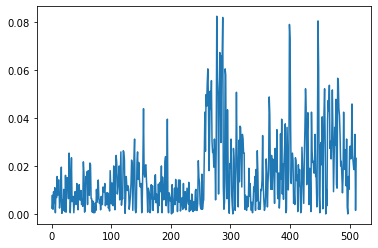

In [31]:
diagEnt1 = np.diagonal(blMatrix1) #512 indexes
vis1=fd_np1['vis']
print(vis1.shape)
visp1 = np.array(vis1).transpose(2,0,1)
vis01 = visp1[:,50,:]


selected_values_list = [vis01[1][i] for i in diagEnt1[152:255]]

# Create an empty array vis01ac with shape (256, 512)
vis01ac = np.empty((512, 512))

# Populate vis01ac[1] with the values from selected_values_list
vis01ac[1] = selected_values_list

plt.plot(list(range(512)), np.abs(selected_values_list))


(64, 131328, 256)


Text(0, 0.5, 'Power')

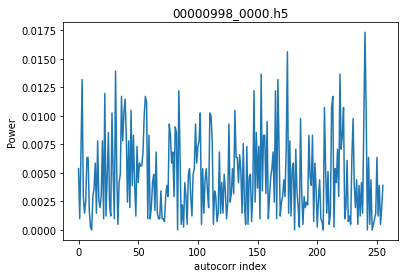

In [61]:
fnp2='00000998_0000.h5'
fd_np2=h5py.File(datadirp+fnp2, 'r')

index_map2=fd_np2['index_map']
blTot = 131328
blMatrix2 = np.zeros((512,512), dtype=int)

for i in range(blTot):
    x,y=index_map2['prod'][i]
    blMatrix2[x,y] = i 

diagEnt2 = np.diagonal(blMatrix2) #512 indexes
vis2=fd_np2['vis']
print(vis2.shape)
visp2 = np.array(vis2).transpose(2,0,1)
vis02 = visp2[:,44,:]


selected_values_list2 = [vis02[1][i] for i in diagEnt]

selected_values_list2 = selected_values_list2[255:511]

plt.plot(list(range(256)), np.abs(selected_values_list2))
plt.title(fnp2)
plt.xlabel('autocorr index')
plt.ylabel('Power')

(256,)


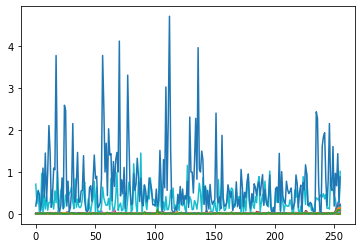

In [62]:
selected_values_list2 = [vis02[1][i] for i in diagEnt2]
selected_values_list2 = np.array(selected_values_list2[255:511])
#print(visp.shape) #time, freq, baseline
print(selected_values_list2.shape)

for i in np.arange(0,63):
    plt.plot(np.abs(visp2[:, i, diagEnt2[300]]))
    #plt.xlim(25,75)

(64, 131328, 256)


Text(0, 0.5, 'Power')

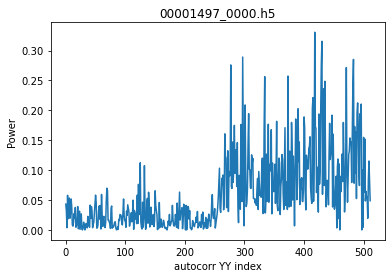

In [54]:
diagEnt = np.diagonal(blMatrix) #512 indexes
vis=fd_np['vis']
print(vis.shape)
visp = np.array(vis).transpose(2,0,1) #freq, baseline, time
vis0 = visp[:,44,:]


selected_values_list = [vis0[1][i] for i in diagEnt]

selected_values_list = selected_values_list[0:512]

plt.plot(list(range(512)), np.abs(selected_values_list))
plt.title('00001497_0000.h5')
plt.xlabel('autocorr YY index')
plt.ylabel('Power')
#plt.xlim(230,511)

In [ ]:
'00000000_0000.h5', '00000499_0000.h5', '00000998_0000.h5',
       '00001497_0000.h5', '00001997_0000.h5', '00002496_0000.h5',
       '00002995_0000.h5', '00003495_0000.h5', '00003994_0000.h5',
       '00004493_0000.h5', '00004992_0000.h5', '00005492_0000.h5',
       '00005991_0000.h5', '00006490_0000.h5'

(64, 131328, 256)
(512,)


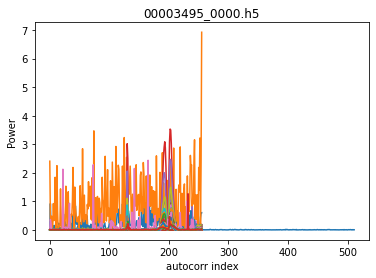

In [3]:
datadirp='/hirax/CHIME_Oct_2022/20221028T212339Z_chimedronegatedN2_corr/'
fnp='00003495_0000.h5'
fd_np=h5py.File(datadirp+fnp, 'r')

index_map=fd_np['index_map']
blTot = 131328
blMatrix = np.zeros((512,512), dtype=int)

for i in range(blTot):
    x,y=index_map['prod'][i]
    blMatrix[x,y] = i 

diagEnt = np.diagonal(blMatrix) #512 indexes
vis=fd_np['vis']
print(vis.shape)
visp = np.array(vis).transpose(2,0,1)
vis0 = visp[:,44,:]


selected_values_list = [vis0[1][i] for i in diagEnt]

#selected_values_list = selected_values_list[256:511]
selected_values_list = selected_values_list[0:512]

#plt.plot(list(range(256)), np.abs(selected_values_list))
plt.plot(list(range(512)), np.abs(selected_values_list))
plt.title(fnp)
plt.xlabel('autocorr index')
plt.ylabel('Power')

selected_values_list = [vis0[1][i] for i in diagEnt]
#selected_values_list = np.array(selected_values_list[256:511])
selected_values_list = np.array(selected_values_list[0:512])
#print(visp.shape) #time, freq, baseline
print(selected_values_list.shape)

for i in np.arange(0,63):
    plt.plot(np.abs(visp[:, i, diagEnt[300]]))
    #plt.xlim(25,75)

In [18]:
512*4

2048

In [10]:
print(diagEnt)

[     0    512   1023   1533   2042   2550   3057   3563   4068   4572
   5075   5577   6078   6578   7077   7575   8072   8568   9063   9557
  10050  10542  11033  11523  12012  12500  12987  13473  13958  14442
  14925  15407  15888  16368  16847  17325  17802  18278  18753  19227
  19700  20172  20643  21113  21582  22050  22517  22983  23448  23912
  24375  24837  25298  25758  26217  26675  27132  27588  28043  28497
  28950  29402  29853  30303  30752  31200  31647  32093  32538  32982
  33425  33867  34308  34748  35187  35625  36062  36498  36933  37367
  37800  38232  38663  39093  39522  39950  40377  40803  41228  41652
  42075  42497  42918  43338  43757  44175  44592  45008  45423  45837
  46250  46662  47073  47483  47892  48300  48707  49113  49518  49922
  50325  50727  51128  51528  51927  52325  52722  53118  53513  53907
  54300  54692  55083  55473  55862  56250  56637  57023  57408  57792
  58175  58557  58938  59318  59697  60075  60452  60828  61203  61577
  6195

/home/ec2274/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


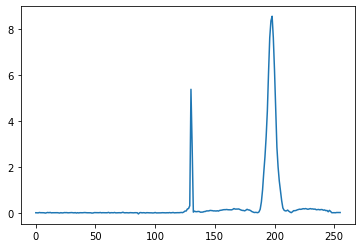

/home/ec2274/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


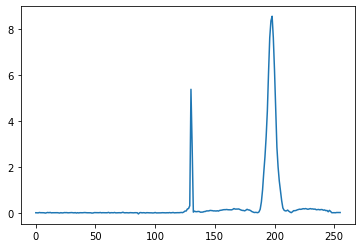

In [9]:
plt.plot(visp[:,44,diagEnt[9]])
plt.show()
plt.plot(vis[44,diagEnt[9],:])
plt.show()

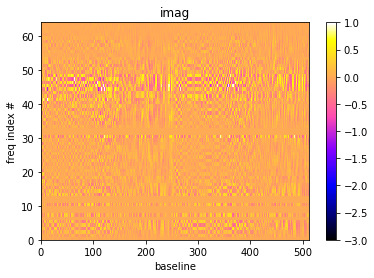

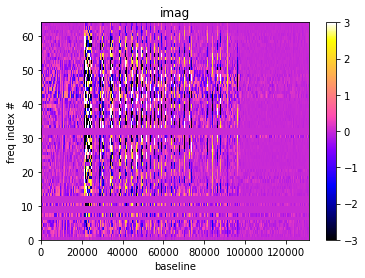

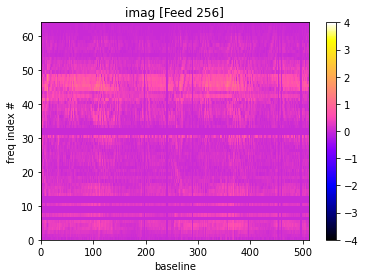

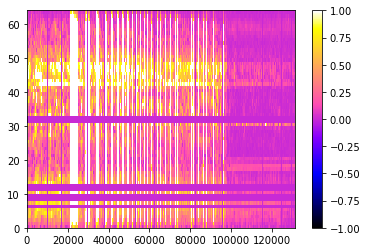

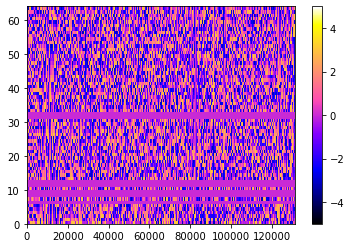

In [4]:
vispeak = visp[197,:,:]
plt.pcolormesh(np.imag(vispeak[:,(98176-256):(98176+256)]),cmap='gnuplot2', vmax=1, vmin=-3)
plt.title('imag')
plt.xlabel('baseline')
plt.ylabel('freq index #')
plt.colorbar()
plt.show()

plt.pcolormesh(np.imag(vispeak),cmap='gnuplot2', vmax=3, vmin=-3)
plt.title('imag')
plt.xlabel('baseline')
plt.ylabel('freq index #')
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(vispeak[:,(98176-256):(98176+256)]),cmap='gnuplot2', vmax=4, vmin=-4)
plt.title('imag [Feed 256]')
plt.xlabel('baseline')
plt.ylabel('freq index #')
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(vispeak[:,:]),cmap='gnuplot2', vmax=1, vmin=-1)
plt.colorbar()
plt.show()

plt.pcolormesh(np.angle(vispeak),cmap='gnuplot2', vmax=5, vmin=-5)
plt.colorbar()
plt.show()

In [11]:
print(diagEnt[300])

108750


(256,)


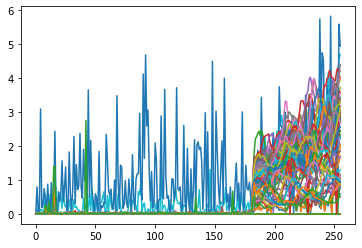

In [44]:
selected_values_list = [vis0[1][i] for i in diagEnt]
selected_values_list = np.array(selected_values_list[255:511])
#print(visp.shape) #time, freq, baseline
print(selected_values_list.shape)

for i in np.arange(0,63):
    plt.plot(np.abs(visp[:, i, diagEnt[300]]))
    #plt.xlim(25,75)

In [5]:


vist = np.abs(visp[:, diagEnt, :])
print(vist.shape)

'''plt.plot(list(range(256)), np.abs(selected_values_list))
plt.title('00001497_0000.h5')
plt.xlabel('autocorr YY index')
plt.ylabel('Power')
'''

MemoryError: Unable to allocate 128. GiB for an array with shape (512, 256, 131328) and data type complex64

In [27]:
print(vis0.shape)

(256, 131328)


(64, 131328, 256)


Text(0, 0.5, 'Power')

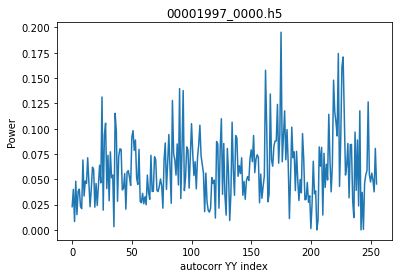

In [59]:
fnp4='00001997_0000.h5'
fd_np4=h5py.File(datadirp+fnp4, 'r')

index_map4=fd_np4['index_map']
blTot = 131328
blMatrix4 = np.zeros((512,512), dtype=int)

for i in range(blTot):
    x,y=index_map4['prod'][i]
    blMatrix4[x,y] = i 

diagEnt4 = np.diagonal(blMatrix4) #512 indexes
vis4=fd_np4['vis']
print(vis4.shape)
visp4 = np.array(vis4).transpose(2,0,1)
vis04 = visp4[:,52,:]


selected_values_list4 = [vis04[1][i] for i in diagEnt]

selected_values_list4 = selected_values_list4[255:511]

plt.plot(list(range(256)), np.abs(selected_values_list4))
plt.title(fnp4)
plt.xlabel('autocorr YY index')
plt.ylabel('Power')

In [35]:
selected_values_list4 = [vis04[1][i] for i in diagEnt4]
selected_values_list4 = np.array(selected_values_list4[255:511])
#print(visp.shape) #time, freq, baseline
print(selected_values_list4.shape)

for i in np.arange(0,63):
    plt.plot(np.abs(visp4[:, i, diagEnt4[300]]))
    #plt.xlim(25,75)

NameError: name 'diagEnt4' is not defined

(64, 131328, 256)


<ipython-input-17-4858b2edbd94>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  vis05ac[1] = selected_values_list


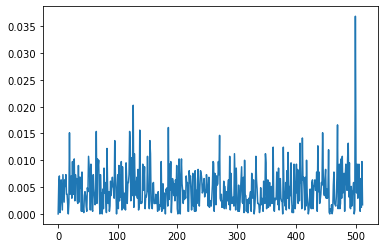

In [17]:
fnp5='00002496_0000.h5'
fd_np5=h5py.File(datadirp+fnp5, 'r')

index_map5=fd_np5['index_map']
blTot = 131328
blMatrix5 = np.zeros((512,512), dtype=int)

for i in range(blTot):
    x,y=index_map5['prod'][i]
    blMatrix5[x,y] = i 

diagEnt5 = np.diagonal(blMatrix5) #512 indexes
vis5=fd_np5['vis']
print(vis5.shape)
visp5 = np.array(vis5).transpose(2,0,1)
vis05 = visp5[:,15,:]


selected_values_list = [vis05[1][i] for i in diagEnt1]

# Create an empty array vis01ac with shape (256, 512)
vis05ac = np.empty((512, 512))

# Populate vis01ac[1] with the values from selected_values_list
vis05ac[1] = selected_values_list

plt.plot(list(range(512)), np.abs(selected_values_list))

(64, 131328, 256)


<ipython-input-6-79ac0e265438>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  vis06ac[1] = selected_values_list


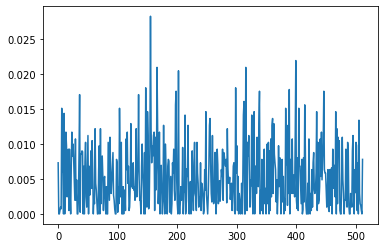

In [6]:
datadirp='/hirax/CHIME_Oct_2022/20221028T233752Z_chimedronegatedN2_corr/'
fnp6='00003994_0000.h5'
fd_np6=h5py.File(datadirp+fnp6, 'r')

index_map6=fd_np6['index_map']
blTot = 131328
blMatrix6 = np.zeros((512,512), dtype=int)

for i in range(blTot):
    x,y=index_map6['prod'][i]
    blMatrix6[x,y] = i 

diagEnt6 = np.diagonal(blMatrix6) #512 indexes
vis6=fd_np6['vis']
print(vis6.shape)
visp6 = np.array(vis6).transpose(2,0,1)
vis06 = visp6[:,52,:]


selected_values_list = [vis06[1][i] for i in diagEnt6]

plt.plot(list(range(512)), np.abs(vis06ac[1]))

In [28]:
print(vis01[0]==vis01ac[0])

False


<ipython-input-28-cb18538d5aa5>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(vis01[0]==vis01ac[0])


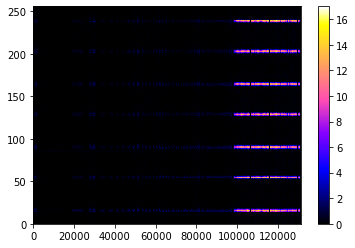

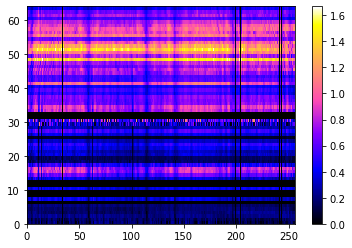

In [61]:
##No clue what Im plotting here. It supposed to be the autocorrs

plt.pcolormesh(np.abs(visloc),cmap='gnuplot2')
plt.colorbar()
plt.show()

plt.pcolormesh(np.abs(vis0),cmap='gnuplot2')
plt.colorbar()
plt.show()

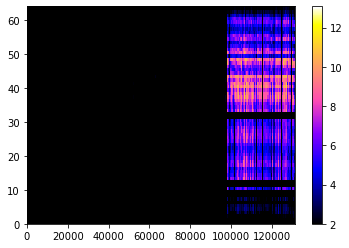

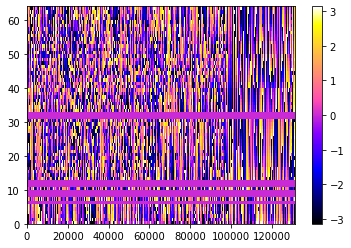

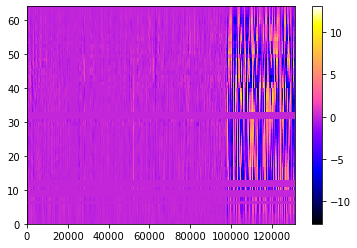

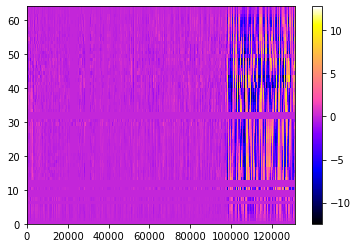

'\nimages=[im1,im2,im3,im4]\ntitles=[\'abs,\',\'ang\',\'real\',\'imag\']\nfor i,ax in enumerate([ax1,ax2,ax3,ax4]):\n    im=images[i]\n    ax.set_title(titles[i], fontsize=16)\n    #ax0.axvline(yf[feed],c=\'k\',linestyle=\'--\')\n    ax.set_ylabel(\'Frequency, [$MHz$]\', fontsize=14)\n    ax.set_xlabel(\'Location in x [$m$]\', fontsize=14)\n    divider=make_axes_locatable(ax)\n    cax=divider.append_axes("right", size="5%", pad=0.05)\n    cbar=fig.colorbar(im,cax=cax)\n    cbar.set_label(\'Power [$ADU^2$]\', fontsize=14)\n    #for k in (-50,50):\n     #   ax0.axvline(k,c=\'k\',linestyle=\'-\',alpha=0.5)\ntight_layout()\n\nindex = np.arange(len(blAmplitudeReal))\nax.plot(index,blAmplitudeReal)\nprint(blAmplitudeReal.shape)\nprint(index.shape)'

In [16]:
#fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(40,10))
vis0 = visp[128,:,:]

## Cross Only: Look at cross-corr data for one baseline?
#fig,[ax1,ax2,ax3,ax4]=subplots(nrows=1,ncols=4,figsize=(40,10))
#feeds=[0,1,2,3]
#tlb,tub=[234,265]
#feed=3
vmin1=2
vmax1=0.1
vmin2=-3.5
vmax2=2.5
''''vmin3=-.1
vmax3=.1
vmin4=-0.015
vmax4=0.01'''
xmg,fmg = np.meshgrid(np.arange(64), np.arange(131328))
plt.pcolormesh(np.abs(vis0),cmap='gnuplot2', vmin=vmin1)
plt.colorbar()
plt.show()
plt.pcolormesh(np.angle(vis0),cmap='gnuplot2')
plt.colorbar()
plt.show()
plt.pcolormesh(np.real(vis0),cmap='gnuplot2')
plt.colorbar()
plt.show()
plt.pcolormesh(np.imag(vis0),cmap='gnuplot2')
plt.colorbar()
plt.show()
#im3=ax3.pcolormesh(xmg,fmg,np.real(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin3, vmax=vmax3)
#im4=ax4.pcolormesh(xmg,fmg,np.imag(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin4, vmax=vmax4)
'''
images=[im1,im2,im3,im4]
titles=['abs,','ang','real','imag']
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    im=images[i]
    ax.set_title(titles[i], fontsize=16)
    #ax0.axvline(yf[feed],c='k',linestyle='--')
    ax.set_ylabel('Frequency, [$MHz$]', fontsize=14)
    ax.set_xlabel('Location in x [$m$]', fontsize=14)
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(im,cax=cax)
    cbar.set_label('Power [$ADU^2$]', fontsize=14)
    #for k in (-50,50):
     #   ax0.axvline(k,c='k',linestyle='-',alpha=0.5)
tight_layout()

index = np.arange(len(blAmplitudeReal))
ax.plot(index,blAmplitudeReal)
print(blAmplitudeReal.shape)
print(index.shape)'''

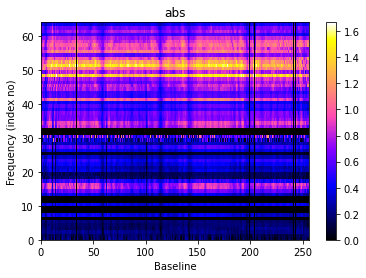

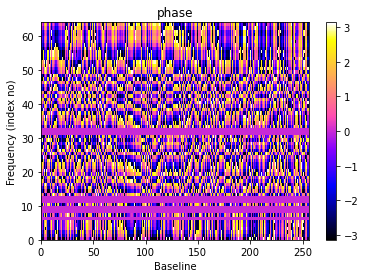

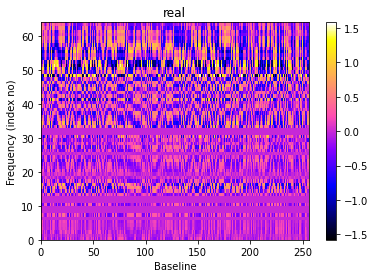

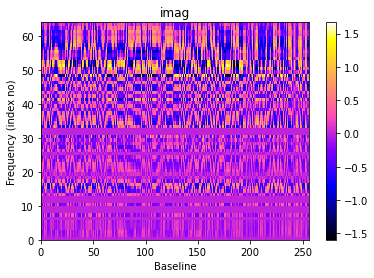

'\nimages=[im1,im2,im3,im4]\ntitles=[\'abs,\',\'ang\',\'real\',\'imag\']\nfor i,ax in enumerate([ax1,ax2,ax3,ax4]):\n    im=images[i]\n    ax.set_title(titles[i], fontsize=16)\n    #ax0.axvline(yf[feed],c=\'k\',linestyle=\'--\')\n    ax.set_ylabel(\'Frequency, [$MHz$]\', fontsize=14)\n    ax.set_xlabel(\'Location in x [$m$]\', fontsize=14)\n    divider=make_axes_locatable(ax)\n    cax=divider.append_axes("right", size="5%", pad=0.05)\n    cbar=fig.colorbar(im,cax=cax)\n    cbar.set_label(\'Power [$ADU^2$]\', fontsize=14)\n    #for k in (-50,50):\n     #   ax0.axvline(k,c=\'k\',linestyle=\'-\',alpha=0.5)\ntight_layout()\n\nindex = np.arange(len(blAmplitudeReal))\nax.plot(index,blAmplitudeReal)\nprint(blAmplitudeReal.shape)\nprint(index.shape)'

In [6]:
#fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(40,10))
vis0 = visp[128,:,98176:98432]

## Cross Only: Look at cross-corr data for one baseline?
#fig,[ax1,ax2,ax3,ax4]=subplots(nrows=1,ncols=4,figsize=(40,10))
#feeds=[0,1,2,3]
#tlb,tub=[234,265]
#feed=3
vmin1=2
vmax1=0.1
vmin2=-3.5
vmax2=2.5
''''vmin3=-.1
vmax3=.1
vmin4=-0.015
vmax4=0.01'''
xmg,fmg = np.meshgrid(np.arange(64), np.arange(256))
plt.pcolormesh(np.abs(vis0),cmap='gnuplot2')
plt.colorbar()
plt.title('abs')
plt.xlabel('Baseline')
plt.ylabel('Frequency (index no)')
plt.show()
plt.pcolormesh(np.angle(vis0),cmap='gnuplot2')
plt.colorbar()
plt.title('phase')
plt.xlabel('Baseline')
plt.ylabel('Frequency (index no)')
plt.show()
plt.pcolormesh(np.real(vis0),cmap='gnuplot2')
plt.colorbar()
plt.title('real')
plt.xlabel('Baseline')
plt.ylabel('Frequency (index no)')
plt.show()
plt.pcolormesh(np.imag(vis0),cmap='gnuplot2')
plt.colorbar()
plt.title('imag')
plt.xlabel('Baseline')
plt.ylabel('Frequency (index no)')
plt.show()
#im3=ax3.pcolormesh(xmg,fmg,np.real(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin3, vmax=vmax3)
#im4=ax4.pcolormesh(xmg,fmg,np.imag(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin4, vmax=vmax4)
'''
images=[im1,im2,im3,im4]
titles=['abs,','ang','real','imag']
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    im=images[i]
    ax.set_title(titles[i], fontsize=16)
    #ax0.axvline(yf[feed],c='k',linestyle='--')
    ax.set_ylabel('Frequency, [$MHz$]', fontsize=14)
    ax.set_xlabel('Location in x [$m$]', fontsize=14)
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(im,cax=cax)
    cbar.set_label('Power [$ADU^2$]', fontsize=14)
    #for k in (-50,50):
     #   ax0.axvline(k,c='k',linestyle='-',alpha=0.5)
tight_layout()

index = np.arange(len(blAmplitudeReal))
ax.plot(index,blAmplitudeReal)
print(blAmplitudeReal.shape)
print(index.shape)'''

In [21]:
print(vis0.shape)

(64, 256)


In [26]:
256/2

128.0

In [12]:
vis=fd_np['vis']
print(vis.shape) #freq, baseline, time
visp = np.array(vis).transpose(2,0,1) #time, freq, baseline
index_map=fd_np['index_map']
vis0 = visp[128,:,98176:98432]

(64, 131328, 256)
(-0.0012207031+0j)
(0.0029296875+0.0007324219j)


In [17]:
print(vis[0])

[[-0.0012207 +0.j          0.01708984+0.j         -0.00488281+0.j
  ...  0.00488281+0.j          0.01025391+0.j
  -0.00341797+0.j        ]
 [-0.00024414+0.00317383j  0.00561523+0.00512695j -0.00244141+0.00097656j
  ...  0.00830078+0.00195312j  0.00488281-0.00024414j
   0.00195312+0.00439453j]
 [-0.00634766-0.00537109j  0.00439453+0.00146484j  0.00683594-0.0090332j
  ... -0.00146484+0.00146484j -0.00244141+0.00244141j
   0.00463867-0.00732422j]
 ...
 [ 0.00097656+0.j          0.00952148+0.j          0.00830078+0.j
  ...  0.01245117+0.j          0.00683594+0.j
  -0.00366211+0.j        ]
 [ 0.00024414-0.01000977j -0.00585938-0.00317383j  0.00366211+0.0065918j
  ...  0.00292969+0.00244141j  0.0012207 +0.00317383j
  -0.00024414-0.00170898j]
 [ 0.00024414+0.j          0.00024414+0.j          0.00195312+0.j
  ... -0.00317383+0.j          0.00219727+0.j
   0.00927734+0.j        ]]


In [ ]:
vist = visp[:,18,98176:98432]

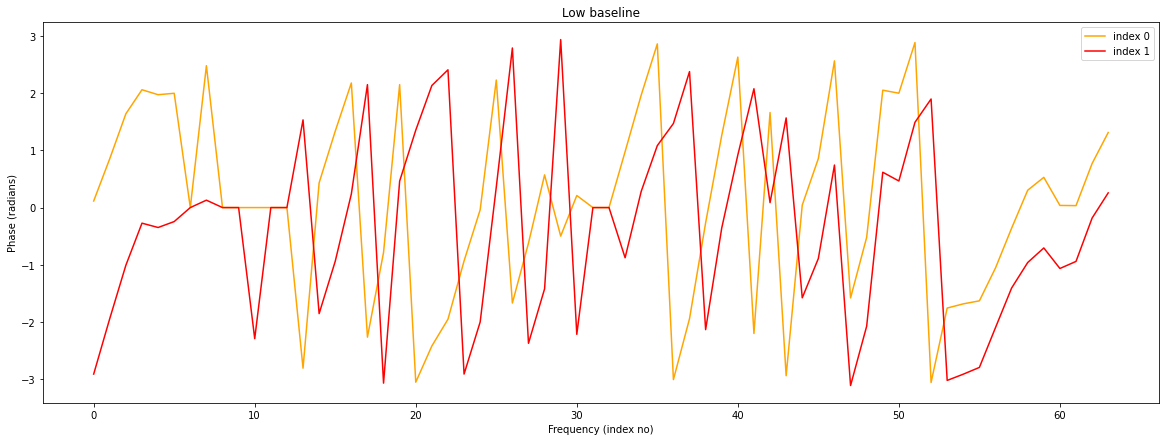

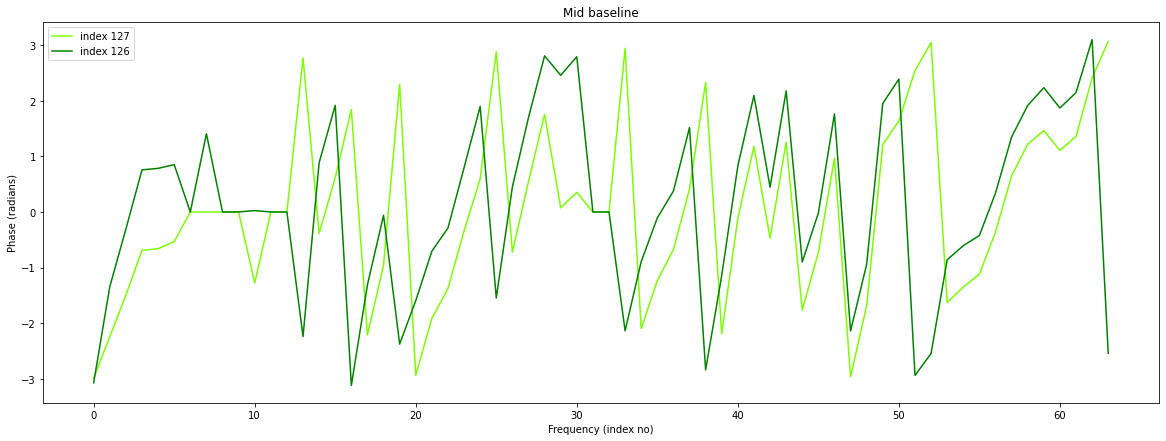

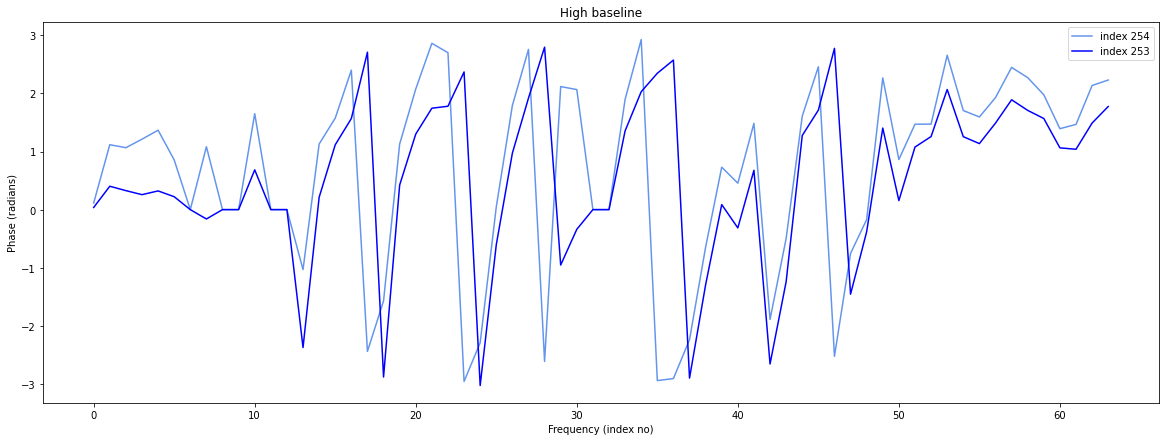

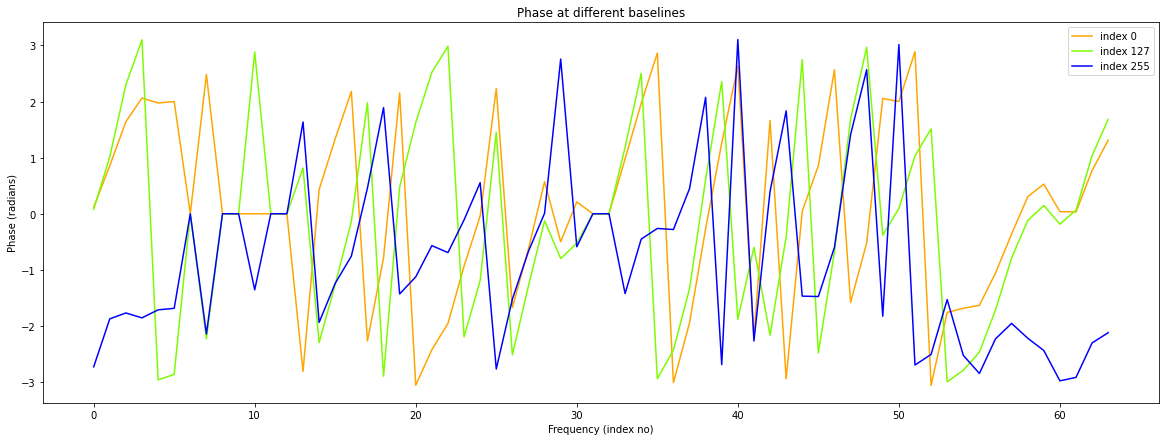

In [5]:
plt.figure(figsize=(20,7))
plt.plot(np.angle(vis0[:,0]), color='orange', label='index 0')
plt.plot(np.angle(vis0[:,1]), color='red', label='index 1')
plt.xlabel('Frequency (index no)')
plt.ylabel('Phase (radians)')
plt.title('Low baseline')
plt.legend()

plt.figure(figsize=(20,7))
plt.plot(np.angle(vis0[:,125]), color='lawngreen', label='index 127')
plt.plot(np.angle(vis0[:,126]), color='green', label='index 126')
plt.xlabel('Frequency (index no)')
plt.ylabel('Phase (radians)')
plt.title('Mid baseline')
plt.legend()


plt.figure(figsize=(20,7))
plt.plot(np.angle(vis0[:,254]), color='cornflowerblue', label='index 254')
plt.plot(np.angle(vis0[:,253]), color='blue', label='index 253')
plt.xlabel('Frequency (index no)')
plt.ylabel('Phase (radians)')
plt.title('High baseline')
plt.legend()

plt.figure(figsize=(20,7))
plt.plot(np.angle(vis0[:,0]), color='orange', label='index 0')
plt.plot(np.angle(vis0[:,127]), color='lawngreen', label='index 127')
plt.plot(np.angle(vis0[:,255]), color='blue', label='index 255')
plt.xlabel('Frequency (index no)')
plt.ylabel('Phase (radians)')
plt.title('Phase at different baselines')
plt.legend()


In [66]:
# Make it lower triangular for the problem setup
matrix = np.tril(blMatrix)

# Check the imaginary part of the diagonal entries
diagonal_imaginary_parts = np.imag(np.diag(matrix))

if np.all(diagonal_imaginary_parts == 0):
    print("All diagonal entries have zero imaginary parts.")
else:
    print("Some diagonal entries have non-zero imaginary parts.")

# Optionally, print which entries have non-zero imaginary parts
non_zero_imag_entries = np.where(diagonal_imaginary_parts != 0)[0]
if len(non_zero_imag_entries) > 0:
    print(f"Diagonal entries with non-zero imaginary parts at indices: {non_zero_imag_entries}")



All diagonal entries have zero imaginary parts.


In [ ]:
for b in blMatrix:
    plt.plot(vis0[:,b].imag)
    nz=np.nonzero(vis0[:,b].imag)
    if len(nz) == 0:
        print(b)
plt.show()

# NO autocorr

In [ ]:
figure(figsize=(20,15))
plt.plot(1e8*((vis0[44,:].imag)**2), marker='.',linestyle='None')
plt.ylim(-0.01,0.01)
plt.xlim(0,200)
print(1e8*((vis0[44,25:30].imag)**2))
print(vis0[44,28])

In [ ]:
plt.plot(vis0[44,:])

In [ ]:
fig,[ax1,ax2,ax3,ax4] = plt.subplots(nrows=1,ncols=4,figsize=(40,10))

blAmplitudeReal = np.real(visp[-1,-1,:])
blAmplitudeImag = np.imag(visp[-1,-1,:])
blAmplitudeAbs = np.abs(visp[-1,-1,:])
blAmplitudeAng = np.angle(visp[-1,-1,:])
index = np.arange(len(blAmplitudeReal))

print(index.shape)
print(blAmplitudeReal.shape)

im1=ax1.plot(index,blAmplitudeReal)
im2=ax2.plot(index,blAmplitudeImag)
im3=ax3.plot(index,blAmplitudeAbs)
im4=ax4.plot(index,blAmplitudeAng)
titles=['real','imag','abs','phase']
images=[im1,im2,im3,im4]

for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    im=images[i]
    ax.set_xlabel('Feed', fontsize = 14)
    ax.set_ylabel('Amplitude (units for vis)', fontsize = 14)
    ax.set_title(f'Index vs amplitudes {titles[i]}', fontsize=16)
    ax.autoscale(enable=True, axis='both')
    
plt.tight_layout()
plt.show()
    

In [ ]:
fig,[ax1,ax2,ax3,ax4]=subplots(nrows=1,ncols=4,figsize=(40,10))
feeds=[0,1,2,3]
t0=[280] #a time where the signal changes phases
fmg = np.meshgrid(EWN2concat.freq)
im1=ax1.pcolormesh(xmg,fmg,np.abs(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin1, vmax=vmax1)
im2=ax2.pcolormesh(xmg,fmg,np.angle(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin2, vmax=vmax2)
im3=ax3.pcolormesh(xmg,fmg,np.real(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin3, vmax=vmax3)
im4=ax4.pcolormesh(xmg,fmg,np.imag(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin4, vmax=vmax4)

images=[im1,im2,im3,im4]
titles=['abs,','ang','real','imag']
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    im=images[i]
    ax.set_title(titles[i], fontsize=16)
    #ax0.axvline(yf[feed],c='k',linestyle='--')
    ax.set_ylabel('Frequency, [$MHz$]', fontsize=14)
    ax.set_xlabel('Location in x [$m$]', fontsize=14)
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(im,cax=cax)
    cbar.set_label('Power [$ADU^2$]', fontsize=14)
    #for k in (-50,50):
     #   ax0.axvline(k,c='k',linestyle='-',alpha=0.5)
tight_layout()

<ipython-input-50-dc2779bce1fe>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1=ax1.pcolormesh(xmg,fmg,np.abs(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin1, vmax=vmax1)
<ipython-input-50-dc2779bce1fe>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2=ax2.pcolormesh(xmg,fmg,np.angle(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin2, vmax=vmax2)
<ipython-input-50-dc2779bce1fe>:17: MatplotlibDe

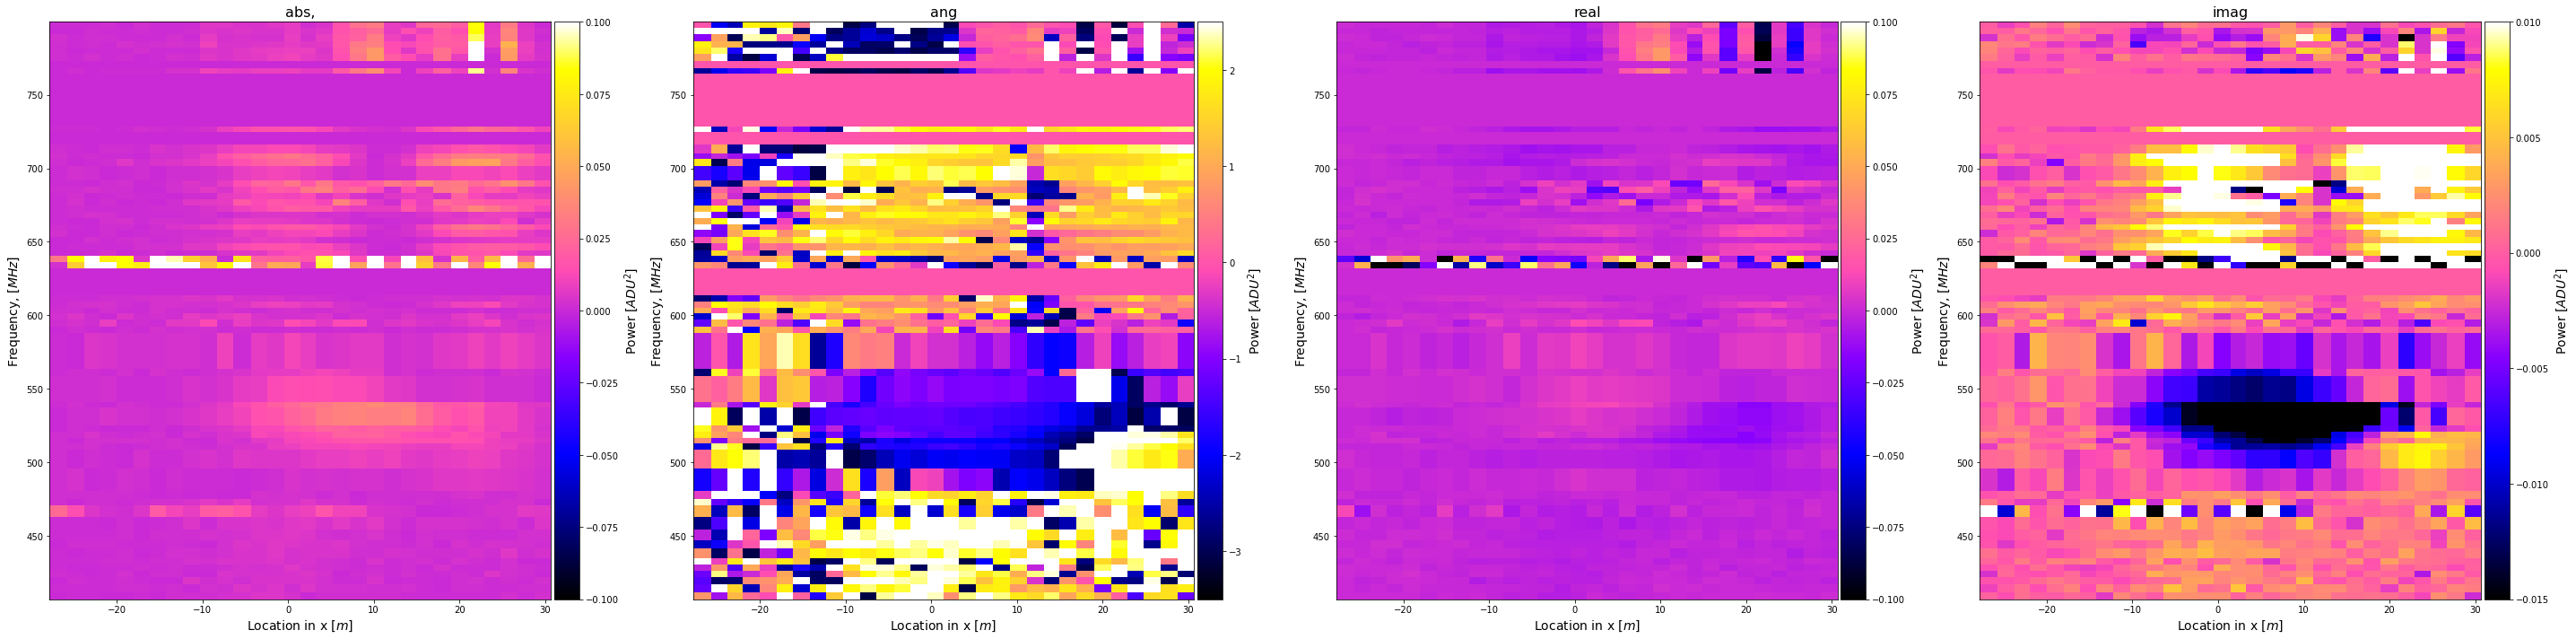

In [50]:
## Cross Only: Look at cross-corr data for one baseline?
fig,[ax1,ax2,ax3,ax4]=subplots(nrows=1,ncols=4,figsize=(40,10))
feeds=[0,1,2,3]
tlb,tub=[234,265]
feed=3
vmin1=-.1
vmax1=0.1
vmin2=-3.5
vmax2=2.5
vmin3=-.1
vmax3=.1
vmin4=-0.015
vmax4=0.01
xmg, fmg = np.meshgrid(EWN2concat.drone_xyz_LC_interp[tlb:tub, 0], EWN2concat.freq)
im1=ax1.pcolormesh(xmg,fmg,np.abs(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin1, vmax=vmax1)
im2=ax2.pcolormesh(xmg,fmg,np.angle(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin2, vmax=vmax2)
im3=ax3.pcolormesh(xmg,fmg,np.real(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin3, vmax=vmax3)
im4=ax4.pcolormesh(xmg,fmg,np.imag(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed])),cmap='gnuplot2',vmin=vmin4, vmax=vmax4)

images=[im1,im2,im3,im4]
titles=['abs,','ang','real','imag']
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    im=images[i]
    ax.set_title(titles[i], fontsize=16)
    #ax0.axvline(yf[feed],c='k',linestyle='--')
    ax.set_ylabel('Frequency, [$MHz$]', fontsize=14)
    ax.set_xlabel('Location in x [$m$]', fontsize=14)
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(im,cax=cax)
    cbar.set_label('Power [$ADU^2$]', fontsize=14)
    #for k in (-50,50):
     #   ax0.axvline(k,c='k',linestyle='-',alpha=0.5)
tight_layout()

In [ ]:
for index, value in enumerate(EWN2concat.freq):
    print(f"Index {index}: {value}")

In [ ]:
xmg, fmg = np.meshgrid(EWN2concat.drone_xyz_LC_interp[tlb:tub, 0], EWN2concat.freq)  # Time/location and frequency meshgrid

print("Shape of fmg:", fmg.shape)

for index, freq in enumerate(fmg[:, 0]):
    print(f"Index: {index}, Frequency: {freq}")


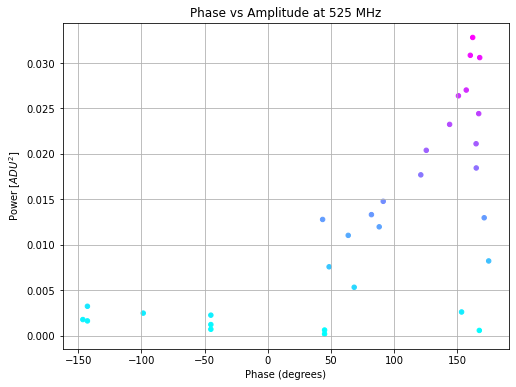

In [42]:
import numpy as np
import matplotlib.pyplot as plt

feeds=[0,1,2,3]
tlb,tub=[234,265]
feed = 2
xmg, fmg = np.meshgrid(EWN2concat.drone_xyz_LC_interp[tlb:tub, 0], EWN2concat.freq)
pwrEWN2= np.abs(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed]))[44,:] #Index 44 corresponds to 525 MHz
phaseEWN2= np.degrees(np.angle(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed]))[44,:])
realEWN2= np.real(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed]))[44,:]
imagEWN2= np.imag(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed]))[44,:]

# Plot phase vs amplitude
plt.figure(figsize=(8, 6))
plt.scatter(phaseEWN2, pwrEWN2, c=pwrEWN2, cmap='cool', s=20, alpha=1)
plt.xlabel('Phase (degrees)')
plt.ylabel('Power [$ADU^2$]')
plt.title(f'Phase vs Amplitude at 525 MHz')
plt.grid(True)
plt.show()


In [44]:
'''
feeds = [0, 1, 2, 3]
tlb, tub = [234, 265]
for index, freq in enumerate(fmg[:, 0]):
    pwrEWN2 = np.abs(np.transpose(EWN2concat.V_cross[tlb:tub, :, feed]))[index, :]
    phaseEWN2 = np.degrees(np.angle(np.transpose(EWN2concat.V_cross[tlb:tub, :, feed]))[index, :])
    plt.figure(figsize=(8, 6))
    plt.scatter(phaseEWN2, pwrEWN2, c=pwrEWN2, cmap='cool', s=20, alpha=1)
    plt.xlabel('Phase (degrees)')
    plt.ylabel('Amplitude')
    plt.title(f'Phase vs Amplitude at Frequency Index {freq}')
    plt.grid(True)
    plt.show()
    '''
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

feeds = [0, 1, 2, 3]
tlb, tub = [234, 265]

def plot_phase_vs_amplitude(freq_index):
    freq = fmg[freq_index, 0]
    pwrEWN2 = np.abs(np.transpose(EWN2concat.V_cross[tlb:tub, :, feed]))[freq_index, :]
    phaseEWN2 = np.degrees(np.angle(np.transpose(EWN2concat.V_cross[tlb:tub, :, feed]))[freq_index, :])
    
    plt.figure(figsize=(8, 6))
    plt.scatter(phaseEWN2, pwrEWN2, c=pwrEWN2, cmap='cool', s=20, alpha=1)
    plt.xlabel('Phase (degrees)')
    plt.ylabel('Power [$ADU^2$]')
    plt.title(f'Phase vs Power at Frequency {freq} MHz')
    plt.grid(True)
    plt.show()

# Slider
freq_index_slider = widgets.IntSlider(min=0, max=len(fmg) - 1, step=1, value=0, description='Index:')
widgets.interactive(plot_phase_vs_amplitude, freq_index=freq_index_slider)


interactive(children=(IntSlider(value=0, description='Index:', max=63), Output()), _dom_classes=('widget-inter…

In [49]:
## 
'''
Here I am looking at the phase vs amplitude for different frequencies in the data.
As we are looking at a beam, I expect the data to look Gaussian. Thus, the fit.
'''
feeds=[0,1,2,3]
tlb,tub=[234,265]
feed = 3
xmg, fmg = np.meshgrid(EWN2concat.drone_xyz_LC_interp[tlb:tub, 0], EWN2concat.freq)
#pwrEWN2= np.abs(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed]))[44,:] #Index 44 corresponds to 525 MHz
#phaseEWN2= np.degrees(np.angle(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed]))[44,:])
#realEWN2= np.real(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed]))[44,:]
#imagEWN2= np.imag(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed]))[44,:]


def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

def plotPhaseVsAmplitude(index):
    freq = fmg[index, 0]  # Get the frequency value corresponding to the index
    pwrEWN2 = np.abs(np.transpose(EWN2concat.V_cross[tlb:tub, :, feed]))[index, :]
    phaseEWN2 = np.degrees(np.angle(np.transpose(EWN2concat.V_cross[tlb:tub, :, feed]))[index, :])
    
    # Preprocess data by removing outliers
    phase_cleaned, pwr_cleaned = remove_outliers(phaseEWN2, pwrEWN2)
    
    # Fit Gaussian curve to the cleaned data with refined initial guess and increased maxfev
    initial_guess = [max(pwr_cleaned), np.mean(phase_cleaned), np.std(phase_cleaned)]
    popt, pcov = curve_fit(gaussian, phase_cleaned, pwr_cleaned, p0=initial_guess, maxfev=20000)
    
    # Plot scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(phaseEWN2, pwrEWN2, c=phaseEWN2, cmap='cool', s=20, alpha=1)
    plt.xlabel('Phase (degrees)')
    plt.ylabel('Power [$ADU^2$]')
    plt.title(f'Phase vs Power for feed {feed} at {freq} MHz')
    plt.grid(True)
    
    # Plot Gaussian fit curve
    x_fit = np.linspace(min(phaseEWN2), max(phaseEWN2), 100)
    y_fit = gaussian(x_fit, *popt)
    plt.plot(x_fit, y_fit, color='red', label='Gaussian Fit')
    plt.legend()
    
    plt.show()

# This might not be well-suited for fitting other functions.
def remove_outliers(x, y, threshold=3):
    mean_y = np.mean(y)
    std_y = np.std(y)
    outliers = np.abs(y - mean_y) > threshold * std_y
    return x[~outliers], y[~outliers]

# Create a slider for frequency index
freq_index_slider = widgets.IntSlider(min=0, max=len(fmg) - 1, step=1, value=0, description='Index:')

# Link slider to the plotting function
widgets.interactive(plotPhaseVsAmplitude, index=freq_index_slider)


interactive(children=(IntSlider(value=0, description='Index:', max=63), Output()), _dom_classes=('widget-inter…

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some data
x = np.linspace(0, 10, 100)
y = np.sin(x)
colors = x  # Use x-values for colors

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=colors, cmap='viridis', s=50, alpha=0.7)  # Use 'viridis' colormap
plt.colorbar(label='X-axis values')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Colormap')
plt.grid(True)
plt.show()


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from ipywidgets import interact, FloatSlider

# Sampling frequency
fs = 1000  
# Time vector
t = np.arange(0, 10, 1/fs)  

# Create a signal with multiple frequencies
signal = EWN2concat.V_cross[tlb:tub,:,feed]

# Define the function to plot phase vs amplitude in degrees
def plot_phase_amplitude(frequency):
    N = len(signal)
    # Compute the FFT of the signal
    fft_values = fft(signal)
    freqs = fftfreq(N, 1/fs)
    
    # Find the index of the closest frequency in the FFT
    freq_idx = np.argmin(np.abs(freqs - frequency))
    
    # Compute amplitude and phase
    amplitude = np.abs(fft_values[freq_idx])
    phase = np.angle(fft_values[freq_idx])
    
    # Convert phase to degrees
    phase_degrees = np.angle(np.transpose(EWN2concat.V_cross[tlb:tub,:,feed]))
    
    # Plot phase vs amplitude
    plt.figure(figsize=(8, 6))
    plt.scatter(phase_degrees, amplitude, color='blue')
    plt.xlabel('Phase (degrees)')
    plt.ylabel('Amplitude')
    plt.title(f'Phase vs Amplitude at {frequency} Hz')
    plt.grid(True)
    plt.show()

# Create the interactive slider
interact(plot_phase_amplitude, frequency=FloatSlider(min=450, max=100, step=0.1, value=10));



TraitError: Setting min > max